# Fe microspectrocopy data from BNL

**Fe_xanes** (from HXN) is a model system sample used for optimizing nano-XANES workflow. We know the "true value" chemical state map. The aggregate is composed of 
        
        1. LiFe(II)PO4 (LFP)

        2. Pyrite (Pyr)

        3. StainlessSteelNP (SS)

        4. Hematite_NP (Hem)

In [1]:
from sklearnex import patch_sklearn # intel acceleration using patching
from sklearnex import unpatch_sklearn

See intel's website for speed-up package options [link](https://www.intel.com/content/www/us/en/develop/documentation/installation-guide-for-intel-oneapi-toolkits-windows/top/installation/install-using-package-managers/pip.html)

See this [Github](https://github.com/IntelSoftware/Machine-Learning-using-oneAPI) for tutorials

command line:
``` python
python -m sklearnex my_file.py
```

to unpatch:
``` python 
unpatch_sklearn("PCA")
```

to patch:
``` python
patch_sklearn("SVC")
```

In [2]:
patch_sklearn()  # sets up listener --> use intel's patch when importing when available

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from ipywidgets import IntSlider, widgets, interactive, fixed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import selector
from selector import energy_point_selector
from importlib import reload

from scipy.signal import correlate, correlate2d
from skimage.registration import phase_cross_correlation

import utils
utils = reload(utils)
from utils import *

np.random.seed(42)

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in data

In [6]:
Fe_xanes = parse_tiff('Data/HXN_XANES/nanoXANES_Fe.tiff')
Fe_energy = np.loadtxt('Data/HXN_XANES/energy_list_corr.txt')

expected_results = parse_tiff('Data/HXN_XANES/chemical_map.tiff')
df = pd.read_csv('Data/HXN_XANES/xanes_fit_plot.csv')

In [7]:
Fe_xanes.shape

(73, 155, 160)

In [8]:
elements = ['Cr', 'Fe', 'P', 'S', 'Si']
# Cr = SS, P = LFP, S = pyr
xrfs = {ele: parse_tiff(f'Data/HXN_XANES/XRF_Images/SUM_maps_XRF_{ele}_K.tiff')[0, 5:, :]
        for ele in elements}

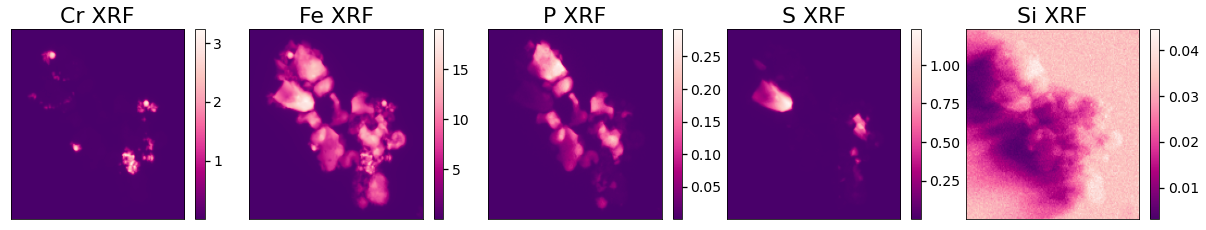

In [9]:
fig, axes = plt.subplots(figsize=(4.2 * len(elements), 3.5), ncols=len(elements))
plt.subplots_adjust(wspace=0.1)

for i, ax in enumerate(axes):
    img = ax.imshow(xrfs[elements[i]], extent=[0, 1, 0, 1], aspect='auto', cmap=plt.cm.RdPu_r)
    remove_ticks(ax)
    ax.set_title(f'{elements[i]} XRF', fontsize=22)
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.tick_params(width=1.3, length=5, labelsize=14)

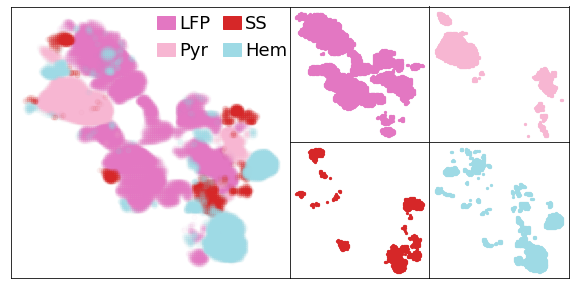

In [13]:
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(nrows=2, ncols=3,
                        width_ratios=[1, 0.5, 0.5])
plt.subplots_adjust(hspace=0.0, wspace=0.0)

bigax = fig.add_subplot(spec[:2, 0])

labels = ['LFP', 'Pyr', 'SS', 'Hem']
color_labels = [12, 13, 6, 19]

for i, img in enumerate(expected_results):
    row = i // 2
    colm = i % 2 + row // 2
    ax = fig.add_subplot(spec[row, colm + 1])
    
    threshold = 0.025
    mask = np.zeros((img.shape[0], img.shape[1]))
    bool_arr = img < threshold
    mask[bool_arr] = 1
    filtered_img = np.ma.array(img, mask=mask)
    
    filtered_img_dict = {}
    for x in range(filtered_img.shape[0]):
        for y in range(filtered_img.shape[1]):
            if mask[x, y] == False:
                filtered_img_dict[(x, y)] = filtered_img[x, y]
                
    for j, key in enumerate(list(filtered_img_dict.keys())):
        x, y = key
        ax.plot(y, -x, color=plt.cm.tab20(color_labels[i]), marker='.', markersize=4.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
plot_expected_results(expected_results, bigax)

plt.savefig('Figures/expected_results.png', dpi=400,
            transparent=True, bbox_inches='tight')

# Iron References

## Interpolating everything onto same energy grid

In [10]:
ref_energy, Refs_dict_tmp, _ = parse_nor('Data/HXN_XANES/FeLibNov2021.nor')

data_columns = ['StainlessSteelNP', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'FeIII_sulfate', 'Fe(III)PO4', 'Hematite_NP',
                'Maghemite', 'Goethite', 'HFO']

Refs_dict = {key: Refs_dict_tmp[key] for key in data_columns}
Refs_raw = np.array(list(Refs_dict.values()))

data_columns = ['Stainless Steel', 'Fe3P', 'Pyrite', 'LiFe(II)PO4', 
                'Magnetite', 'Fe(III)SO4', 'Fe(III)PO4', 'Hematite',
                'Maghemite', 'Goethite', 'HFO']
energy = np.linspace(7090, 7196, 54) #107

interperlator = interp1d(ref_energy, Refs_raw)
Refs = interperlator(energy)

Fe_xanes_tmp = np.zeros((len(energy), Fe_xanes.shape[1], Fe_xanes.shape[2]))
for x in range(Fe_xanes.shape[1]):
    for y in range(Fe_xanes.shape[2]):
        interperlator = interp1d(Fe_energy, Fe_xanes[:, x, y])
        Fe_xanes_tmp[:, x, y] = interperlator(energy)

Fe_xanes = Fe_xanes_tmp
Fe_energy = energy

(12, 196)


# Some visualization

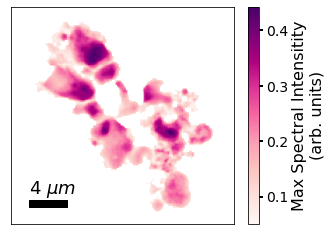

In [8]:
data = Fe_xanes
width = data.shape[1]
height = data.shape[2]

fig, ax = plt.subplots(figsize=(5, 4))

cmap = plt.cm.RdPu
img = ax.imshow(np.max(get_filtered_img(data), axis=0), extent=[0, 1, 0, 1],
                aspect='auto', cmap=cmap)
rect = mpatches.Rectangle((0.08, 0.08), 26.6667 * 1 / width, 5 * 1 / height, color='k')
ax.add_patch(rect)
ax.text(0.08, .14, '4 $\mu m$', fontsize=18, transform=ax.transData) # 1 pixel = 150 nm

remove_ticks(ax)

cbar = plt.colorbar(img, ax=ax)
cbar.ax.tick_params(width=2, length=4, labelsize=14)
cbar.ax.set_ylabel('Max Spectral Intensitity\n(arb. units)', fontsize=16)
plt.savefig('Figures/two-dim_heatmap.png', dpi=600,
            transparent=True, bbox_inches='tight')

In [160]:
%matplotlib inline

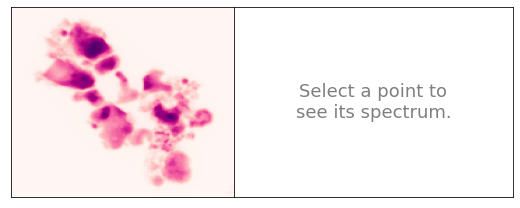

In [161]:
data = Fe_xanes

fig = plt.figure(figsize=(9, 3.5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.8, 1.])
plt.subplots_adjust(wspace=0.)

ax = fig.add_subplot(spec[0])
img = ax.imshow(np.max(data, axis=0), extent=[0, 1, 0, 1], aspect='auto',
                cmap=plt.cm.RdPu)

ax = fig.add_subplot(spec[1])
ax.text(0.5, 0.5, "Select a point to\nsee its spectrum.", fontsize=18, ha='center', va='center',
        c=plt.cm.tab10(7))

for ax in fig.get_axes():
    remove_ticks(ax)

add_point_label(img, data, ax)

# Step 1. Filter out background, i.e., space with no sample

In [11]:
data = Fe_xanes
energy = Fe_energy

fd, mask = get_filtered_img(data, return_mask=True)

filtered_spectra_dict = {}
for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        if mask[0, x, y] == False:
            spectrum = fd[:, x, y]
            filtered_spectra_dict[(x, y)] = spectrum
filtered_spectra = np.array(list(filtered_spectra_dict.values()))

# Step 2. Normalize experimental spectra

In [8]:
utils = reload(utils)
from utils import *

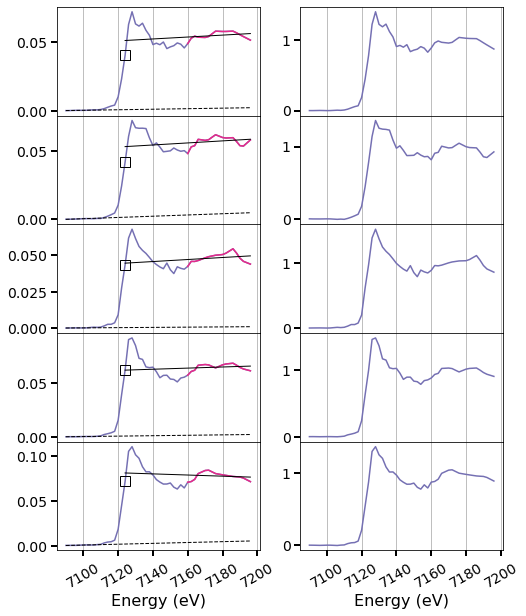

In [45]:
pre_edge, post_edge, whitelines = show_normalization(energy, filtered_spectra, N=5, return_params=True,
                                                     plot=True, pre_edge_offset=10, post_edge_offset=18,
                                                     whiteline_range=-1, colors=[plt.cm.Dark2(i) for i in [2, 3]])

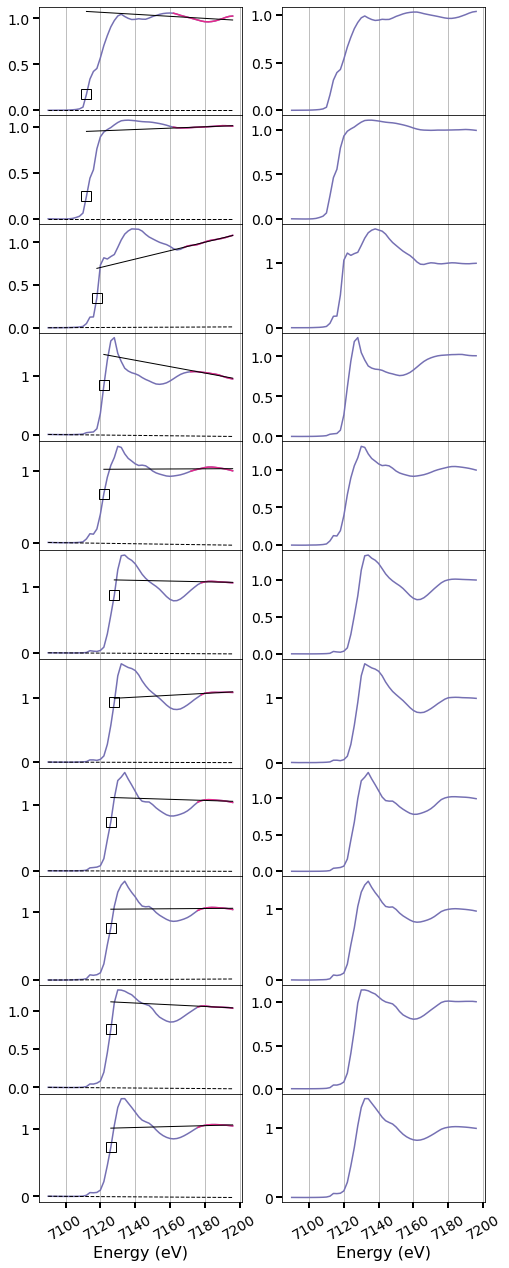

In [46]:
pre_edge, post_edge, whitelines = show_normalization(energy, Refs, N=11, return_params=True,
                                                     plot=True, pre_edge_offset=10, post_edge_offset=25,
                                                     whiteline_range=-1, colors=[plt.cm.Dark2(i) for i in [2, 3]])

In [12]:
normalized_spectra, normalized_spectra_dict = normalize_spectra(energy,
                                                                filtered_spectra,
                                                                filtered_spectra_dict,
                                                                whiteline_range=-1,
                                                                pre_edge_offset=10,
                                                                post_edge_offset=18)
# Renormalize references
Refs, Refs_dict = normalize_spectra(energy, Refs, Refs_dict, pre_edge_offset=10,
                                    post_edge_offset=25, whiteline_range=-1)
Refs = np.array(Refs)

In [13]:
utils = reload(utils)
from utils import *

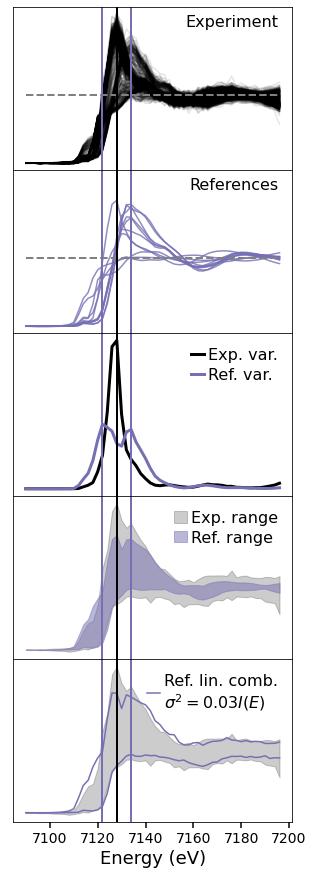

In [52]:
fig, axes = plt.subplots(figsize=(5, 15), nrows=5)
plt.subplots_adjust(hspace=0)
labels = ['Experiment', 'References']

# axes[0]
for i, s in enumerate(normalized_spectra):
    if i % 10 == 0:
        axes[0].plot(energy, s, 'k-', alpha=0.1)

# axes[1]
for r in Refs:
    axes[1].plot(energy, r, '-', c=plt.cm.Dark2(2), alpha=0.8)

# axes[2]
axes[2].plot(energy, np.var(normalized_spectra, axis=0), c='k', linewidth=3, label='Exp. var.')
axes[2].plot(energy, np.var(Refs, axis=0), c=plt.cm.Dark2(2), linestyle='-', linewidth=3, label='Ref. var.')

# axes[3]
axes[3].fill_between(energy, np.max(normalized_spectra, axis=0),
                     np.min(normalized_spectra, axis=0), label='Exp. range',
                     color='k', alpha=0.2)
axes[3].fill_between(energy, np.max(Refs, axis=0), np.min(Refs, axis=0),
                     color=plt.cm.Dark2(2), alpha=0.5, label='Ref. range')

# axes[4]
noise = 0.03
kwargs = {'N': 500, 'scale': noise, 'dropout': 0.9}
lin_combos, _ = generate_linear_combos(Refs, **kwargs)
axes[4].fill_between(energy, np.max(normalized_spectra, axis=0),
                     np.min(normalized_spectra, axis=0),
                     color='k', alpha=0.2)
axes[4].plot(energy, np.max(lin_combos, axis=0), '-',
             color=plt.cm.Dark2(2), label='Ref. lin. comb.\n' +
             f'$\sigma^2=$' + f'{noise}' + '$I(E)$')
axes[4].plot(energy, np.min(lin_combos, axis=0), '-', color=plt.cm.Dark2(2))

for i, ax in enumerate(axes):
    if i in [0, 1]:
        ax.plot(energy, np.ones(len(energy)), '--', c='gray', linewidth=2)
        ax.set_ylim(-0.1, 2.3)
        ax.text(0.95, 0.95, labels[i], transform=ax.transAxes, fontsize=16, ha='right', va='top')
    if i in [2, 3, 4]:
        ax.legend(fontsize=16, handlelength=0.8, framealpha=0, labelspacing=0.3, handletextpad=0.25)
    if i in [0, 1, 2, 3]:
        ax.set_xticks([])
    if i in [4]:
        ax.set_xlabel('Energy (eV)', fontsize=18)
    ax.set_yticks([])
    ax.tick_params(length=6, labelsize=14, width=1.5)
    ax.axvline(x=7122, c=plt.cm.Dark2(2), linestyle='-', linewidth=2)
    ax.axvline(x=7134, c=plt.cm.Dark2(2), linestyle='-', linewidth=2)
    ax.axvline(x=7128, c='k', linestyle='-', linewidth=2)

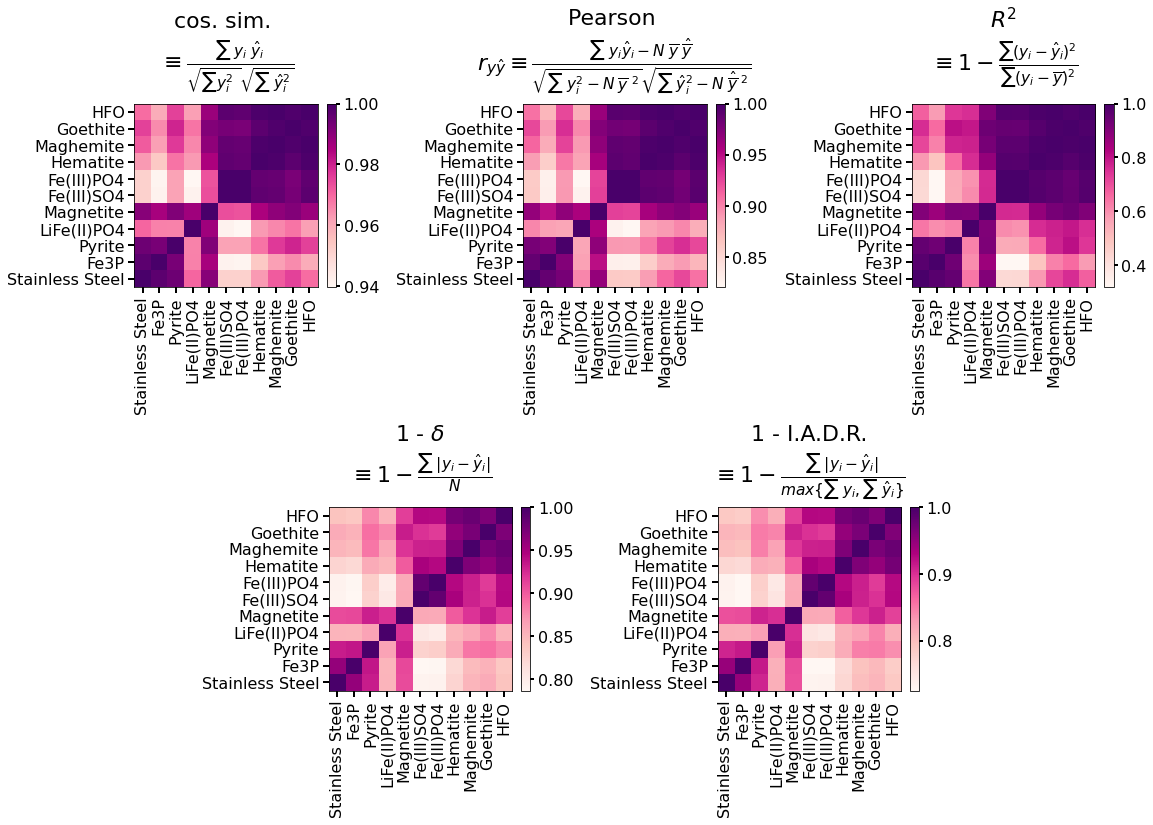

In [53]:
metrics = ['cosine similarity', 'Pearson correlation', '$R^2$', '1 - $\delta$', '1 - IADR']

fig = plt.figure(figsize=(3 * 6, 5.4 * 2))
spec = fig.add_gridspec(ncols=6, nrows=2)
plt.subplots_adjust(wspace=5., hspace=1.2)
plots = [spec[0, :2], spec[0, 2:4], spec[0, 4:], spec[1, 1:3], spec[1, 3:5]]
axes = [fig.add_subplot(plot) for plot in plots]

for i, metric in enumerate(metrics):
    Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
    plot_corr_matx(axes[i], Similarity_matrix, data_columns, metric)
    if i in [3, 4]:
        y = 1.1
    else:
        y = 1.15
    axes[i].set_title(axes[i].get_title(), fontsize=22, y=y)
    
plt.savefig('Figures/similarity_matrices.png', dpi=400, transparent=False, bbox_inches='tight')

In [54]:
utils = reload(utils)
from utils import *

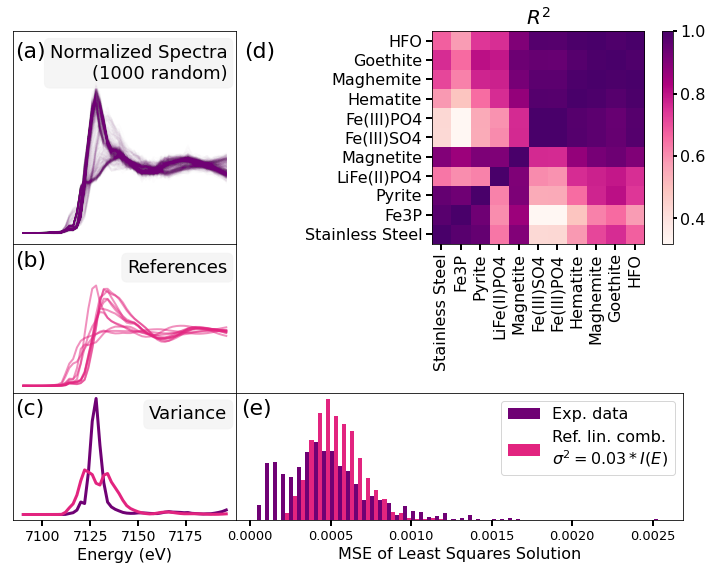

In [55]:
fig = plt.figure(figsize=(12, 9))
spec = fig.add_gridspec(nrows=3, ncols=2,
                        height_ratios=[1, 0.7, 0.6], width_ratios=[0.5, 1])
plt.subplots_adjust(hspace=0., wspace=0.)
axes = []
for i in range(3):
    tmp = [fig.add_subplot(spec[i, j]) for j in range(2)]
    axes.append(tmp)
    
colors = [plt.cm.RdPu(0.9), plt.cm.PuRd(0.65)]
w = (.95, .95, .95, 0.7)
white_bbox = dict(boxstyle="round", ec=w, fc=w)

c = 0
N = 1000
tmp_X = []
for i in range(len(filtered_spectra)):
    mod = 2
    x = normalized_spectra[mod * i]
    tmp_X.append(x)
    axes[0][0].plot(energy, normalized_spectra[mod * i], linewidth=1.5, alpha=0.01,
                    color=colors[0])
    c += 1
    if c > N:
        tmp_X = np.array(tmp_X)
        axes[0][0].plot(energy[0], [2.8], '.', c='w', alpha=0)
        break

axes[2][0].plot(energy, np.var(tmp_X, axis=0), linewidth=3, c=colors[0])

for i, r in enumerate(Refs):
    axes[1][0].plot(energy, r, linewidth=2, alpha=0.5, color=colors[1])
axes[1][0].plot(energy[0], [2.5], '.', c='w', alpha=0)

axes[2][0].plot(energy, np.var(Refs, axis=0), linewidth=3, c=colors[1])

labels = [f'Normalized Spectra\n({N} random)', 'References', 'Variance']

panels = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i, ax_list in enumerate(axes):
    for j, ax in enumerate(ax_list):
        if j == 0:
            if i == 0:
                y = 0.94
                ax.text(0.96, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='right',
                        bbox=white_bbox)
            else:
                y = 0.9
                ax.text(0.96, y, labels[i], transform=ax.transAxes, fontsize=18, va='top', ha='right',
                        bbox=white_bbox)
            ax.tick_params(direction='out', width=2, length=6, labelsize=14)
            ax.set_yticks([])
            if i != 2:
                ax.set_xticks([])
            else:
                ax.set_xticks([7100, 7125, 7150, 7175])
                ax.set_xlabel('Energy (eV)', fontsize=16)
            
            ax.text(0.01, 0.95, panels[i], transform=ax.transAxes, 
                    fontsize=22, va='top', ha='left')
        
        elif (i, j)  == (0, 1):
            ax.text(-0.88, 0.95, panels[3], transform=ax.transAxes, 
                    fontsize=22, va='top', ha='left')
        elif (i, j)  == (2, 1):
            ax.text(0.01, 0.95, panels[4], transform=ax.transAxes, 
                    fontsize=22, va='top', ha='left')
metric = '$R^2$'
Similarity_matrix = get_similarity_mtx(Refs, metric=metric)
metric = '$ R^2 $'
plot_corr_matx(axes[0][1], Similarity_matrix, data_columns, metric)

axes[1][1].axis('off')
plot_MSE_hist(axes[2][1], tmp_X, Refs, bins=50, colors=colors, scale=0.03)
plt.savefig('Figures/Data_vs_Refs.png', dpi=600, bbox_inches='tight', transparent=True)

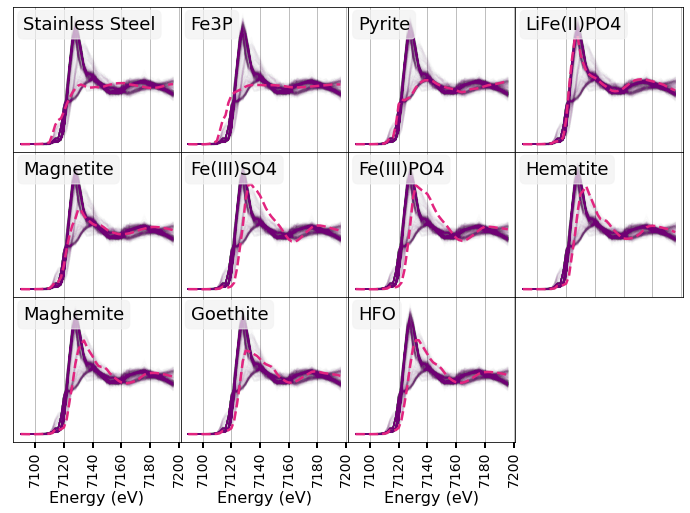

In [56]:
fig, axes = plt.subplots(figsize=(12, 8), nrows=3, ncols=4)
plt.subplots_adjust(hspace=0., wspace=0)

for i, axlist in enumerate(axes):
    for j, ax in enumerate(axlist):
        idx = i * 4 + j
        if idx < len(Refs):
            ax.plot(energy.reshape(-1, 1), tmp_X.T, linewidth=1.5, alpha=0.008, color=colors[0])
            ax.plot(energy, Refs[idx], linewidth=2.5, linestyle='--', alpha=1., color=colors[1])
            ax.plot(energy[0], [2.1], '.', c='w', alpha=0)
            
            ax.tick_params(width=2, length=6, labelsize=14)
            ax.set_yticks([])
            ax.xaxis.set_major_locator(MultipleLocator(20))
            ax.tick_params(axis='x', rotation=90)
            ax.grid()
            if i != 2:
                ax.set_xlabel(None)
                ax.xaxis.set_ticklabels([])
                ax.xaxis.set_ticks_position('none')
            else:
                ax.set_xlabel('Energy (eV)', fontsize=16)
                
            ax.text(0.06, 0.94, data_columns[idx], transform=ax.transAxes, fontsize=18,
                    va='top', ha='left', bbox=white_bbox)
        else:
            ax.axis('off')

In [57]:
def get_residuals(data, Refs):
    residuals = []
    for i in range(len(data)):
        print(i, end='\r')
        A = Refs.T
        y = data[i]
        x = np.linalg.pinv(A.T @ A) @ A.T @ y

        fit = A @ x
        true = y
        residuals.append(A @ x - y)
    return np.array(residuals)

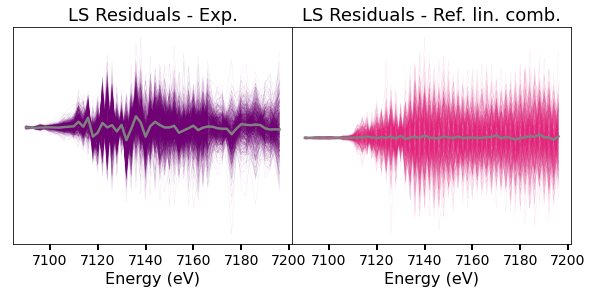

In [58]:
exp_res = get_residuals(tmp_X, Refs)

kwargs = {'N': 500, 'scale': 0.03, 'dropout': 0.85}
lcs, _ = generate_linear_combos(Refs, **kwargs)
lc_res = get_residuals(lcs, Refs)

fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
plt.subplots_adjust(wspace=0, hspace=0)
labels = ['LS Residuals - Exp.', 'LS Residuals - Ref. lin. comb.']
reses = [exp_res, lc_res]

for i, ax in enumerate(axes):
    res = reses[i]
    for r in res:
        ax.plot(energy, r, color=colors[i], linewidth=0.2, alpha=0.2)
    ax.plot(energy, np.average(res, axis=0), linewidth=2.5, color='gray')
    ax.set_xlabel('Energy (eV)', fontsize=16)
    ax.set_title(labels[i], fontsize=18)
    ax.tick_params(width=2, length=6, labelsize=14)
    ax.set_yticks([])

plt.savefig('Figures/residuals.png', dpi=600, bbox_inches='tight')

# Image processing

In [15]:
def spacial_clustering(normalized_spectra, n_neighbors=10, min_dist=0, dimension=2,
                       threshold=0.97, eps=0.6, spatial_strength=1, include_spatial_info=True):
    pca = PCA(n_components=30)
    pca_components = pca.fit_transform(normalized_spectra)

    n_components = 0
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(30)]
    for i, val in enumerate(cdf):
        if val > threshold:
            print(f"It takes {i + 1} PCs to explain {int(threshold * 100)}% variance.")
            n_components = i + 1
            break

    pca_components = pca_components[:, :n_components]
    reducer = umap.UMAP(random_state=42, n_components=dimension,
                        n_neighbors=n_neighbors, min_dist=min_dist)

    pts = np.array(list(normalized_spectra_dict.keys()))
    w, h = Fe_xanes.shape[1], Fe_xanes.shape[2]
    joint_space = np.zeros((pca_components.shape[0], pca_components.shape[1] + 2))
    joint_space[:, :pca_components.shape[1]] = pca_components.copy()
    joint_space[:, -2] = pts[:, 0] / w * spatial_strength
    joint_space[:, -1] = pts[:, 1] / h * spatial_strength

    if include_spatial_info:
        reduced_space = reducer.fit_transform(joint_space)
    else:
        reduced_space = reducer.fit_transform(pca_components)
        
    clustering = DBSCAN(eps=eps, min_samples=5).fit(reduced_space)

    # true coeffs
    true_contrib_indices = [0, 2, 3, 7]
    targets = normalized_spectra
    basis = Refs[true_contrib_indices]
    expected_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])
    color_labels = [6, 13, 12, 19]
    expected_colors = [plt.cm.tab20(color_labels[c]) for c in np.argmax(expected_coeffs, axis=1)]

    # cluster avgs
    cluster_avgs = [[] for i in np.unique(clustering.labels_)]
    for i, s in enumerate(normalized_spectra):
        cluster_avgs[clustering.labels_[i]].append(s)
    for i in np.unique(clustering.labels_):
        cluster_avgs[i] = np.average(cluster_avgs[i], axis=0)
    cluster_avgs = np.array(cluster_avgs)

    # cluster predictions
    basis = Refs[true_contrib_indices]
    cluster_pred_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in cluster_avgs])
    cluster_colors = [plt.cm.tab20(color_labels[c]) for c in np.argmax(cluster_pred_coeffs, axis=1)] 
    pred_colors = [cluster_colors[clustering.labels_[i]] for i, s in enumerate(normalized_spectra)]
    pred_coeffs = np.array([cluster_pred_coeffs[clustering.labels_[i]] for i, s in enumerate(normalized_spectra)])

    mse = np.average((pred_coeffs - expected_coeffs)**2)
    
    return reduced_space, clustering, pred_colors, expected_colors, pred_coeffs, expected_coeffs, mse, pts

It takes 6 PCs to explain 97% variance.


NameError: name 'pts' is not defined

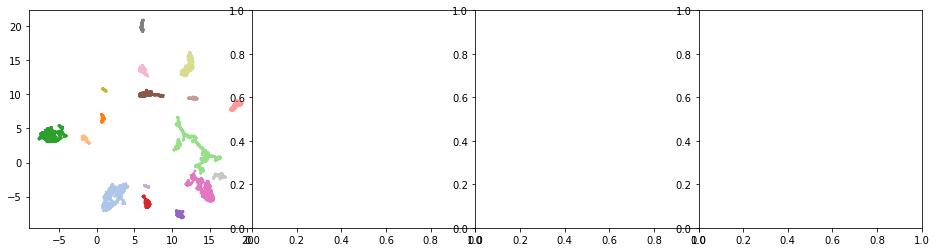

In [14]:
results = spacial_clustering(normalized_spectra, include_spatial_info=True)
reduced_space, clustering, pred_colors, expected_colors, pred_coeffs, expected_coeffs, mse = results
titles = ['UMAP + dbscan', 'Resulting map', 'Predicted phases', 'Expected phases']

fig, axes = plt.subplots(figsize=(16, 4), ncols=4)
plt.subplots_adjust(wspace=0.)
colors = [plt.cm.tab20(c + 1) for c in clustering.labels_]
axes[0].scatter(reduced_space[:, 0], reduced_space[:, 1], c=colors, s=3)
axes[1].scatter(pts[:, 1], -pts[:, 0], c=colors, s=1)
axes[2].scatter(pts[:, 1], -pts[:, 0], c=pred_colors, s=1)
axes[3].scatter(pts[:, 1], -pts[:, 0], c=expected_colors, s=1)

for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=16)

In [ ]:
results = spacial_clustering(normalized_spectra, include_spatial_info=False)
reduced_space, clustering, pred_colors, expected_colors, pred_coeffs, expected_coeffs, mse2 = results
titles = ['UMAP + dbscan', 'Resulting map', 'Predicted phases', 'Expected phases']

fig, axes = plt.subplots(figsize=(16, 4), ncols=4)
plt.subplots_adjust(wspace=0.)
colors = [plt.cm.tab20(c + 1) for c in clustering.labels_]
axes[0].scatter(reduced_space[:, 0], reduced_space[:, 1], c=colors, s=3)
axes[1].scatter(pts[:, 1], -pts[:, 0], c=colors, s=1)
axes[2].scatter(pts[:, 1], -pts[:, 0], c=pred_colors, s=1)
axes[3].scatter(pts[:, 1], -pts[:, 0], c=expected_colors, s=1)

for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=16)

In [ ]:
mse, mse2

In [11]:
#clustering = DBSCAN(eps=1, min_samples=1).fit(normalized_spectra)
clustering = KMeans(n_clusters=5, random_state=42).fit(normalized_spectra)
#clustering = DBSCAN(eps=1.2, min_samples=1).fit(spatial_joint)
#clustering = KMeans(n_clusters=5, random_state=42).fit(spatial_joint)

In [12]:
img = np.ones((Fe_xanes.shape[1], Fe_xanes.shape[2])) * -1
for i, (x, y) in enumerate(list(normalized_spectra_dict.keys())):
    img[x, y] = clustering.labels_[i]
print(np.unique(clustering.labels_))

[0 1 2 3 4]


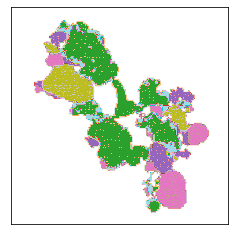

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
alpha = np.array(1 - (img == -1), dtype=float)
ax.imshow(img, extent=[0, 1, 0, 1], cmap=plt.cm.tab20, alpha=alpha)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [13]:
from skimage import filters

In [14]:
Fe_xanes.shape

(54, 155, 160)

In [15]:
norm_img = np.ones((155, 160, 54)) * -1
for i, (x, y) in enumerate(list(normalized_spectra_dict.keys())):
    norm_img[x, y, :] = normalized_spectra[i]

(155, 160, 54)


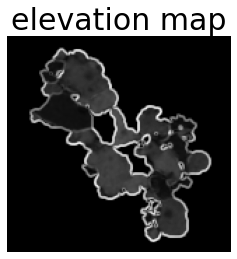

In [453]:
elevation_map = filters.sobel(norm_img)
print(elevation_map.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(elevation_map[:, :, 20], cmap=plt.cm.gray)
ax.set_title('elevation map', fontsize=30)
ax.axis('off')
plt.show()

In [465]:
dist_from_norm = np.zeros((norm_img.shape[0], norm_img.shape[1]))

In [475]:
#avg_spectrum = np.average(normalized_spectra, axis=0)
i = 8
print(data_columns[i])
avg_spectrum = Refs[i]
for x in range(norm_img.shape[0]):
    for y in range(norm_img.shape[1]):
        #dist_from_norm[x, y] = wasserstein_distance(avg_spectrum, norm_img[x, y])
        dist_from_norm[x, y] = r2_score(avg_spectrum, norm_img[x, y])

Maghemite


(-0.5, 159.5, 154.5, -0.5)

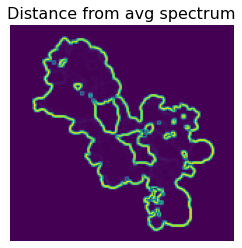

In [476]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(filters.sobel(dist_from_norm))
ax.set_title('Distance from avg spectrum', fontsize=16)
ax.axis('off')

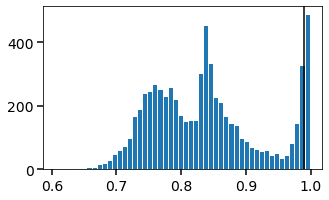

In [477]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(np.array(dist_from_norm[dist_from_norm > 0.]).reshape(-1), bins=50, ec='w')
ax.axvline(0.99, 0, plt.ylim()[1], c='k')
ax.tick_params(length=6, width=1.5, labelsize=14)

(-0.5, 159.5, 154.5, -0.5)

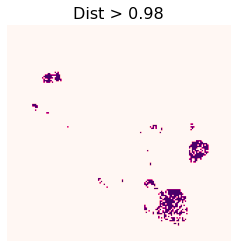

In [478]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(dist_from_norm > 0.99, cmap=plt.cm.RdPu)
ax.set_title('Dist > 0.98', fontsize=16)
ax.axis('off')

In [479]:
norm_img.shape

(155, 160, 54)

In [480]:
i = 7
print(data_columns[i])
template = np.zeros_like(norm_img)
#for (x, y) in normalized_spectra_dict.keys():
#    template[x, y] = Refs[i]
template[:, :, :] = Refs[i]

Hematite


([], [])

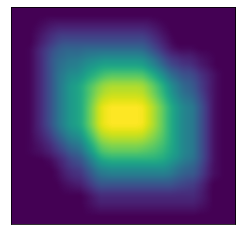

In [481]:
cross_corr = correlate(norm_img, template)
plt.imshow(cross_corr[:, :, 54])
plt.xticks([])
plt.yticks([])

In [136]:
import cv2 as cv

In [137]:
norm_img = np.zeros((155, 160, 54))
for i, (x, y) in enumerate(list(normalized_spectra_dict.keys())):
    norm_img[x, y, :] = normalized_spectra[i]

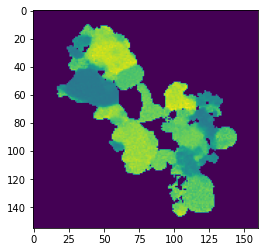

In [138]:
plt.imshow(norm_img[:, :, 20])

In [394]:
template = np.zeros_like(norm_img)
template[:, :, :] = Refs[i]

In [395]:
norm_img[:, :, 20].shape, template[:, :, 20].shape

((155, 160), (155, 160))

In [396]:
reference_img = norm_img[:, :, 20]
temp = template[:5, :5, 20]
w, h = temp.shape[0], temp.shape[1]

In [390]:
maxv = np.max(reference_img)
reference_img = reference_img / maxv
temp = temp / maxv

reference_img = np.array(reference_img * 255, dtype=np.uint8)
temp = np.array(temp * 255, dtype=np.uint8)

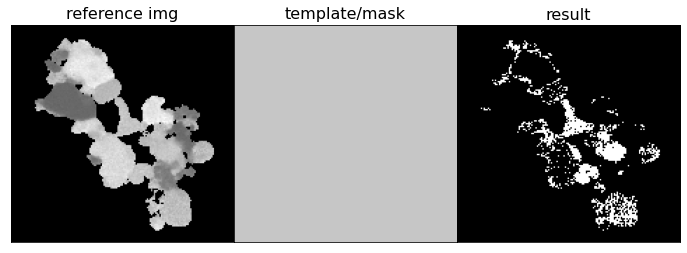

In [391]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)
plt.subplots_adjust(wspace=0)
axes[0].imshow(reference_img, cmap=plt.cm.gray, aspect='auto')
axes[1].set_facecolor(plt.cm.gray(temp[0, 0]))
tol = 10
axes[2].imshow(np.logical_and(reference_img <= temp[0, 0] + tol,
                              reference_img >= temp[0, 0] - tol),
               cmap=plt.cm.gray)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
titles = ['reference img', 'template/mask', 'result']
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=16)

Hematite


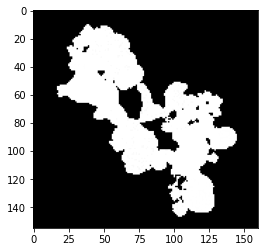

In [392]:
# variance-weighted sum
i = 7
print(data_columns[i])
matches = []

tol = 20
for e in range(len(energy)):
    reference_img = norm_img[:, :, e]
    mask = Refs[i, e]
    
    maxv = np.max(reference_img)
    reference_img = reference_img / maxv
    mask = mask / maxv

    reference_img = np.array(reference_img * 255, dtype=np.uint8)
    temp = np.array(temp * 255, dtype=np.uint8)
    
    matched = np.logical_and(reference_img <= mask + tol, reference_img >= mask - tol)
    matches.append(matched)
matches = np.array(matches)
combined_result = np.sum(matches * np.var(Refs, axis=0).reshape(-1, 1, 1), axis=0)

plt.imshow(1 - combined_result, cmap=plt.cm.gray)

Hematite


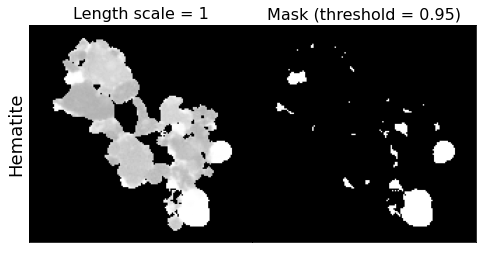

In [464]:
# variance-weighted sum per pixel
i = 7
print(data_columns[i])
matches = []

for e in range(len(energy)):
    reference_img = norm_img[:, :, e]
    mask = Refs[i, e]
    
    maxv = np.max(reference_img)
    reference_img = reference_img / maxv
    mask = mask / maxv

    reference_img = np.array(reference_img * 255, dtype=np.uint8)
    mask = np.array(mask * 255, dtype=np.uint8)
    
    res = cv.matchTemplate(reference_img, mask, cv.TM_SQDIFF)
    matches.append(res)

matches = np.array(matches)
combined_result = np.sum(matches * np.var(Refs, axis=0).reshape(-1, 1, 1), axis=0)
combined_result = combined_result / np.max(combined_result)

threshold = 0.95

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.subplots_adjust(wspace=0)
axes[0].imshow(1 - combined_result, cmap=plt.cm.gray, aspect='auto')
axes[1].imshow((1 - combined_result) > threshold, cmap=plt.cm.gray, aspect='auto')
axes[0].set_ylabel(data_columns[i], fontsize=18)
axes[0].set_title(f'Length scale = 1', fontsize=16)
axes[1].set_title(f'Mask (threshold = {threshold})', fontsize=16)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Stainless Steel


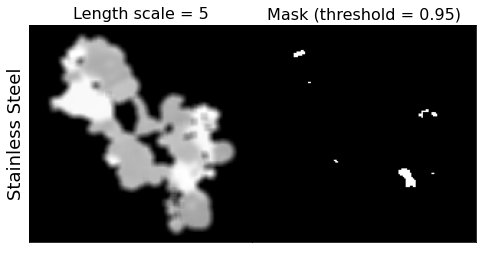

Fe3P


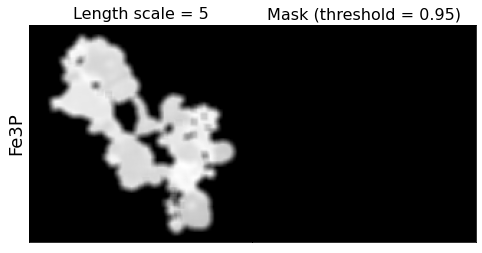

Pyrite


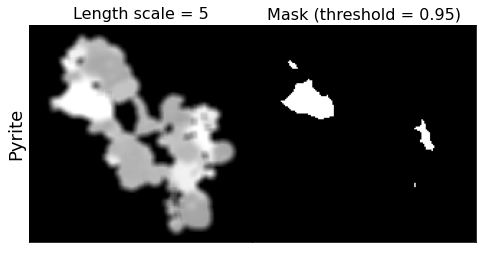

LiFe(II)PO4


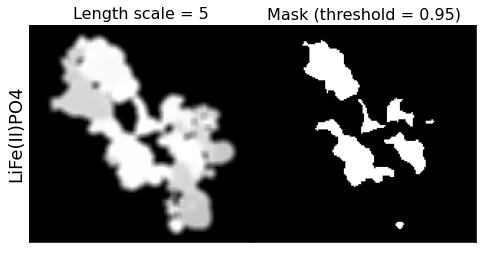

Magnetite


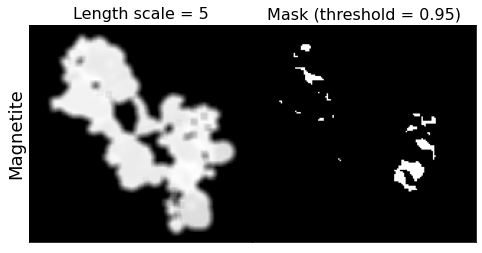

Fe(III)SO4


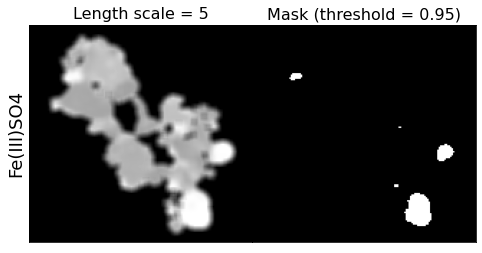

Fe(III)PO4


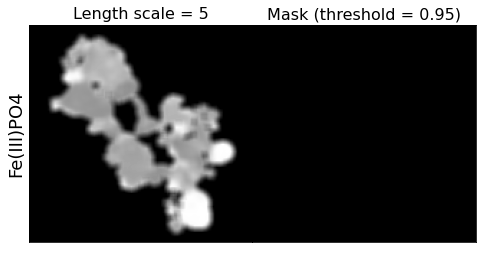

Hematite


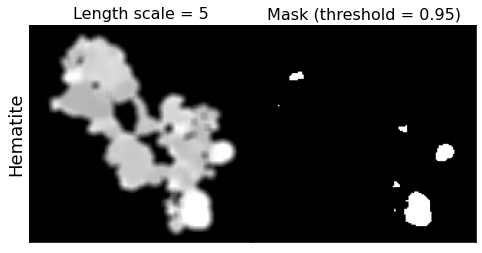

Maghemite


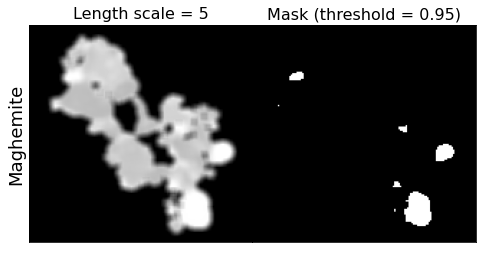

Goethite


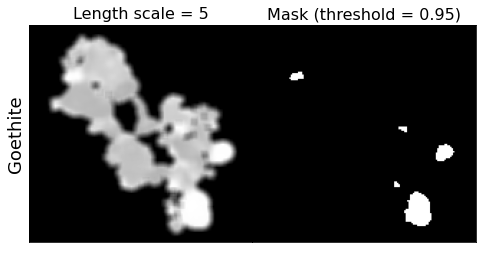

HFO


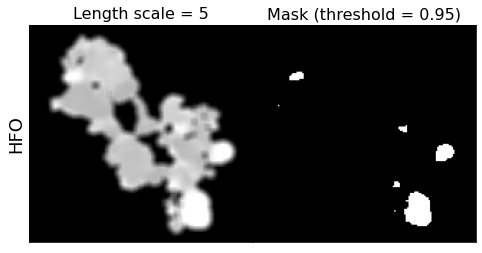

In [451]:
# variance-weighted sum using filter with length scale
max_correlations = np.zeros(11)
sum_correlations = np.zeros(11)

for i in range(11):
    matches = []

    width = 5  # substitute with autocorrelation length scale

    tol = 20
    for e in range(len(energy)):
        reference_img = norm_img[:, :, e]
        mask = Refs[i, e]

        maxv = np.max(reference_img)
        reference_img = reference_img / maxv
        mask = mask / maxv

        reference_img = np.array(reference_img * 255, dtype=np.uint8)
        mask = np.array(mask * 255, dtype=np.uint8)
        mask = np.tile(mask, (width, width))

        res = cv.matchTemplate(reference_img, mask, cv.TM_SQDIFF)
        matches.append(res)

    matches = np.array(matches)
    combined_result = np.sum(matches * np.var(Refs, axis=0).reshape(-1, 1, 1), axis=0)
    max_correlations[i] = np.max(combined_result)
    sum_correlations[i] = np.sum(combined_result)
    combined_result = combined_result / np.max(combined_result)

    threshold = 0.95

    fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
    plt.subplots_adjust(wspace=0)
    axes[0].imshow(1 - combined_result, cmap=plt.cm.gray, aspect='auto')
    axes[1].imshow((1 - combined_result) > threshold, cmap=plt.cm.gray, aspect='auto')
    axes[0].set_ylabel(data_columns[i], fontsize=18)
    axes[0].set_title(f'Length scale = {width}', fontsize=16)
    axes[1].set_title(f'Mask (threshold = {threshold})', fontsize=16)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

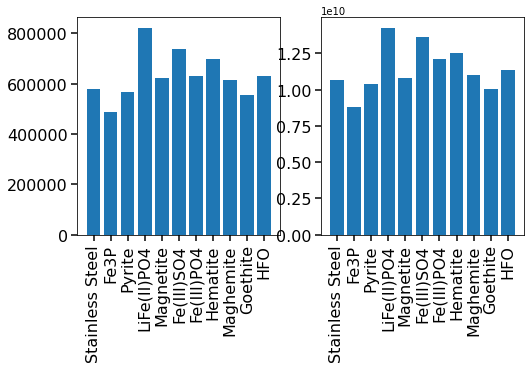

In [452]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

axes[0].bar(np.arange(11), max_correlations)
axes[1].bar(np.arange(11), sum_correlations)
for ax in axes:
    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(data_columns, rotation=90)
    ax.tick_params(length=6, width=1.5, labelsize=16)
    #ax.set_yticks([])

In [494]:
from skimage.feature import match_template

Hematite
(155, 160, 54) (5, 5, 54)
(155, 160) (5, 5)
(151, 156)


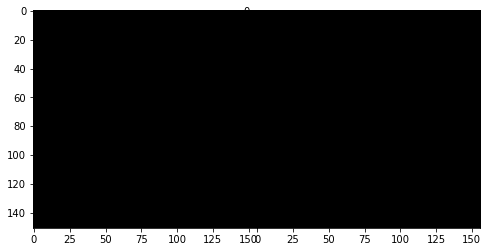

In [519]:
# using entire spectrum
i = 7
print(data_columns[i])
width = 5
matches = []

reference_img = norm_img.copy()
mask = Refs[i]
    
maxv = np.max(reference_img)
reference_img = reference_img / maxv
mask = mask / maxv

reference_img = np.array(reference_img * 255, dtype=np.uint8)
mask = np.array(mask * 255, dtype=np.uint8)
mask = np.tile(mask, (width, width, 1))

print(reference_img.shape, mask.shape)
print(reference_img[:, :, 20].shape, mask[:, :, 20].shape)
match = match_template(reference_img[:, :, 20], mask[:, :, 20])
#match = cv.matchTemplate(reference_img[:,:,20], mask[:, :, 20], cv.TM_SQDIFF)

print(match.shape)

combined_result = np.array(match)
#combined_result = combined_result / np.max(combined_result)

threshold = 0.95

fig, axes = plt.subplots(figsize=(8, 4), ncols=2)
plt.subplots_adjust(wspace=0)
axes[0].imshow(1 - combined_result, cmap=plt.cm.gray, aspect='auto')
axes[1].imshow((1 - combined_result) > threshold, cmap=plt.cm.gray, aspect='auto')
plt.show()

In [521]:
np.max(combined_result)

0.0

In [498]:
from skimage import data

In [499]:
image = data.coins()
coin = image[170:220, 75:130]

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

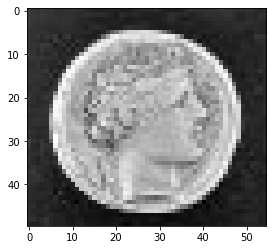

In [502]:
plt.imshow(coin, cmap=plt.cm.gray)

In [77]:
from keras.datasets import mnist

In [338]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [339]:
x_train[0, 8, 15]

182

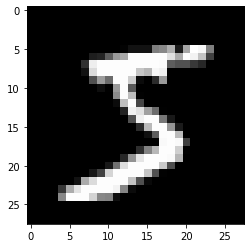

In [340]:
plt.imshow(x_train[0], cmap=plt.cm.gray)

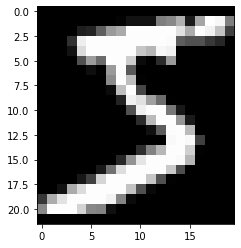

In [341]:
plt.imshow(x_train[0, 4:26, 4:24], cmap=plt.cm.gray)

In [351]:
template = x_train[0, 4:26, 4:24]
w, h = template.shape[0], template.shape[1]

In [352]:
template = np.array(template, dtype=np.uint8)
rimg = np.array(x_train[0], dtype=np.uint8)

In [353]:
res = cv.matchTemplate(rimg, template, cv.TM_SQDIFF)

In [118]:
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
min_val, max_val, min_loc, max_loc

(0.0, 9300458.0, (4, 4), (8, 6))

In [121]:
threshold = 9300450
loc = np.where(res >= threshold)

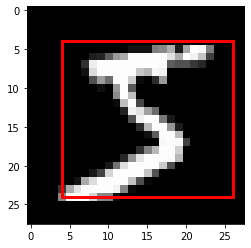

In [133]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(x_train[0, :, :], cmap=plt.cm.gray)
rect = mpl.patches.Rectangle(min_loc, w, h, fill=False, linewidth=3, edgecolor='r')
ax.add_patch(rect)

# Group Refs by spectral similarity

It takes 6 PCs to explain
99% variance.


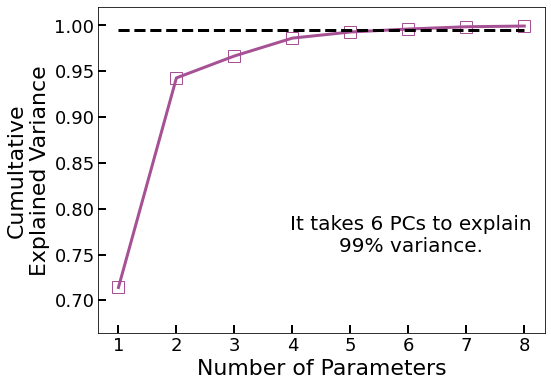

In [10]:
n_components = make_scree_plot(Refs, n=8, threshold=0.995, show_first_PC=False)
plt.show()

pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(Refs)

In [21]:
reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=1.5, min_dist=0.5)
pcs = np.array(pca_components.copy(), dtype=float)

reduced_space = reducer.fit_transform(pcs)
clusterizer = DBSCAN(eps=0.6, min_samples=1).fit(reduced_space)

ValueError: n_neighbors must be greater than 1

In [ ]:
np.unique(clusterizer.labels_)

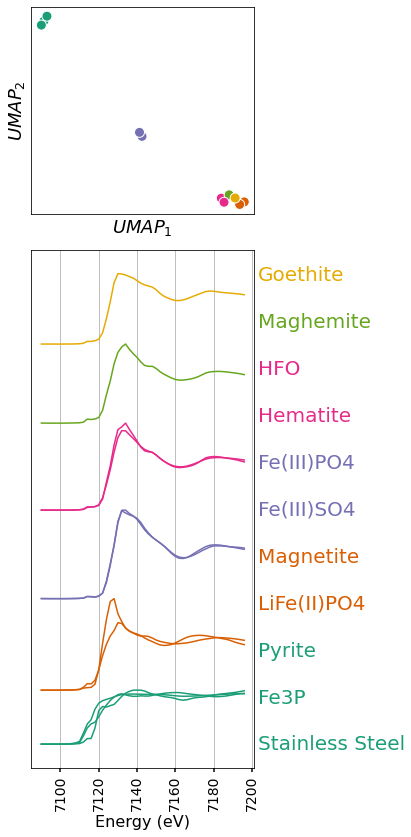

In [22]:
fig = plt.figure(figsize=(4, 14))
spec = fig.add_gridspec(nrows=2, height_ratios=[4 / 14, 10 / 14])
axes = [fig.add_subplot(spec[j]) for j in range(2)]
plt.subplots_adjust(hspace=0.1)

colors = [plt.cm.Dark2(c) for c in clusterizer.labels_]
axes[0].scatter(reduced_space[:, 1], reduced_space[:, 0], marker='o', c=colors, edgecolor='w', s=100)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('$UMAP_1$', fontsize=18)
axes[0].set_ylabel('$UMAP_2$', fontsize=18)

ref_clusters = [[] for i in range(len(np.unique(clusterizer.labels_)))]
for i, r in enumerate(Refs):
    ref_clusters[clusterizer.labels_[i]].append(r)
maxes = [np.max(c) for c in ref_clusters]
maxes.insert(0, 0)
dys = [np.sum(maxes[:i + 1]) for i in range(len(maxes) - 1)]
cluster_labels = [[] for i in range(len(np.unique(clusterizer.labels_)))]

ax = axes[1]
for i, r in enumerate(Refs):
    c = clusterizer.labels_[i]
    cluster_labels[c].append(data_columns[i])
    if c == 0:
        dy = 0
    else:
        dy = dys[c]
    ax.plot(energy, r + dy, color=plt.cm.Dark2(c))
ax.set_yticks([])
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.tick_params(length=4, width=1.5, labelsize=14, rotation=90)
ax.grid()
ax.set_xlabel('Energy (eV)', fontsize=16)

count = 0
for c, cluster_list in enumerate(cluster_labels):
    for i, label in enumerate(cluster_list):
        ax.text(energy[-1] + 7, count * 0.95 - 0.2, label,
                color=plt.cm.Dark2(c), fontsize=20, va='bottom')
        count += 1

In [60]:
grouped_Refs = np.array([np.average(c, axis=0) for c in ref_clusters])
group_names = np.flip(['geo/magh', 'HFO/hem', 'salts', 'magn', 'LFP', 'pyr', 'SS/Fe3P'])
grouped_Refs.shape

(7, 54)

# Step 3. Cluster Spectra
# PIPELINE: PCA --> UMAP --> dbscan --> clustering

In [14]:
utils = reload(utils)
from utils import *

1 -> 7
3 -> 12
0 -> 13
4 -> 6
2 -> 19


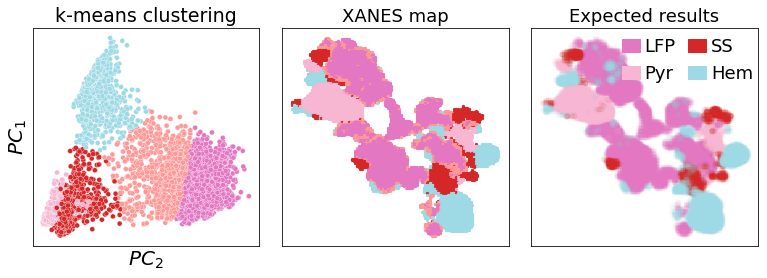

In [15]:
two_dimensional_clustering(normalized_spectra, normalized_spectra_dict,
                           expected_results, method='PCA', clustering='k-means',
                           translation=1, n_clusters=5, data_description='full_spectra')

Couldn't cluster 0 points
0 -> 12
3 -> 13
2 -> 6
1 -> 19


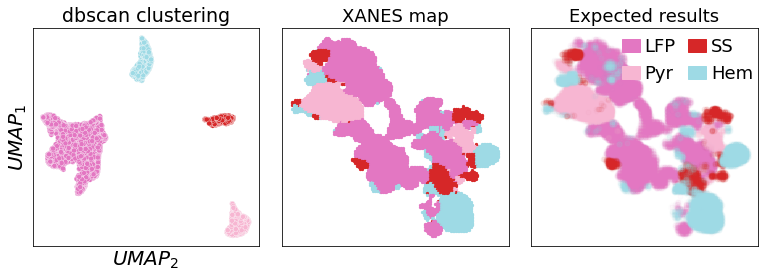

In [16]:
two_dimensional_clustering(normalized_spectra, normalized_spectra_dict,
                           expected_results, method='UMAP', clustering='dbscan',
                           translation=2, data_description='full_spectra')

In [185]:
utils = reload(utils)
from utils import *

It takes 6 PCs to explain
97% variance.
0 -> 12
3 -> 13
2 -> 6
1 -> 19


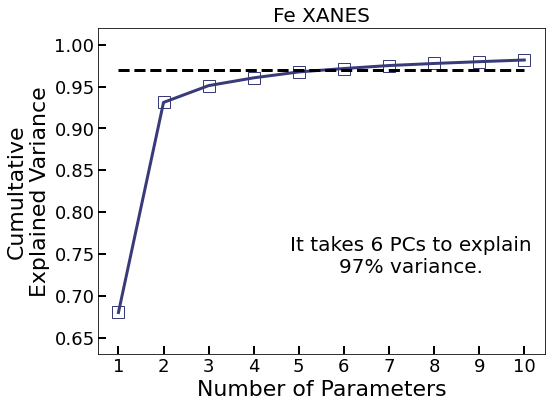

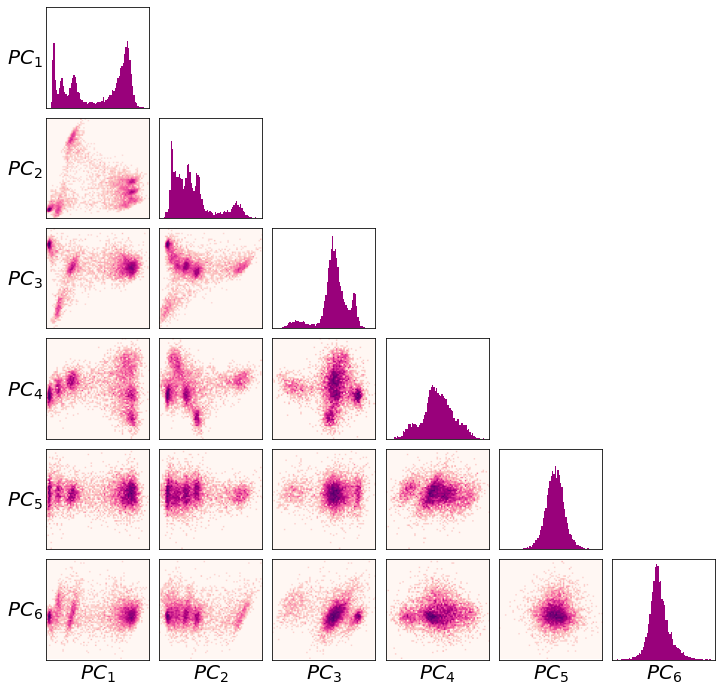

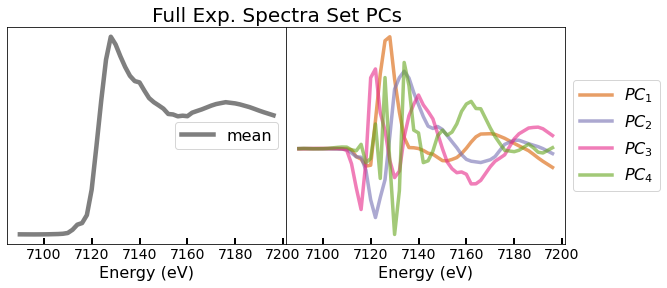

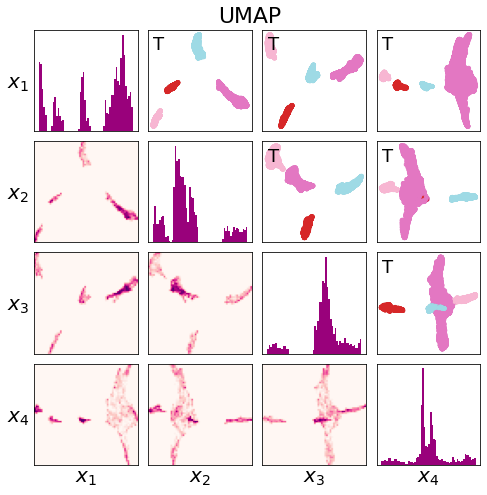

In [24]:
# PCA
n_components = make_scree_plot(normalized_spectra, n=10, c=0, threshold=0.97, show_first_PC=False)
plt.title('Fe XANES', fontsize=20)
plt.savefig('Figures/full_spectra_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(normalized_spectra, n_components, bins=70,
                                             cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8))
plt.savefig('Figures/full_spectra_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

show_PCs(energy, pca, n=4)
plt.suptitle('Full Exp. Spectra Set PCs', fontsize=20, y=0.95)
plt.savefig('Figures/full_spectra_first_PCs.png', dpi=600, bbox_inches='tight')

# UMAP & dbscan
color_labels, codemap, dbscan_clustering = make_UMAP_plot(pca_components, normalized_spectra_dict, eps=1.0,
                                                          n_neighbors=30, min_dist=0, dimension=4, bins=60,
                                                          cmap=plt.cm.RdPu, c=plt.cm.RdPu(0.8),
                                                          translation=2)
plt.savefig('Figures/full_spectra_UMAP.png', dpi=600, bbox_inches='tight')

# Final clusters
#plot_color_code_map(plt.subplots(figsize=(5, 5)), normalized_spectra_dict, color_labels)
#plt.savefig('Figures/full_spectra_cluster_map.png', dpi=600, bbox_inches='tight')

In [25]:
print(len(np.unique(dbscan_clustering.labels_)), len(np.unique(color_labels)))

4 4


# Step 4. LCF

### First find cluster averages

Diversity of UMAP clusters:
0.09062498333533216
99
Diversity of random clusters:
6.335282248537081e-05 +/- 3.44784675191499e-05
p-val = 0.0
We reject the null hypothesis, so the diversity of the UMAP clusters is statisitcally significant.


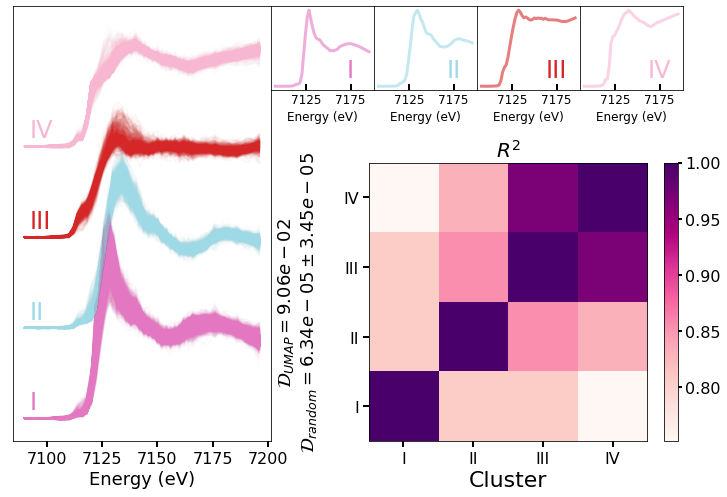

In [26]:
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
avg_spectra = np.array(list(cluster_avgs.values()))
diversity, xbar, s = find_diversity(avg_spectra, dbscan_clustering, normalized_spectra)

n_clusters = len(avg_spectra)
labels = ['I', 'II', 'III', 'IV']

fig = plt.figure(figsize=(12, 8))
width_ratios = np.ones(1 + n_clusters)
width_ratios[1:] = width_ratios[1:] / 2.5

spec = fig.add_gridspec(nrows=2, ncols=1 + n_clusters,
                        height_ratios=[0.3, 1.], width_ratios=width_ratios)
plt.subplots_adjust(hspace=0.4, wspace=0.)
subplts = [fig.add_subplot(spec[:, 0]), fig.add_subplot(spec[1, 1:])]
axes = [fig.add_subplot(spec[0, 1 + i]) for i in range(n_clusters)]
   
plot_spaghetti_by_cluster(subplts[0], energy, normalized_spectra, avg_spectra,
                          color_labels, labels, codemap)
plot_cluster_avgs((fig, axes), energy, cluster_avgs, codemap, linewidth=3)

metric = '$R^2$'
sim_matrix = get_similarity_mtx(avg_spectra, metric=metric)
metric = '$ R^2 $'
plot_corr_matx(subplts[1], sim_matrix, labels, metric, rot=0)

ylabel = '$\mathcal{D}_{UMAP} = ' + f'{diversity:.2e}$\n'
ylabel += '$\mathcal{D}_{random} = ' + f'{xbar:.2e} \pm {s:.2e}$\n'
subplts[1].set_ylabel(ylabel, fontsize=18)
subplts[1].set_xlabel('Cluster', fontsize=22)

plt.savefig('Figures/full_spectra_cluster_averages.png', dpi=600, bbox_inches='tight')

# Reference Validation

It takes 4 PCs to explain
98% variance.


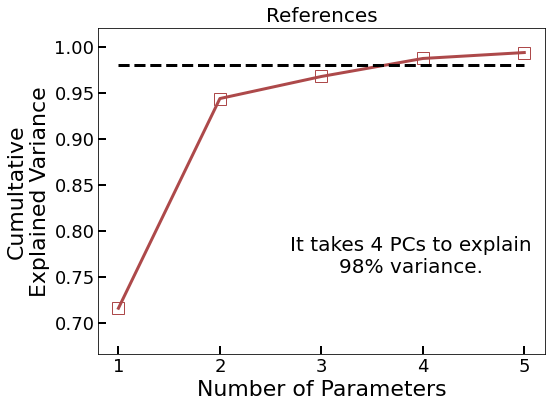

In [50]:
make_scree_plot(Refs, threshold=.98, show_first_PC=False, c=13)
plt.title('References', fontsize=20)
plt.savefig('Figures/refs_scree.png', dpi=400, bbox_inches='tight')

In [13]:
def lasso_cv(targets, basis, alpha=0.0005, scale=0):
    coeffs = []
    for target in targets:
        lasso = Lasso(alpha=alpha, max_iter=50000, tol=0.0001 + scale * 0.005)
        lasso.fit(basis, target)
        coeffs.append(lasso.coef_)
    return scale_coeffs_to_add_to_one(coeffs)

In [101]:
alphas = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
          0.001, 0.003, 0.005, 0.01]
noises = [0.00, 0.02, 0.03, 0.04]

Scores = []
for scale in noises:
    print(f'scale = {scale}')
    kwargs = {'N': 500, 'scale': scale, 'dropout': 0.9}
    x_test, y_test = generate_linear_combos(Refs, **kwargs)
    scores = []
    for alpha in alphas:
        print(f'alpha = {alpha}')
        y_pred = lasso_cv(x_test, Refs.T, alpha=alpha, scale=scale)
        score = mean_squared_error(y_test, y_pred)
        scores.append(score)
    Scores.append(scores)
    print()
Scores = np.array(Scores)

scale = 0.0
alpha = 5e-05
alpha = 0.0001
alpha = 0.0002
alpha = 0.0003
alpha = 0.0004
alpha = 0.0005
alpha = 0.0006
alpha = 0.0007
alpha = 0.001
alpha = 0.003
alpha = 0.005
alpha = 0.01

scale = 0.02
alpha = 5e-05
alpha = 0.0001
alpha = 0.0002
alpha = 0.0003
alpha = 0.0004
alpha = 0.0005
alpha = 0.0006
alpha = 0.0007
alpha = 0.001
alpha = 0.003
alpha = 0.005
alpha = 0.01

scale = 0.03
alpha = 5e-05
alpha = 0.0001
alpha = 0.0002
alpha = 0.0003
alpha = 0.0004
alpha = 0.0005
alpha = 0.0006
alpha = 0.0007
alpha = 0.001
alpha = 0.003
alpha = 0.005
alpha = 0.01

scale = 0.04
alpha = 5e-05
alpha = 0.0001
alpha = 0.0002
alpha = 0.0003
alpha = 0.0004
alpha = 0.0005
alpha = 0.0006
alpha = 0.0007
alpha = 0.001
alpha = 0.003
alpha = 0.005
alpha = 0.01



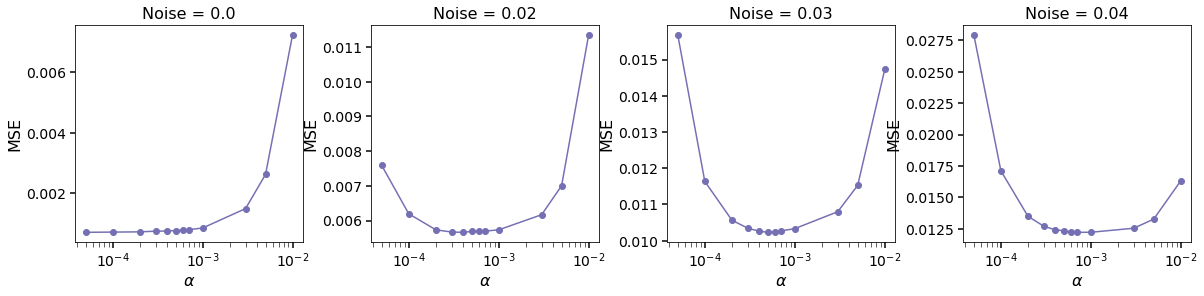

In [103]:
fig, axes = plt.subplots(figsize=(5 * len(noises), 4), ncols=len(noises))
plt.subplots_adjust(wspace=0.3)

for i, ax in enumerate(axes):
    ax.plot(alphas, Scores[i], marker='o', color=plt.cm.Dark2(2))
    ax.set_xscale('log')
    ax.tick_params(length=5.5, width=1.5, labelsize=14)
    ax.tick_params(length=4.5, which='minor')
    ax.set_xlabel('$\\alpha$', fontsize=16)
    ax.set_ylabel('MSE', fontsize=16)
    ax.set_title(f'Noise = {noises[i]}', fontsize=16)

plt.show()

In [51]:
def get_coeffs_using_lin_model(basis, target, method='nnls'):
    if method.lower() == 'nnls':
        coeffs = nnls(basis, target)[0]
    elif method.lower() == 'lasso':
        lasso = Lasso(alpha=0.0006, max_iter=3000)
        lasso.fit(basis, target)
        coeffs = lasso.coef_
    elif method.lower() == 'enet':
        cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
        model = ElasticNetCV(cv=cv, random_state=42, max_iter=3000)
        model.fit(basis, target)
        coeffs = model.coef_
    else:
        m = basis.T.shape[0]
        coeffs_0 = np.ones((m)) / m  # uniform prior
        bounds = np.zeros((m, 2))
        bounds[:, 1] = 1
        result = minimize(objective_function, coeffs_0,
                          args=(basis.T, target, 0.0006, 10),
                          bounds=bounds, method='SLSQP')
        #print(result['success'])
        coeffs = np.array([result.x])[0]
    return coeffs

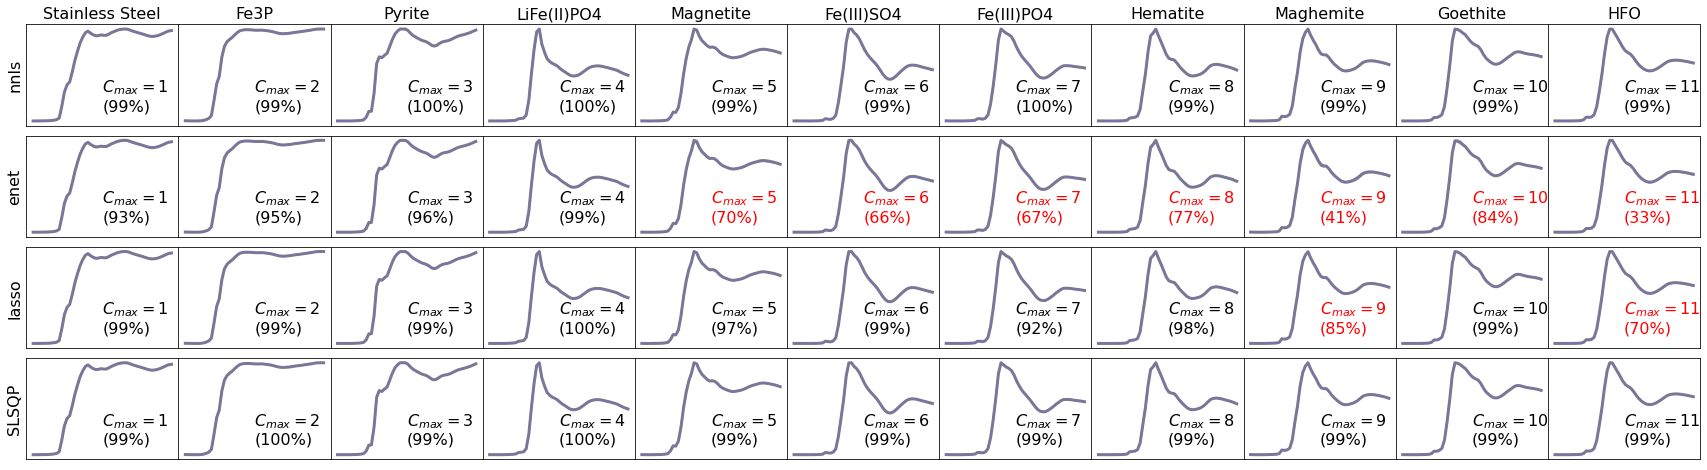

In [52]:
targets = Refs
models = ['nnls', 'enet', 'lasso', 'SLSQP']

fig, ax_list = plt.subplots(figsize=(30, 2 * len(models)),
                            ncols=len(targets), nrows=len(models))
plt.subplots_adjust(wspace=0, hspace=0.1)

for i, method in enumerate(models):
    axes = ax_list[i]
    for idx in range(len(targets)):
        coeffs = get_coeffs_using_lin_model(Refs.T, targets[idx], method=method)
        coeffs = scale_coeffs_to_add_to_one([coeffs])[0]
        recon = Refs.T @ coeffs
        recon = recon.reshape(-1)
        axes[idx].plot(energy, targets[idx], color='gray', linewidth=3)
        axes[idx].plot(energy, recon, color=plt.cm.Dark2(2), linewidth=2, alpha=0.7)
        if np.max(coeffs) < 0.9 or np.argmax(coeffs) != idx:
            flag = True
        else:
            flag = False
        label_ax_with_score(axes[idx], targets[idx], recon,
                            np.argmax(coeffs) + 1, np.max(coeffs), flag=flag)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    axes[0].set_ylabel(method, fontsize=16)
    if i == 0:
        for idx, ax in enumerate(axes):
            ax.set_title(data_columns[idx], fontsize=16)

In [53]:
kwargs = {'N': 500, 'scale': 0.03, 'dropout': 0.9}
test_x, test_y = generate_linear_combos(Refs, **kwargs)
targets = test_x

r_scores = []
c_scores = []
c_sums = []
y_preds = []

methods = ['LASSO', 'SLSQP']

for method in methods:
    r_score = []
    c_score = []
    c_sum = []
    y_pred = []
    
    for idx in range(len(targets)):
        coeffs = get_coeffs_using_lin_model(Refs.T, targets[idx], method=method)
        c_sum.append(np.sum(coeffs))
        
        #coeffs = scale_coeffs_to_add_to_one([coeffs])[0]
        y_pred.append(coeffs)
        recon = Refs.T @ coeffs

        r_score.append(mean_squared_error(recon.reshape(-1), test_x[i]))
        c_score.append(mean_squared_error(coeffs, test_y[i]))
    
    y_preds.append(y_pred)
    r_scores.append(r_score)
    c_scores.append(c_score)
    c_sums.append(c_sum)
    
y_preds = np.array(y_preds)

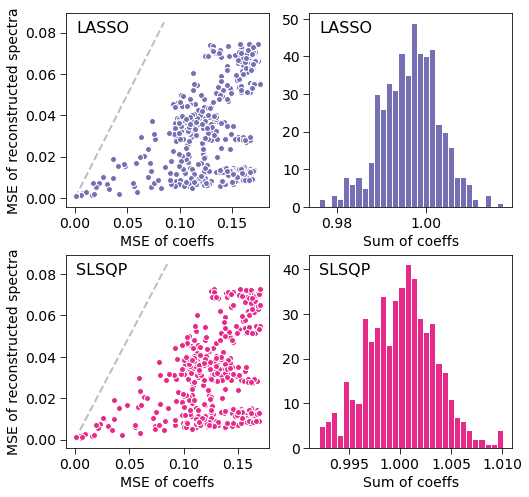

In [54]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=2)
plt.subplots_adjust(hspace=0.25)
for i in range(2):
    axes[i, 0].plot([0, 0.085], [0, 0.085], '--', c=plt.cm.tab10(7), alpha=0.5, linewidth=2)
    axes[i, 0].plot(c_scores[i], r_scores[i], marker='o', markeredgecolor='w', linestyle='',
                    color=plt.cm.Dark2(2 + i))
    axes[i, 1].hist(c_sums[i], color=plt.cm.Dark2(2 + i), edgecolor='w', bins=30)
    
    axes[i, 0].set_xlabel('MSE of coeffs', fontsize=14)
    axes[i, 0].set_ylabel('MSE of reconstructed spectra', fontsize=14)
    axes[i, 1].set_xlabel('Sum of coeffs', fontsize=14)
    
    for ax in axes[i]:
        ax.tick_params(length=6, labelsize=14)
        ax.text(0.05, 0.9, methods[i], transform=ax.transAxes, fontsize=16)
plt.show()

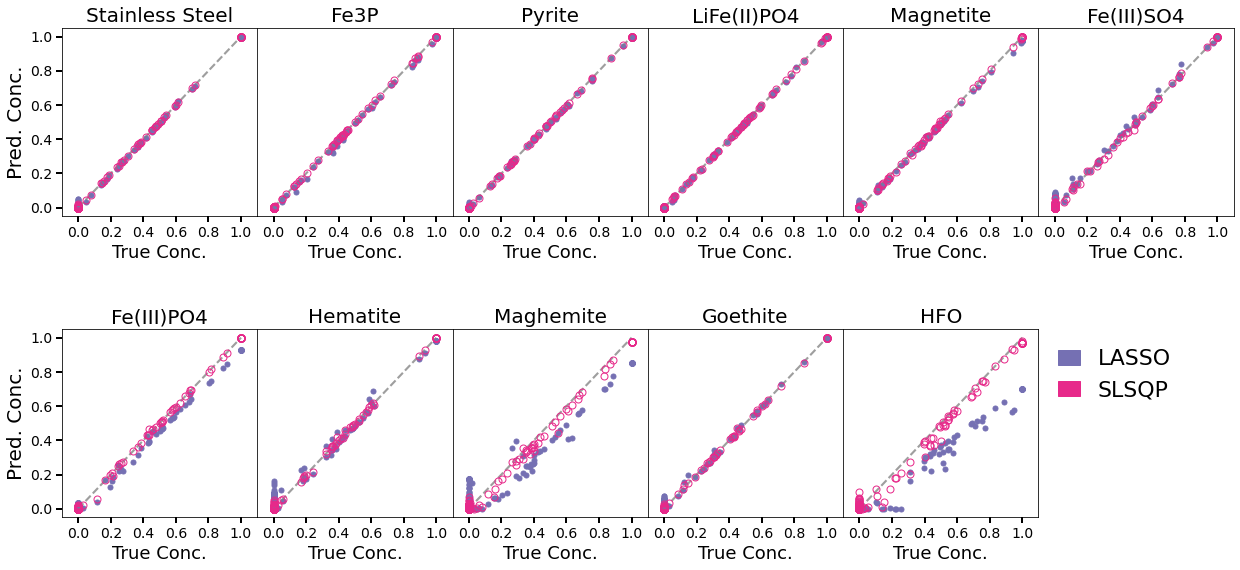

In [103]:
N = len(Refs)
ncols = 6
nrows = 2
fig, axes = plt.subplots(figsize=(3.5 * ncols, 4.5 * nrows),
                         ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0., hspace=0.6)

for m, method in enumerate(methods):
    y_pred = y_preds[m]
    for i, j in itertools.product(range(nrows), range(ncols)):
        ax = axes[i, j]
        idx = i * ncols + j
        if idx < N:
            ax.plot([0, 1], [0, 1], '--', c=plt.cm.tab10(7), alpha=0.5, linewidth=2)
            if m == 0:
                ax.plot(test_y[:, idx], y_pred[:, idx], 'o', c=plt.cm.Dark2(2 + m), markersize=5)
            else:
                ax.plot(test_y[:, idx], y_pred[:, idx], 'o', c=plt.cm.Dark2(2 + m), markersize=7,
                        fillstyle='none', linewidth=5)
            ax.tick_params(labelsize=14, width=2, length=6, direction='out')
            ax.set_xlim(-0.1, 1.1)
            ax.set_xticks(np.linspace(0, 1, 6))
            if j != 0:
                ax.set_yticks([])
            else:
                ax.set_yticks(np.linspace(0, 1, 6))
                ax.set_ylabel('Pred. Conc.', fontsize=20)
            ax.set_title(data_columns[idx], fontsize=20)
            ax.set_xlabel('True Conc.', fontsize=18)
        else:
            ax.axis('off')
            
patches = [mpatches.Patch(color=plt.cm.Dark2(2 + m), label=methods[m])
           for m in range(len(methods))]
leg = axes[1, -1].legend(handles=patches, fontsize=22, framealpha=0, handlelength=1., loc=2)

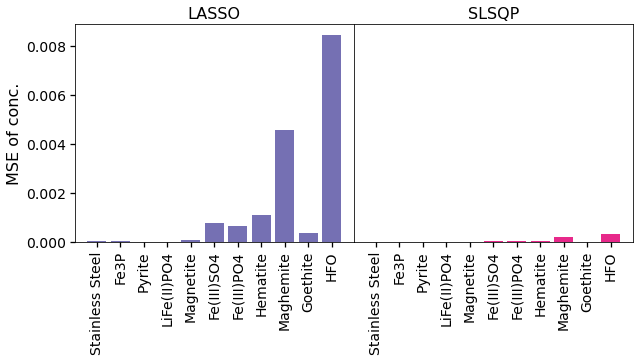

In [104]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
plt.subplots_adjust(wspace=0)
for m, method in enumerate(methods):
    ax = axes[m]
    errors = [mean_squared_error(y_preds[m][:, i], test_y[:, i]) for i in range(N)]
    ax.bar(np.arange(1, N + 1), errors, color=plt.cm.Dark2(2 + m))
    ax.set_xticks(np.arange(1, N + 1))
    ax.set_xticklabels(data_columns, rotation=90, fontsize=16)
    ax.tick_params(length=5, width=1.3, labelsize=14)
    if m == 0:
        ax.set_ylabel('MSE of conc.', fontsize=16)
    else:
        ax.set_yticks([])
    ax.set_title(method, fontsize=16)
    ax.set_ylim(0, axes[0].get_ylim()[1])
plt.show()

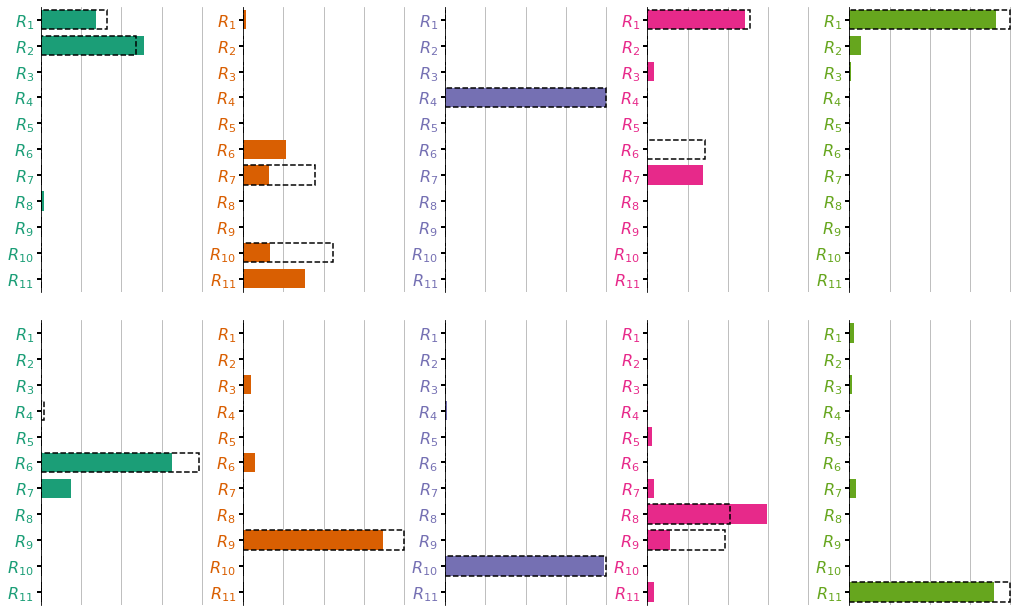

In [91]:
N = len(Refs)
labels = ['$R_{' + f'{N - c}' + '}$' for c in range(N)]
colors = [plt.cm.Dark2(c) for c in range(5)]
ncols = 5
nrows = 2
fig, axes = plt.subplots(figsize=(3.5 * 5, 0.5 * N * 2),
                         ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

y_pred = y_preds[1]

for i, j in itertools.product(range(nrows), range(ncols)):
    ax = axes[i, j]
    idx = i * ncols + j
    
    format_bar_axes(ax, N, labels)
    
    indices = np.arange(N)
    for k, tick in enumerate(ax.yaxis.get_ticklabels()):
        if k in N - 1 - indices:
            tick.set_color(colors[j])
    
    coeffs = np.arange(N)
    ax.barh(N - 1 - indices, y_pred[idx], height=0.75,
            color=colors[j], alpha=1, zorder=2)
    ax.barh(N - 1 - coeffs, test_y[idx], height=0.75,
            edgecolor='k', fill=False, linewidth=1.5, linestyle='--', zorder=2)

In [70]:
utils = reload(utils)
from utils import *

In [208]:
subset_size = 11
subset_indices, subsets, coeffs, scores = [], [], [], []
targets = Refs 
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], targets, subset_size)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

[ 0  1  2  3  4  5  6  7  8  9 10] 7.195125606429542e-10
[ 0  1  2  3  4  5  6  7  8  9 10] 6.962027732093645e-09
[ 0  1  2  3  4  5  6  7  8  9 10] 2.515870622943339e-09
[ 0  1  2  3  4  5  6  7  8  9 10] 2.521010067368934e-10
[ 0  1  2  3  4  5  6  7  8  9 10] 2.298103141118446e-08
[ 0  1  2  3  4  5  6  7  8  9 10] 9.575265025318913e-09
[ 0  1  2  3  4  5  6  7  8  9 10] 7.668987667130978e-11
[ 0  1  2  3  4  5  6  7  8  9 10] 7.477484964546477e-09
[ 0  1  2  3  4  5  6  7  8  9 10] 1.3138569121551313e-09
[ 0  1  2  3  4  5  6  7  8  9 10] 4.937520281522723e-09
[ 0  1  2  3  4  5  6  7  8  9 10] 7.950816871549193e-08


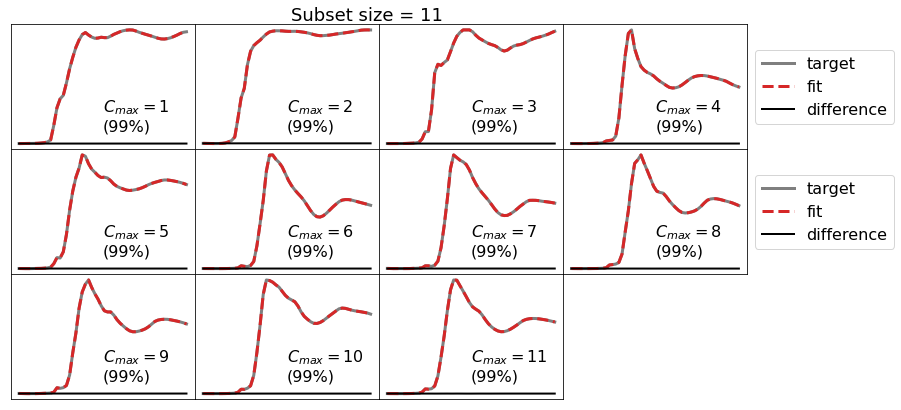

In [209]:
plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Refs_dict,
                verbose=True, ncols=4, c=3)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

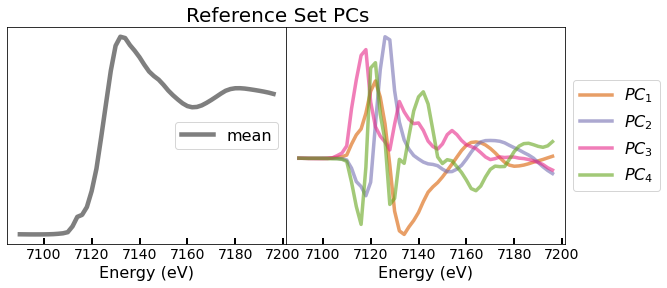

In [125]:
n_components = 5
pca = PCA(n_components=n_components)
pca_components = pca.fit_transform(Refs)

show_PCs(energy, pca, n=4)
plt.suptitle('Reference Set PCs', fontsize=20, y=0.95)
plt.savefig('Figures/Refs_first_PCs.png', dpi=600, bbox_inches='tight')

# LCF algorithm 
Test case to demonstrate flags

In [83]:
utils = reload(utils)
from utils import *

In [84]:
subset_size = 4
keys = ['subset_indices', 'subset', 'coeffs', 'score']

real_coeffs = [[0.5, 0.5], [0.25, 0.75], [0.1, 0.9]]
real_indices = [[0, 3], [0, 4], [1, 2]]
targets = [real_coeffs[0][0] * Refs[real_indices[0][0]] + \
               real_coeffs[0][1] * Refs[real_indices[0][1]],
           real_coeffs[1][0] * Refs[real_indices[1][0]] + \
               real_coeffs[1][1] * Refs[real_indices[1][1]],
           real_coeffs[2][0] * Refs[real_indices[2][0]] + \
               real_coeffs[2][1] * Refs[real_indices[2][1]]]

basis = Refs[:5]

top_n = 3

Results = []
for i in range(len(targets)):
    target = targets[i]
    top_picks = {}
    best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n, verbose=True)
    for j, indices in enumerate(best_subset_indices):
        subset, coeffs_hat = get_fit_params_from_indices(indices, basis, target)
        score = best_scores[j]
        top_picks[j + 1] = {keys[0]: indices, keys[1]: subset,
                            keys[2]: coeffs_hat, keys[3]: score}
    
    Results.append(top_picks)       

[0 2 3 4] 3.585708396869336e-10
[0 1 3 4] 9.357572494650412e-09
[1 2 3 4] 3.794422553937693e-10


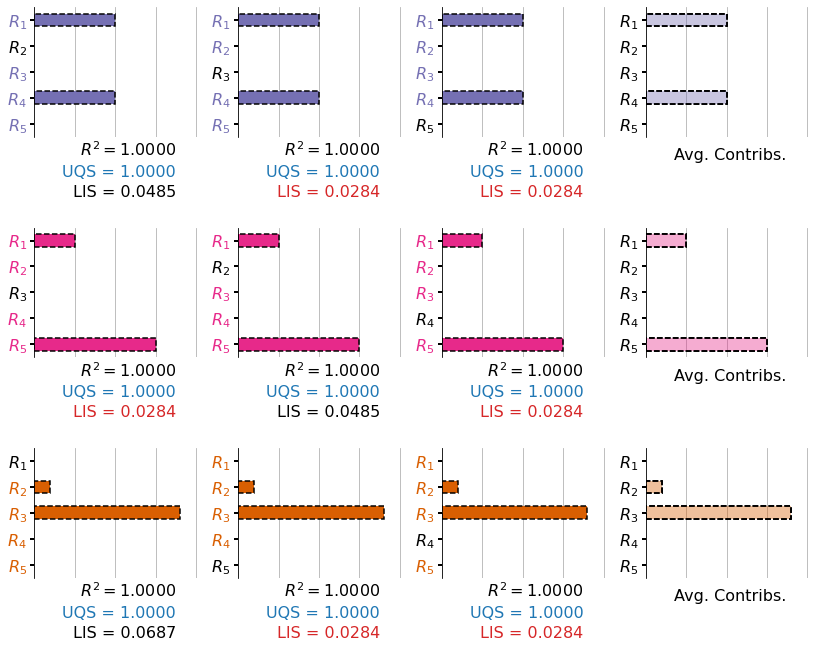

In [85]:
colors = [plt.cm.Dark2(c) for c in [2, 3, 1]]
fig, axes = make_LCF_bar_plot(basis, targets, colors, top_n, Results, keys, subset_size,
                              real_indices=real_indices, real_coeffs=real_coeffs,
                              show_avg=True, flag=True)
plt.savefig('Figures/test_flag_LCF.png', dpi=600, bbox_inches='tight')

# Effects of Noise on LCF

In [86]:
basis = Refs
subset_size = 11
keys = ['subset_indices', 'subset', 'coeffs', 'score']

top_n = 1

Noises = [0, 0.01, 0.02, 0.03, 0.04]
Fits = []
for noise in Noises:
    print(f'Noise = {noise}')
    kwargs = {'N': 20, 'scale': noise, 'dropout': 0.9}
    test_x, test_y = generate_linear_combos(basis, **kwargs)
    targets = test_x
    
    Results = []
    for i in range(len(targets)):
        target = targets[i]
        top_picks = {}
        best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n,
                                               verbose=True, print_best=False)
        subset, coeffs_hat = get_fit_params_from_indices(best_subset_indices[0], basis, target)
        score = -(best_scores[0] - 1)
        Results.append({keys[0]: indices, keys[1]: subset,
                        keys[2]: coeffs_hat, keys[3]: score}) 
    Fits.append(Results)

Noise = 0
Noise = 0.01
Noise = 0.02
Noise = 0.03
Noise = 0.04


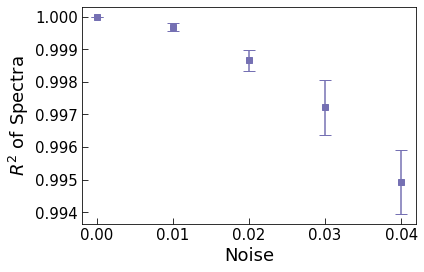

In [87]:
Fits = np.array(Fits)
Scores = []
for i in range(len(Noises)):
    scores = []
    for fit in Fits[i]:
        scores.append(fit['score'])
    Scores.append(scores)
Scores = np.array(Scores)

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(Noises, np.average(Scores, axis=1),
            yerr=np.std(Scores, axis=1),
            marker='s', c=plt.cm.Dark2(2), capsize=6,
            linestyle='none')
ax.tick_params(length=6, labelsize=15, direction='in')
ax.set_ylabel('$R^2$ of Spectra', fontsize=18)
ax.set_xlabel('Noise', fontsize=18)
plt.savefig(f'Figures/LCF_R2_vs_noise.png', dpi=600, bbox_inches='tight')

## Optimal subset size

In [91]:
basis = Refs
keys = ['subset_indices', 'subset', 'coeffs', 'score']
top_n = 1
subset_sizes = [9, 10, 11]

Fits = []
for subset_size in subset_sizes:
    print(f'subset size = {subset_size}')
    kwargs = {'N': 20, 'scale': 0.03, 'dropout': 0.9}
    test_x, test_y = generate_linear_combos(basis, **kwargs)
    targets = test_x
    
    Results = []
    for i in range(len(targets)):
        target = targets[i]
        top_picks = {}
        best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n,
                                               verbose=True, print_best=False)
        subset, coeffs_hat = get_fit_params_from_indices(best_subset_indices[0], basis, target)
        score = -(best_scores[0] - 1)
        Results.append({keys[0]: indices, keys[1]: subset,
                        keys[2]: coeffs_hat, keys[3]: score}) 
    Fits.append(Results)

subset size = 9
subset size = 10
subset size = 11


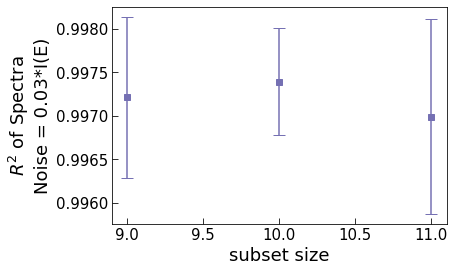

In [92]:
Fits = np.array(Fits)
Scores = []
for i in range(len(subset_sizes)):
    scores = []
    for fit in Fits[i]:
        scores.append(fit['score'])
    Scores.append(scores)
Scores = np.array(Scores)

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(subset_sizes, np.average(Scores, axis=1),
            yerr=np.std(Scores, axis=1),
            marker='s', c=plt.cm.Dark2(2), capsize=6,
            linestyle='none')
ax.tick_params(length=6, labelsize=15, direction='in')
ax.set_ylabel('$R^2$ of Spectra\nNoise = 0.03*I(E)', fontsize=18)
ax.set_xlabel('subset size', fontsize=18)
plt.savefig(f'Figures/LCF_R2_vs_subset_size.png', dpi=600, bbox_inches='tight')

## Cluster averages fit to Refs

In [107]:
utils = reload(utils)
from utils import *

In [110]:
subset_size = 10

basis = Refs
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
targets = np.array(list(cluster_avgs.values()))
top_n = 3

Results = []
for i in range(len(targets)):
    target = targets[i]
    top_picks = {}
    best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n, verbose=True)
    for j, indices in enumerate(best_subset_indices):
        subset, coeffs_hat = get_fit_params_from_indices(indices, basis, target)
        score = best_scores[j]
        top_picks[j + 1] = {keys[0]: indices, keys[1]: subset,
                            keys[2]: coeffs_hat, keys[3]: score}
    Results.append(top_picks)       

[ 0  2  3  4  5  6  7  8  9 10] 0.00540769589000889
[ 0  1  2  3  4  5  6  7  9 10] 0.0006937728752177685
[ 0  1  2  3  5  6  7  8  9 10] 0.001539306950462449
[ 0  1  2  3  4  6  7  8  9 10] 0.00030513315985281064


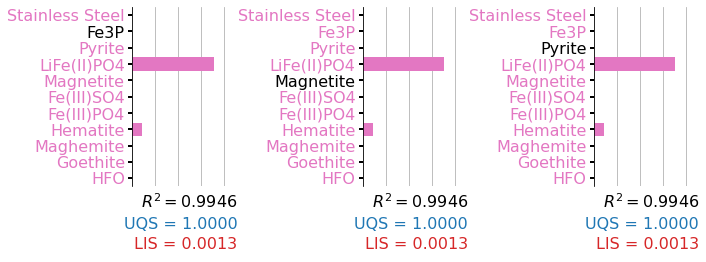

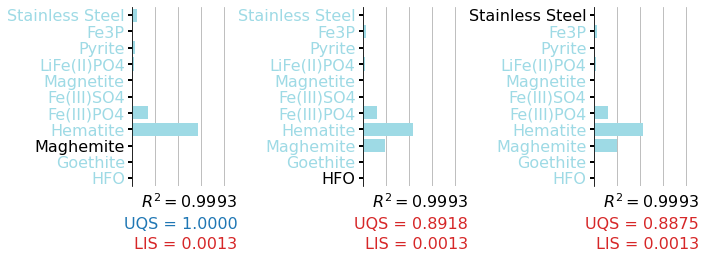

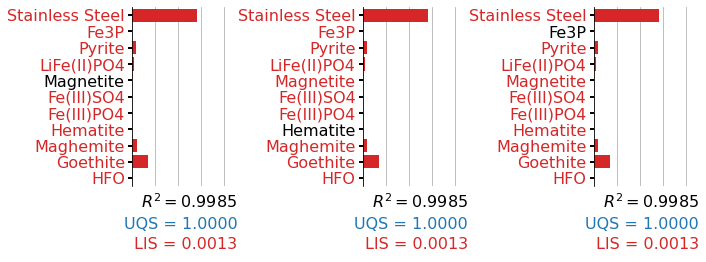

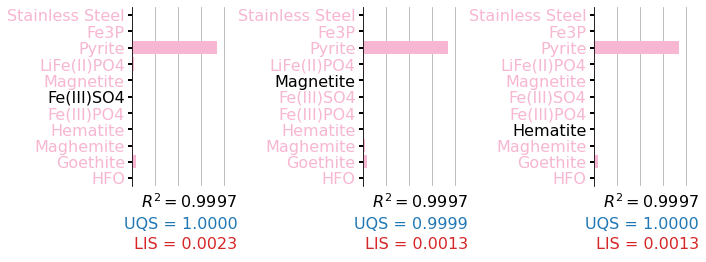

In [111]:
colors = [plt.cm.tab20(c) for c in list(codemap.values())]
labels = np.flip(data_columns)
for i in range(len(colors)):
    fig, axes = make_LCF_bar_plot(basis, [targets[i]], [colors[i]], top_n, [Results[i]], keys, subset_size,
                                  figsize=(2.5, 0.3), hspace=0.6, wspace=1.4, height=0.8,
                                  labels=labels, show_avg=False, flag=True)
    plt.savefig(f'Figures/flagged_LCF_full_cluster_{i + 1}.png', dpi=600, bbox_inches='tight')

In [28]:
subset_size = 11
subset_indices, subsets, coeffs, scores = [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], Refs, subset_size)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

[ 0  1  2  3  4  5  6  7  8  9 10] 0.005412312253300855
[ 0  1  2  3  4  5  6  7  8  9 10] 0.000697070083435114
[ 0  1  2  3  4  5  6  7  8  9 10] 0.0015394872323578612
[ 0  1  2  3  4  5  6  7  8  9 10] 0.0003084382919918971


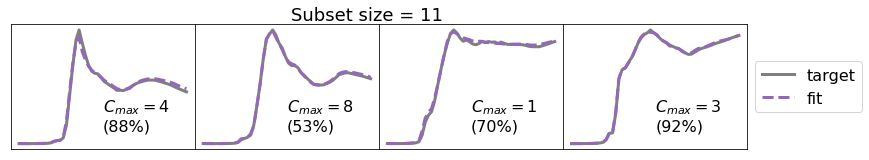

In [29]:
plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Refs_dict,
                ncols=4, flag_identity=False, c=4)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

In [30]:
utils = reload(utils)
from utils import *

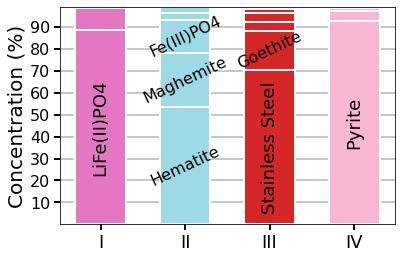

In [34]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 4))
plot_conc_from_subset((fig, ax), np.array(coeffs).reshape(len(coeffs), -1),
                      data_columns, subset_indices, codemap)
plt.savefig('Figures/full_spectra_cluster_concentrations.png', dpi=600, bbox_inches='tight')

In [68]:
utils = reload(utils)
from utils import *

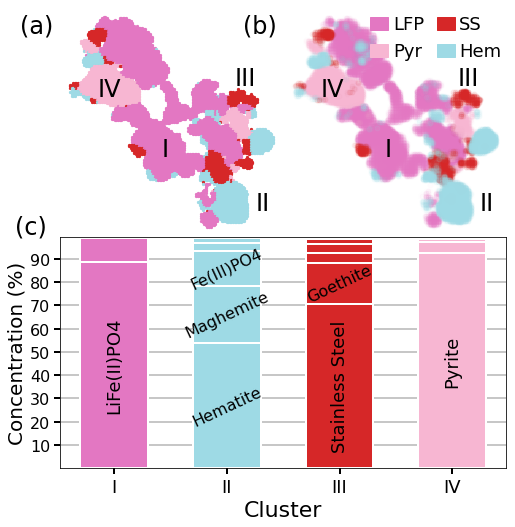

In [38]:
fig = plt.figure(figsize=(8, 8.5))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels)
plot_expected_results(expected_results, axes[1])
for ax in [axes[0], axes[1]]:
    ax.axis('off')

plot_conc_from_subset((fig, axes[2]), np.array(coeffs).reshape(len(coeffs), -1),
                      data_columns, subset_indices, codemap)
axes[2].set_xlabel('Cluster', fontsize=22)

panels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axes):
    if i == 2:
        x = -0.03
        y = 1.1
    else:
        x = -0.03
        y = 0.97
    ax.text(x, y, panels[i], transform=ax.transAxes,
            fontsize=24, va='top', ha='right')

points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['IV', 'I', 'II', 'III']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

plt.savefig('Figures/full_spectrum_results.png', dpi=600,
            transparent=True, bbox_inches='tight')

# Cluster avgs onto grouped Refs

In [145]:
subset_size = 3
lambda1 = 0.5
lambda2 = 1e8
keys = ['subset_indices', 'subset', 'scale', 'coeffs', 'score']

basis = grouped_Refs
cluster_avgs = get_cluster_avgs(normalized_spectra_dict, color_labels, dbscan_clustering)
targets = np.array(list(cluster_avgs.values()))
top_n = 4

Results = []
for i in range(len(targets)):
    target = targets[i]
    top_picks = {}
    best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n,
                                           lambda1=lambda1, lambda2=lambda2,
                                           verbose=True)
    for j, indices in enumerate(best_subset_indices):
        subset, scale, coeffs_hat = get_fit_params_from_indices(indices, basis, target,
                                                                lambda1=lambda1, lambda2=lambda2)
        score = best_scores[j]
        top_picks[j + 1] = {keys[0]: indices, keys[1]: subset, keys[2]: scale,
                            keys[3]: coeffs_hat, keys[4]: score}
    
    Results.append(top_picks)  

[2 5 6] 0.001305296622772012
[2 4 5] 0.002968368845875924
[0 2 4] 0.002293921591225656
[0 1 3] 0.006759677163200806
[1 5 7] 0.0005177008843496589


In [147]:
utils = reload(utils)
from utils import *

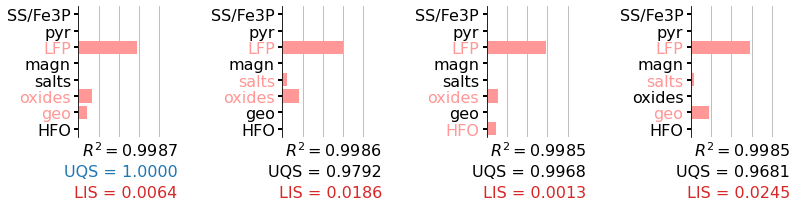

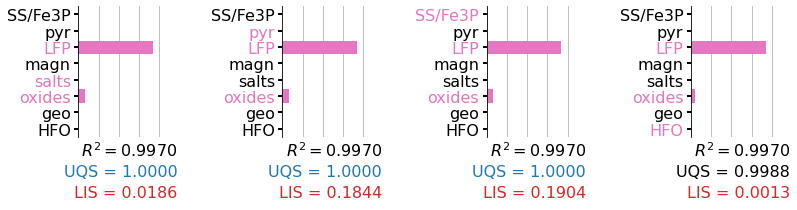

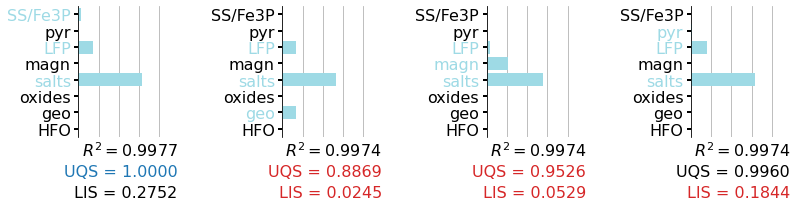

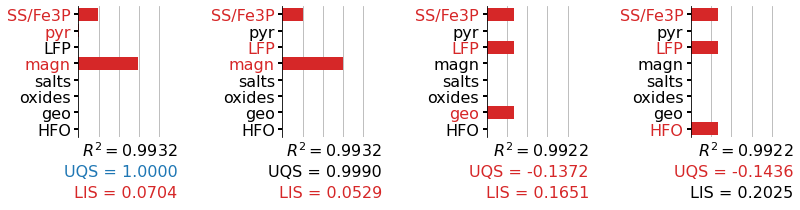

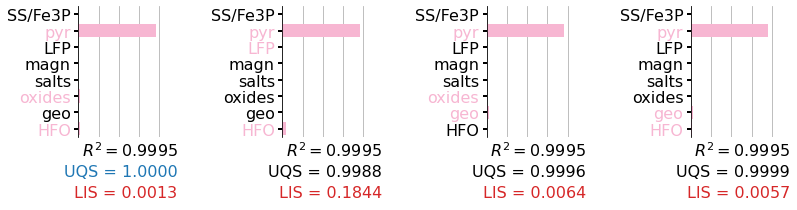

In [148]:
colors = [plt.cm.tab20(c) for c in list(codemap.values())]
labels = np.flip(group_names)
for i in range(len(colors)):
    fig, axes = make_LCF_bar_plot(basis, [targets[i]], [colors[i]], top_n, [Results[i]], keys, subset_size,
                                  figsize=(2.5, 0.3), hspace=0.6, wspace=1.4, height=0.8,
                                  labels=labels, show_avg=False, flag=True)
    plt.savefig(f'Figures/flagged_LCF_grouped_Refs_cluster_{i + 1}.png', dpi=600, bbox_inches='tight')

# LCF on cluster averages with best fits vs expected results

In [149]:
subset_size = 3
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, scale, coeffs_hat, score = LCF(targets[i], grouped_Refs, subset_size,
                                                     lambda1=0.5, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    scales.append(scale)
    coeffs.append(coeffs_hat)
    scores.append(score)

[2 5 6] 0.001305296622772012
[2 4 5] 0.002968368845875924
[0 2 4] 0.002293921591225656
[0 1 3] 0.006759677163200806
[1 5 7] 0.0005177008843496589


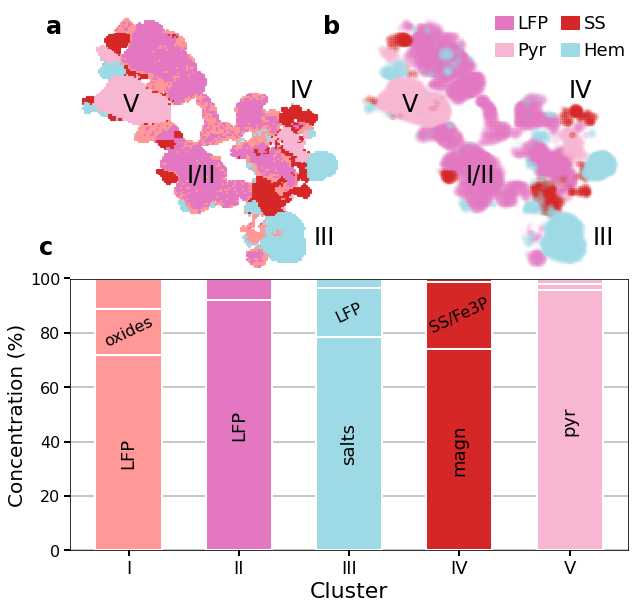

In [150]:
fig = plt.figure(figsize=(10, 10))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0.0, wspace=0.0)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels)
plot_expected_results(expected_results, axes[1])
for ax in [axes[0], axes[1]]:
    ax.axis('off')

plot_conc_from_subset((fig, axes[2]), np.array(coeffs).reshape(len(coeffs), -1),
                      group_names, subset_indices, codemap)
axes[2].set_xlabel('Cluster', fontsize=22)

panels = ['a', 'b', 'c']
for i, ax in enumerate(axes):
    if i == 2:
        x = -0.03
        y = 1.16
    else:
        x = -0.03
        y = 0.97
    ax.text(x, y, panels[i], transform=ax.transAxes, fontweight='bold',
            fontsize=24, va='top', ha='right')

points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['V', 'I/II', 'III', 'IV']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

# PART II. Recursive Feature Elimination

In [221]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

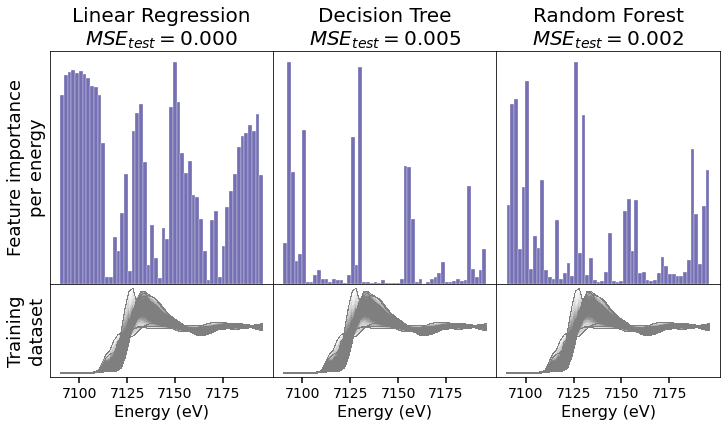

In [274]:
# just RF, no RFE
kwargs = {'N': 5000, 'scale': 0.0, 'dropout': 0.8}
data, coeffs = generate_linear_combos(Refs, **kwargs)

kwargs = {'N': 100, 'scale': 0.0, 'dropout': 0.8}
x_test, y_test = generate_linear_combos(Refs, **kwargs)

models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
fig = plt.figure(figsize=(4 * len(models), 6))
spec = fig.add_gridspec(ncols=len(models), nrows=2, height_ratios=[1, 0.4])
axes = np.array([[fig.add_subplot(spec[row, colm]) for colm in range(len(models))]
                 for row in range(2)])
plt.subplots_adjust(wspace=0, hspace=0)

titles = ['Linear Regression', 'Decision Tree', 'Random Forest']
for i, model in enumerate(models):
    model.fit(data, coeffs)
    if i == 0:
        imp = np.abs(np.average(model.coef_, axis=0))
    else:
        imp = model.feature_importances_
    x = np.arange(imp.shape[0])
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred) 
    var = np.var(data, axis=0)

    axes[0, i].bar(x, imp / np.max(imp), color=plt.cm.Dark2(2), width=1, edgecolor='w', linewidth=0.3)
    axes[1, i].plot(np.tile(energy, (data.shape[0], 1)).T, data.T,
                    linestyle='-', linewidth=0.5, alpha=0.01, color=plt.cm.tab10(7))
    axes[1, i].set_xlabel('Energy (eV)', fontsize=16)
    axes[1, i].set_xticks([7100, 7125, 7150, 7175])
    axes[0, i].set_title(f'{titles[i]}\n' + '$MSE_{test}=' + f'{mse:.3f}$', fontsize=20)
    for ax in axes[:, i]:
        ax.set_yticks([])
        ax.tick_params(length=6, labelsize=14, width=1.5)
axes[0, 0].set_ylabel('Feature importance\nper energy', fontsize=18)
axes[1, 0].set_ylabel('Training\ndataset', fontsize=18)
plt.show()

In [11]:
energy_point_selector = reload(selector.energy_point_selector)

In [31]:
base_estimator = 'Linear Regression'

best_n = 20
Is = []

reps = 30
for i in range(reps):
    print(i, end='\r')
    kwargs = {'N': 500, 'scale': 0.0, 'dropout': 0.8}
    data, coeffs = generate_linear_combos(Refs, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=base_estimator, n_points=best_n,
                                      verbose=False, scoring='r2')
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

df = pd.DataFrame(Is)
df.to_csv('rfe_results.csv')

In [32]:
df = pd.read_csv('rfe_results.csv')
Is = np.array(df)

In [39]:
utils = reload(utils)
from utils import *

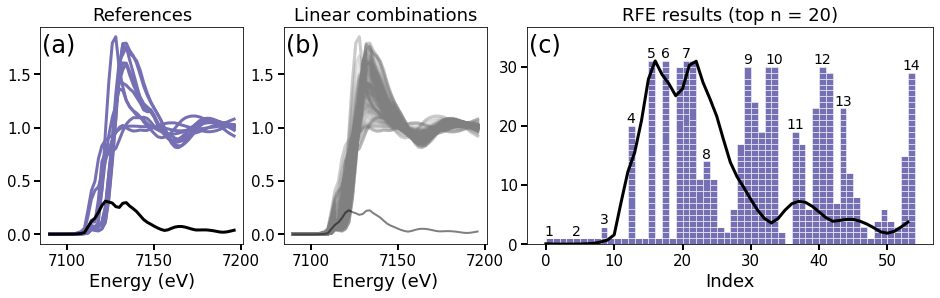

In [40]:
fig = plt.figure(figsize=(16, 4))
spec = fig.add_gridspec(ncols=3, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15)
axes = [fig.add_subplot(spec[j]) for j in range(3)]

#indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
indices = [0, 4, 8, 12, 15, 17, 20, 23, 29, 33, 36, 40, 43, 53]

n_refs = len(Refs)
colors = [plt.cm.Dark2(2) for i in range(n_refs)]
plot_RFE_results(axes, energy, Refs, indices, Is, best_n, colors,
                 leg=False, loc=2, **kwargs)
axes[2].plot(0, 35, 'wo')

labels = ['(a)', '(b)', '(c)']
titles = ['References', 'Linear combinations', f'RFE results (top n = {best_n})']
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=18)
    if i == 2:
        x = 0.005
        ax.set_xlabel('Index', fontsize=18)
    else:
        x = 0.01
        ax.set_xlabel('Energy (eV)', fontsize=18)
    ax.text(x, 0.97, labels[i], transform=ax.transAxes, fontsize=24, va='top', ha='left')

plt.savefig('Figures/RFE_results_Refs.png', dpi=600, bbox_inches='tight')

# RFE on a random sampling of experimental spectra

In [41]:
basis = np.array([x for i, x in enumerate(normalized_spectra) if i % 200 == 0])
print(basis.shape)

(34, 54)


In [48]:
best_estimator = 'Linear Regression'
best_n = 20
Is = []
kwargs = {'N': 2000, 'scale': 0.0, 'dropout': 0.985}

reps = 50
for i in range(reps):
    print(i, end='\r')
    data, coeffs = generate_linear_combos(basis, **kwargs)
    
    select = energy_point_selector.Selector(data, coeffs)
    rfe = select.select_energy_points(estimator=best_estimator, n_points=best_n,
                                      verbose=False, scoring='r2')
    energy_measurements = energy[rfe.support_]
    indices = [i for i, e in enumerate(energy) if e in energy_measurements]
    Is.append(indices)
Is = np.array(Is)

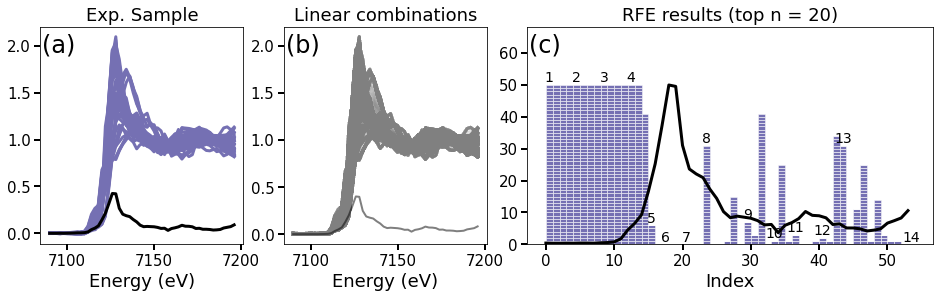

In [49]:
fig = plt.figure(figsize=(16, 4))
spec = fig.add_gridspec(ncols=3, width_ratios=[0.5, 0.5, 1.0])
plt.subplots_adjust(wspace=0.15)
axes = [fig.add_subplot(spec[j]) for j in range(3)]

#indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
indices = [0, 4, 8, 12, 15, 17, 20, 23, 29, 33, 36, 40, 43, 53]
colors = [plt.cm.Dark2(2) for i in range(len(basis))]
plot_RFE_results(axes, energy, basis, indices, Is, best_n, colors,
                 leg=False, loc=3, **kwargs)

labels = ['(a)', '(b)', '(c)']
titles = ['Exp. Sample', 'Linear combinations', f'RFE results (top n = {best_n})']
for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=18)
    if i == 2:
        x = 0.005
        ax.set_xlabel('Index', fontsize=18)
    else:
        x = 0.01
        ax.set_xlabel('Energy (eV)', fontsize=18)
    ax.text(x, 0.97, labels[i], transform=ax.transAxes, fontsize=24, va='top', ha='left')
axes[2].set_ylim(0, axes[2].get_ylim()[1] * 1.3)

plt.savefig('Figures/RFE_results_rand_sample_exp_data.png', dpi=600, bbox_inches='tight')

# Back to the pipeline on energy subset
## Step 1. Slice energies

In [170]:
utils = reload(utils)
from utils import *

In [310]:
#indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
indices = [0, 4, 8, 12, 15, 17, 20, 23, 29, 33, 36, 40, 43, 53]
energy_subset = np.array(energy[indices])
Y_Refs = Refs[:, indices]
Y_Refs, _ = normalize_spectra(energy_subset, Y_Refs, Refs_dict,
                              pre_edge_offset=2, post_edge_offset=4)

prenormalized_subset = np.array(normalized_spectra)[:, indices]

data_subset = np.array(filtered_spectra)[:, indices]
postnormalized_subset, postnormalized_subset_dict = normalize_spectra(energy_subset,
                                                                      data_subset,
                                                                      filtered_spectra_dict,
                                                                      pre_edge_offset=2,
                                                                      post_edge_offset=4)

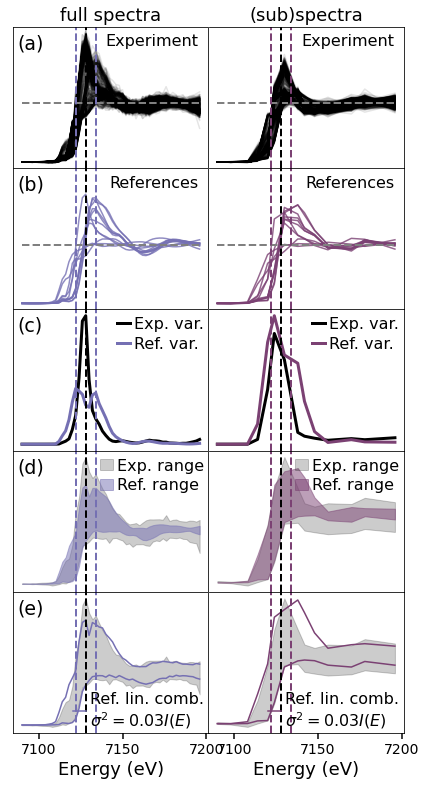

In [340]:
fig, axes = plt.subplots(figsize=(7, 13), nrows=5, ncols=2)
plt.subplots_adjust(hspace=0.0, wspace=0)
labels = ['Experiment', 'References']
colors = [plt.cm.Dark2(2), plt.cm.tab20b(16)]

# axes[0]
for i, s in enumerate(normalized_spectra):
    if i % 10 == 0:
        axes[0, 0].plot(energy, s, 'k-', alpha=0.1)
        axes[0, 1].plot(energy_subset, postnormalized_subset[i], 'k-', alpha=0.1)

# axes[1]
for i, r in enumerate(Refs):
    axes[1, 0].plot(energy, r, '-', c=colors[0], alpha=0.8)
    axes[1, 1].plot(energy_subset, Y_Refs[i], '-', c=colors[1], alpha=0.8)

# axes[2]
axes[2, 0].plot(energy, np.var(normalized_spectra, axis=0), c='k', linewidth=3, label='Exp. var.')
axes[2, 0].plot(energy, np.var(Refs, axis=0), c=colors[0], linestyle='-', linewidth=3, label='Ref. var.')
axes[2, 1].plot(energy_subset, np.var(postnormalized_subset, axis=0), c='k', linewidth=3, label='Exp. var.')
axes[2, 1].plot(energy_subset, np.var(Y_Refs, axis=0), c=colors[1], linestyle='-', linewidth=3, label='Ref. var.')

# axes[3]
axes[3, 0].fill_between(energy, np.max(normalized_spectra, axis=0),
                        np.min(normalized_spectra, axis=0), label='Exp. range',
                        color='k', alpha=0.2)
axes[3, 0].fill_between(energy, np.max(Refs, axis=0), np.min(Refs, axis=0),
                        color=colors[0], alpha=0.5, label='Ref. range')
axes[3, 1].fill_between(energy_subset, np.max(postnormalized_subset, axis=0),
                        np.min(postnormalized_subset, axis=0), label='Exp. range',
                        color='k', alpha=0.2)
axes[3, 1].fill_between(energy_subset, np.max(Y_Refs, axis=0), np.min(Y_Refs, axis=0),
                        color=colors[1], alpha=0.5, label='Ref. range')

# axes[4]
noise = 0.03
kwargs = {'N': 500, 'scale': noise, 'dropout': 0.9}
lin_combos, _ = generate_linear_combos(Refs, **kwargs)
axes[4, 0].fill_between(energy, np.max(normalized_spectra, axis=0),
                        np.min(normalized_spectra, axis=0),
                        color='k', alpha=0.2)
axes[4, 0].plot(energy, np.max(lin_combos, axis=0), '-',
                color=colors[0], label='Ref. lin. comb.\n' +
                f'$\sigma^2=$' + f'{noise}' + '$I(E)$')
axes[4, 0].plot(energy, np.min(lin_combos, axis=0), '-', color=colors[0])

axes[4, 1].fill_between(energy_subset, np.max(postnormalized_subset, axis=0),
                        np.min(postnormalized_subset, axis=0),
                        color='k', alpha=0.2)
axes[4, 1].plot(energy_subset, np.max(lin_combos[:, indices], axis=0), '-',
                color=colors[1], label='Ref. lin. comb.\n' +
                f'$\sigma^2=$' + f'{noise}' + '$I(E)$')
axes[4, 1].plot(energy_subset, np.min(lin_combos[:, indices], axis=0), '-', color=colors[1])

titles = ['full spectra', '(sub)spectra']
panels = ['(a)', '(b)', '(c)', '(d)', '(e)']
for i, axl in enumerate(axes):
    for j, ax in enumerate(axl):
        if i == 0:
            ax.set_title(titles[j], fontsize=18)
        if i in [0, 1]:
            ax.plot(energy, np.ones(len(energy)), '--', c='gray', linewidth=2)
            ax.set_ylim(-0.1, 2.3)
            ax.text(0.95, 0.95, labels[i], transform=ax.transAxes, fontsize=16, ha='right', va='top')
        if i in [2, 3, 4]:
            if i == 4:
                bbox = (1.05, .4)
            else:
                bbox = (1.05, 1.05)
            ax.legend(fontsize=16, handlelength=0.8, framealpha=0, labelspacing=0.3, handletextpad=0.25,
                      bbox_to_anchor=bbox, loc='upper right')
        if i in [0, 1, 2, 3]:
            ax.set_xticks([])
        if i in [4]:
            ax.set_xlabel('Energy (eV)', fontsize=18)
        ax.set_yticks([])
        ax.tick_params(length=6, labelsize=14, width=1.5)
        ax.axvline(x=7122, c=colors[j], linestyle='--', linewidth=2)
        ax.axvline(x=7134, c=colors[j], linestyle='--', linewidth=2)
        ax.axvline(x=7128, c='k', linestyle='--', linewidth=2)
        if j == 0:
            ax.text(0.02, 0.95, panels[i], transform=ax.transAxes, fontsize=19, ha='left', va='top')

In [173]:
metric = '$R^2$'
Sim_matrices = []
start_n = 3
for i in range(start_n, Y_Refs.shape[1] + 1):
    Similarity_matrix = get_similarity_mtx(Y_Refs[:, :i], metric=metric)
    Sim_matrices.append(Similarity_matrix)
vmin = np.min(Sim_matrices)
vmax = np.max(Sim_matrices)

#Sim_matrices = (Sim_matrices - vmin) / (vmax - vmin)

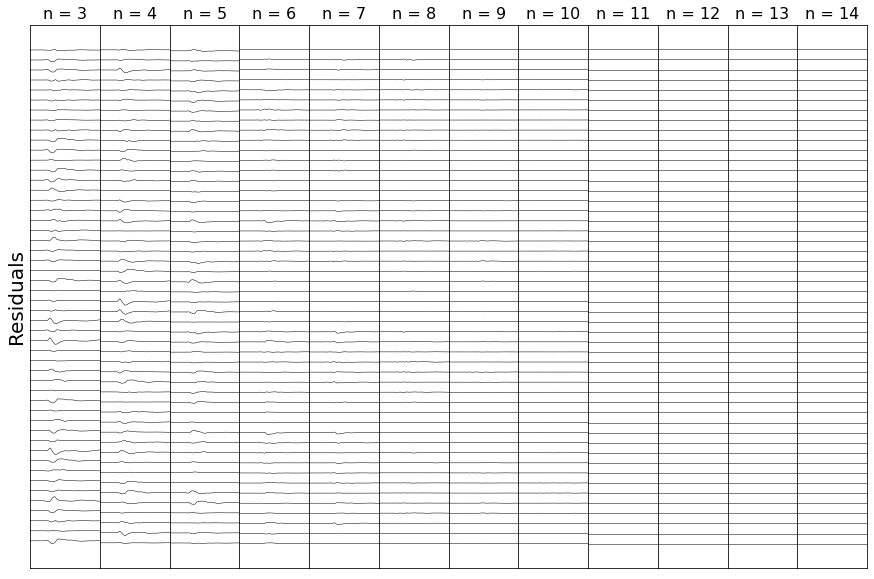

In [78]:
data_noises = [0.01, 0.03, 0.05]
train_loss = []
test_loss = []
n = len(indices)

fig, axes = plt.subplots(figsize=(15, 10), ncols= n + 1 - start_n)
plt.subplots_adjust(wspace=0)

scores = []
for i in range(start_n, n + 1):
    basis = Refs[:, indices[:i]]
    kwargs = {'scale': 0, 'dropout': 0.8}
    
    kwargs['N'] = 500
    train_x, train_y = generate_linear_combos(basis, **kwargs)
    kwargs['N'] = 50
    test_x, test_y = generate_linear_combos(basis, **kwargs)
        
    reg = LinearRegression()
    reg.fit(train_x, train_y)

    pred_y = reg.predict(test_x)
    
    full_x = test_y @ Refs
    pred_x = pred_y @ Refs
    
    ax = axes[i - start_n]
    for j in range(len(full_x)):
        ax.plot(energy, full_x[j] - pred_x[j] + j, '-', linewidth=0.5,
                        color='k')
        
    ax.set_title(f'n = {i}', fontsize=16)
    
    score = [r2_score(full_x[j], pred_x[j]) for j in range(len(full_x))]
    scores.append(score)
    
scores = np.array(scores)
    
for ax in axes:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(min(energy), max(energy))
    
axes[0].set_ylabel('Residuals', fontsize=20)
plt.show()

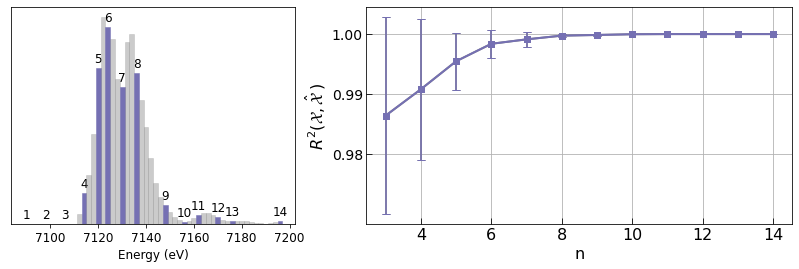

In [79]:
fig = plt.figure(figsize=(14, 4))
x = 0.4
spec = fig.add_gridspec(ncols=2, width_ratios=[x, 1. - x])
axes = [fig.add_subplot(spec[i]) for i in range(2)]
plt.subplots_adjust(wspace=0.2)

var = np.var(Refs, axis=0)

def plot_n_vs_indices(highlight):
    for ax in axes:
        ax.clear()
    
    axes[0].set_yticks([])
    axes[0].tick_params(length=4, labelsize=12)
    axes[0].set_xlabel('Energy (eV)', fontsize=12)

    alt_color = plt.cm.Dark2(2)
    colors = np.array([plt.cm.tab10(7) for i in range(len(energy))])
    colors[:, 3] = 0.4

    scaled_var = var / np.max(var) * np.max(Refs)

    for i, idx in enumerate(indices[:highlight]):
        axes[0].text(energy[idx], scaled_var[idx] + 0.02, i + 1,
                fontsize=12, ha='center', va='bottom')

    colors[indices[:i + 1]] = alt_color
    colors[indices[:i + 1], 3] = 1.

    axes[0].bar(energy, scaled_var, color=colors, width=2, zorder=10,
                edgecolor=colors, linewidth=0.5)

    end_idx = highlight - start_n + 1
    axes[1].errorbar(np.arange(start_n, n + 1), np.average(scores, axis=1), marker='s',
                     c=plt.cm.tab10(7), capsize=4, linestyle='none',
                     yerr=np.std(scores, axis=1))
    axes[1].errorbar(np.arange(start_n, n + 1)[:end_idx],
                     np.average(scores, axis=1)[:end_idx],
                     yerr=np.std(scores, axis=1)[:end_idx],
                     marker='s', c=alt_color, capsize=4,
                     linestyle='none')
    axes[1].plot(np.arange(start_n, n + 1), np.average(scores, axis=1), color=plt.cm.tab10(7),
                 linestyle='-', linewidth=2)
    axes[1].plot(np.arange(start_n, n + 1)[:end_idx],
                 np.average(scores, axis=1)[:end_idx],
                 color=alt_color, linestyle='-', linewidth=2)
    axes[1].set_yticks([0.98, 0.99, 1.])
    axes[1].tick_params(length=6, labelsize=14, direction='in')
    axes[1].tick_params(labelsize=16, axis='x')
    axes[1].grid()
    axes[1].set_xlabel('n', fontsize=16)
    axes[1].set_ylabel('$R^2(\mathcal{X}, \hat{ \mathcal{X} } \; )$', fontsize=16)

ani = FuncAnimation(fig, plot_n_vs_indices, interval=100,
                    frames=np.arange(start_n, len(indices) + 1), blit=False)
ani.save(f"Figures/scores_vs_n_indices.gif", dpi=600, writer=PillowWriter(fps=.85))

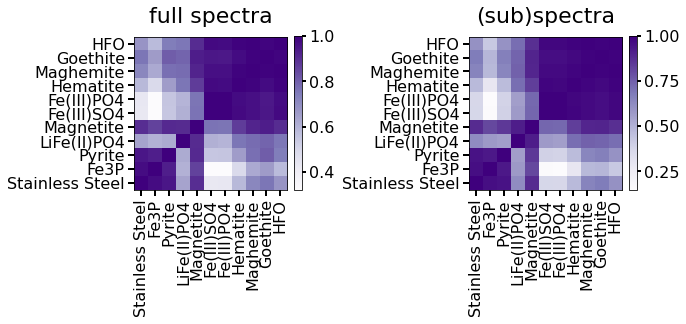

In [290]:
metric = '$R^2$'
fig, axes = plt.subplots(figsize=(9, 3), ncols=2)
plt.subplots_adjust(wspace=1)

refs = [Refs, Y_Refs]
titles = ['full spectra', '(sub)spectra']

for i, ref in enumerate(refs):
    Similarity_matrix = get_similarity_mtx(ref, metric=metric)
    plot_corr_matx(axes[i], Similarity_matrix, data_columns, metric, cmap=plt.cm.Purples)
    axes[i].set_title(titles[i], fontsize=22, y=1.05)

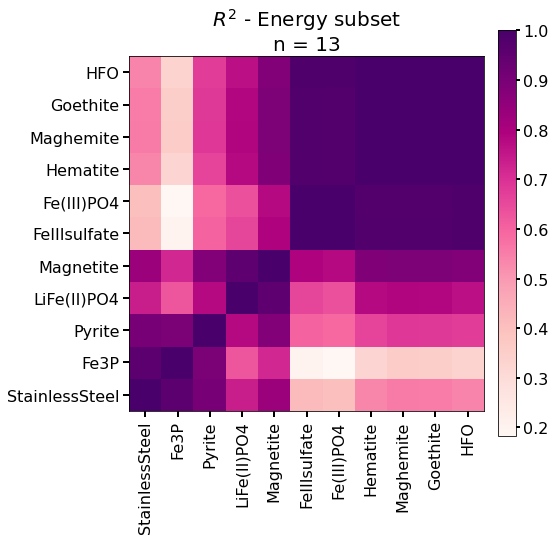

In [302]:
def animate(i):
    ax = axes[1]
    cax = axes[2]
    ax.clear()
    cax.clear()
    metric = f'$ R^2 $ - Energy subset\nn = {i + 2}'
    
    img = ax.imshow(Sim_matrices[i], cmap=plt.cm.RdPu,
                    interpolation='nearest', origin='lower')
    ax.tick_params(direction='out', width=2, length=6, labelsize=14)
    ax.set_title(f'{metric}', fontsize=20)
    
    cbar = plt.colorbar(img, cax=cax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=16, width=2, length=4)
    
    N = len(Sim_matrices[i])
    ax.set_yticks(np.arange(N))
    ax.set_yticklabels(data_columns, fontsize=16)

    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(data_columns, fontsize=16, rotation=90)
    
    for j, axis in enumerate(axes):
        if j not in [1, 2]:
            axis.axis('off')

fig = plt.figure(figsize=(8, 8))
spec = fig.add_gridspec(nrows=2, ncols=3, width_ratios=[0.13, 1, 0.05], height_ratios=[1, 0.02])
axes = [fig.add_subplot(spec[i, j]) for i, j in itertools.product(range(2), range(3))]
plt.subplots_adjust(hspace=0.1, wspace=0.1)

ani = FuncAnimation(fig, animate, interval=300, frames=len(Sim_matrices), blit=False)
ani.save(f"Figures/subset_corr.gif", dpi=600, writer=PillowWriter(fps=1.5))

## Normalization

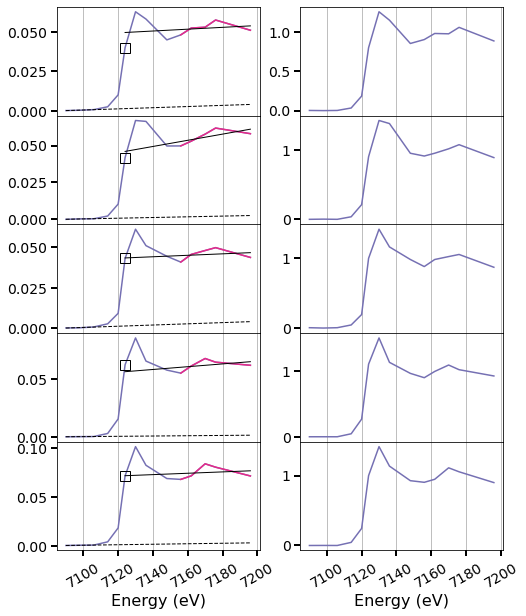

In [61]:
sub_slopes, sub_intercepts, sub_whitelines = show_normalization(energy_subset, data_subset,
                                                                N=5, return_params=True,
                                                                pre_edge_offset=2, post_edge_offset=4,
                                                                colors=[plt.cm.Dark2(2), plt.cm.Dark2(3)])

In [62]:
def plot_params(ax, energy, params, color, scale=1, dy=0):
    pre, post, whiteline = params
    ax.plot(energy, pre / scale - dy, '--', c=color)
    ax.plot(energy[whiteline:], post / scale - dy, c=color)
    ax.plot(energy[whiteline], post[0] / scale - dy, 's', fillstyle='none',
             linewidth=3, markersize=10, c=color)
    
def get_scale_dy(spectrum):
    alpha = np.max(spectrum)
    dy = np.min(spectrum / alpha)
    return alpha, dy

In [63]:
N = 100

pre_edge_fits, post_edge_fits, whitelines = show_normalization(Fe_energy, filtered_spectra, N=N, start_i=0,
                                                               pre_edge_offset=10, post_edge_offset=18,
                                                               whiteline_range=-1,
                                                               return_params=True, plot=False)

sub_pre_edge_fits, sub_post_edge_fits, sub_whitelines = show_normalization(energy_subset, data_subset, N=N, start_i=0,
                                                                           pre_edge_offset=2, post_edge_offset=4,
                                                                           return_params=True,
                                                                           plot=False)

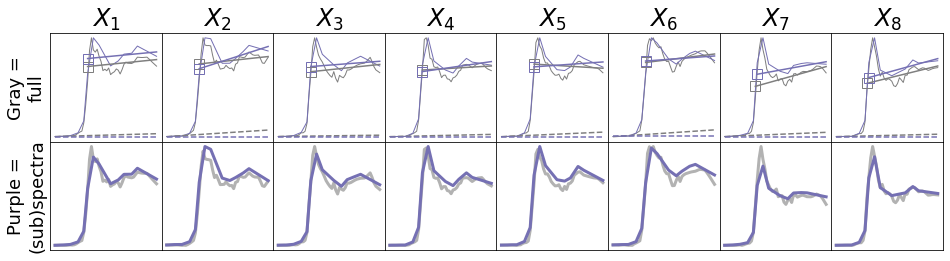

In [281]:
N = 8

fig, axes = plt.subplots(figsize=(2 * N, 4), ncols=N, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0)

colors = [plt.cm.tab10(7), plt.cm.Dark2(2)]
alphas = [0.6, 1]

R2s = []
for idx in range(N):
    xs = []
    for j, params in enumerate([[pre_edge_fits[idx], post_edge_fits[idx], whitelines[idx]],
                                [sub_pre_edge_fits[idx], sub_post_edge_fits[idx], sub_whitelines[idx]]]):
        
        pre, post, whiteline = params
        
        if j == 0:
            e = Fe_energy
            spectrum = filtered_spectra[idx]
        else:
            e = energy_subset
            pre = np.ones(len(e)) * pre[0]            
            spectrum = data_subset[idx]
               
        scale, dy = get_scale_dy(spectrum)
        params = pre, post, whiteline
        plot_params(axes[0, idx], e, params, colors[j], scale=scale, dy=dy)
        
        axes[0, idx].plot(e, spectrum / scale - dy, c=colors[j], linewidth=1, zorder=1)
        
        y_norm = normalize_spectrum(e, spectrum, verbose=False,
                                    whiteline=whiteline, y_fit_pre=pre, y_fit_post=post)

        axes[1, idx].plot(e, y_norm, linestyle='-', c=colors[j], linewidth=3, alpha=alphas[j])        
    
    axes[0, idx].set_title(f'$X_{idx + 1}$', fontsize=24)
    if idx == 0:
        axes[0, idx].set_ylabel('Gray =\nfull', fontsize=18)
        axes[1, idx].set_ylabel('Purple =\n(sub)spectra', fontsize=18)
    for ax in axes[:, idx]:
        ax.set_yticks([])
        ax.set_xticks([])

## Step 2. Clustering pipeline

In [296]:
utils = reload(utils)
from utils import *

It takes 6 PCs to explain
97% variance.
It takes 4 PCs to explain
97% variance.


Text(0.5, 1.0, 'Post-normalized (sub)spectra')

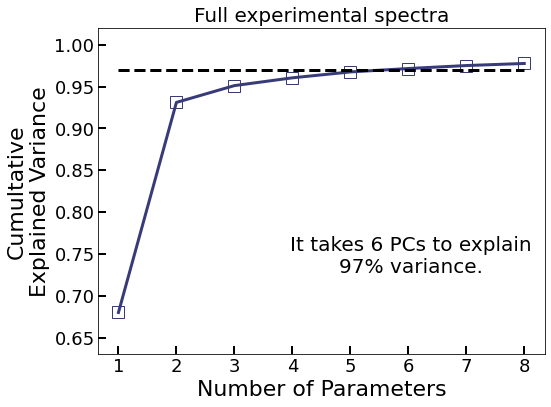

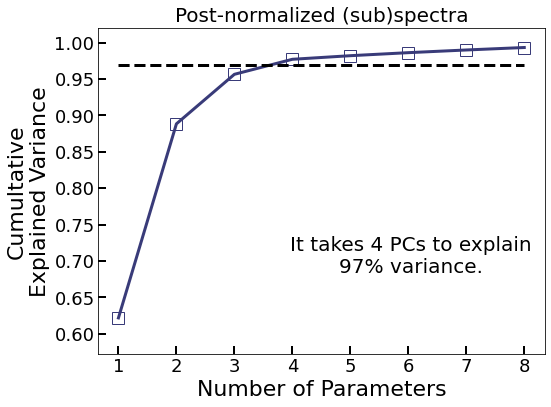

In [318]:
n_components_sub = make_scree_plot(normalized_spectra, n=8, c=0, threshold=0.97, show_first_PC=False)
plt.title('Full experimental spectra', fontsize=20)

n_components_sub = make_scree_plot(postnormalized_subset, n=8, c=0, threshold=0.97, show_first_PC=False)
plt.title('Post-normalized (sub)spectra', fontsize=20)

It takes 7 PCs to explain
99% variance.
5 -> 13
4 -> 0
3 -> 6
1 -> 7
0 -> 12
2 -> 19


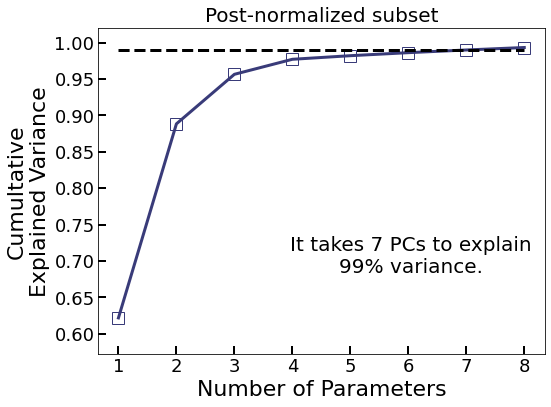

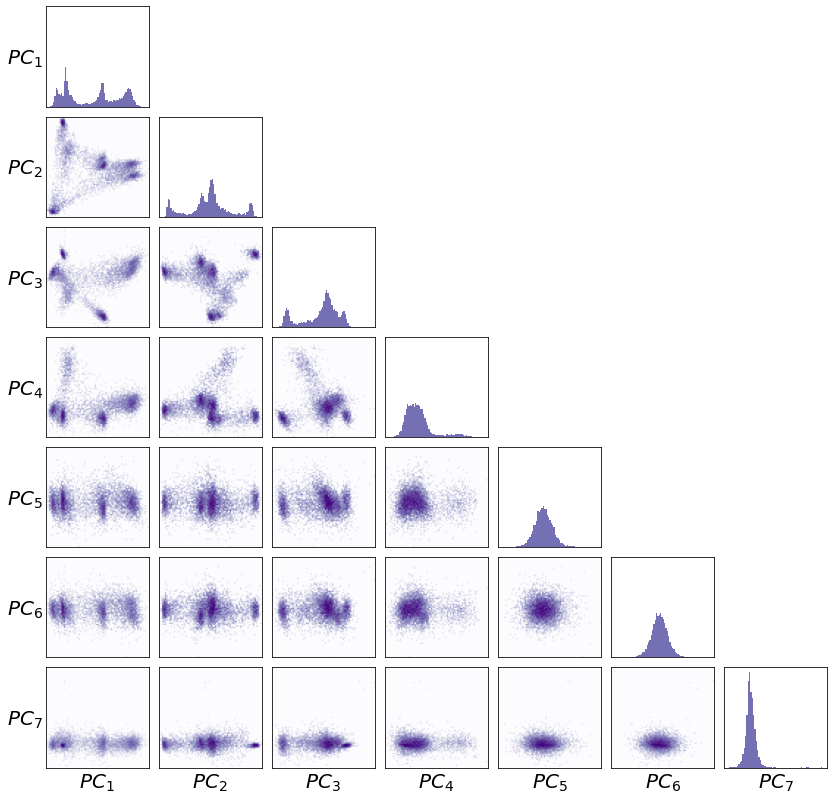

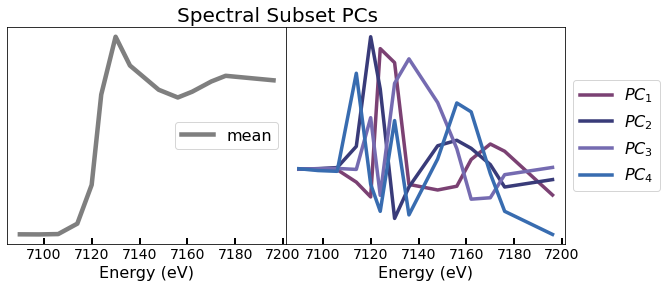

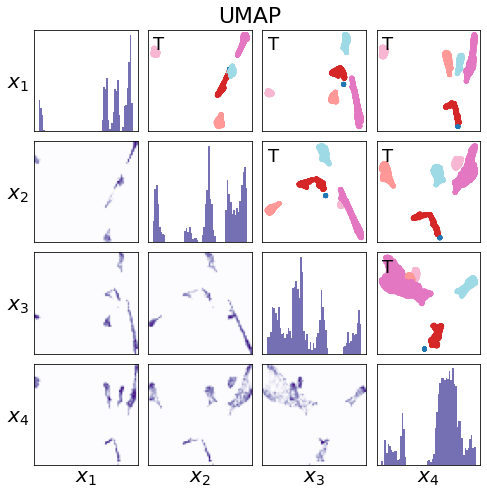

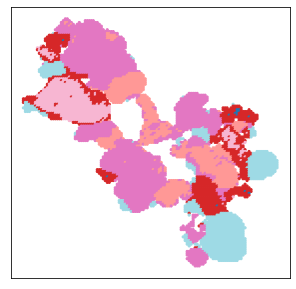

In [304]:
# PCA
n_components_sub = make_scree_plot(postnormalized_subset, n=8, c=0, threshold=0.99, show_first_PC=False)
plt.title('Post-normalized subset', fontsize=20)
plt.savefig('Figures/subset_scree.png', dpi=600, bbox_inches='tight')

pca, pca_components = make_PCA_triangle_plot(postnormalized_subset, n_components_sub, bins=70,
                                             cmap=plt.cm.Purples, c=plt.cm.Dark2(2))
plt.savefig('Figures/subset_PCA_traingle_plot.png', dpi=600, bbox_inches='tight')

colors = [plt.cm.tab20b(16), plt.cm.tab20b(0), plt.cm.tab20c(12), plt.cm.Accent(4)]
show_PCs(energy_subset, pca, n=4, colors=colors, alpha=1)
plt.suptitle('Spectral Subset PCs', fontsize=20, y=0.95)
plt.savefig('Figures/subset_first_PCs.png', dpi=600, bbox_inches='tight')

# UMAP
color_labels_sub, codemap_sub, dbscan_clustering_sub = make_UMAP_plot(pca_components, normalized_spectra_dict,
                                                                      n_neighbors=20, min_dist=0, dimension=4,
                                                                      eps=1., bins=60, translation=4,
                                                                      cmap=plt.cm.Purples, c=plt.cm.Dark2(2))
plt.savefig('Figures/subset_UMAP.png', dpi=600, bbox_inches='tight')

# Final Clusters
plot_color_code_map(plt.subplots(figsize=(5, 5)), normalized_spectra_dict, color_labels_sub)
plt.savefig('Figures/subset_cluster_map.png', dpi=600, bbox_inches='tight')

In [305]:
print(len(np.unique(dbscan_clustering_sub.labels_)))
print(len(np.unique(color_labels_sub)))

6
6


In [285]:
utils = reload(utils)
from utils import *

4 -> 6
2 -> 3
0 -> 7
2 -> 13
3 -> 12
1 -> 19


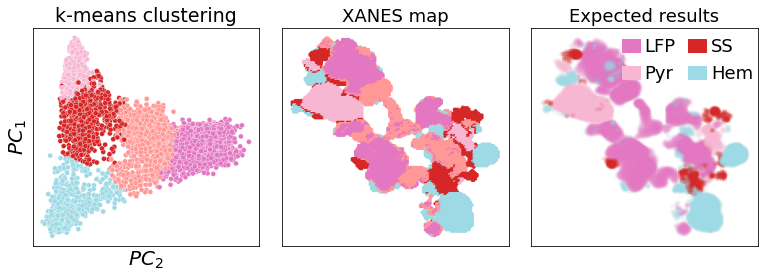

In [143]:
two_dimensional_clustering(postnormalized_subset, normalized_spectra_dict,
                           expected_results, method='PCA', clustering='k-means',
                           translation=5, n_clusters=5, data_description='subset_6_clusters')

Couldn't cluster 0 points
0 -> 7
5 -> 13
0 -> 12
0 -> 19


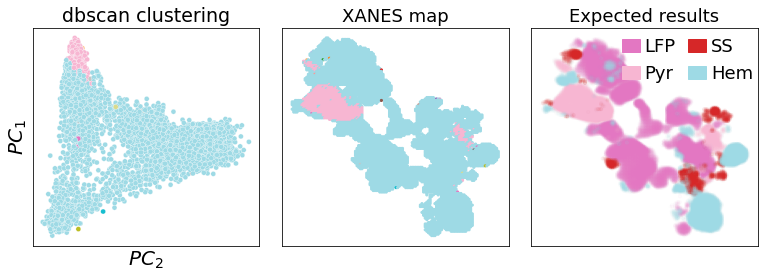

In [147]:
two_dimensional_clustering(postnormalized_subset, normalized_spectra_dict,
                           expected_results, method='PCA', clustering='dbscan', eps=0.1,
                           translation=3, data_description='subset')

Couldn't cluster 0 points
4 -> 13
3 -> 0
3 -> 6
1 -> 7
0 -> 12
2 -> 19


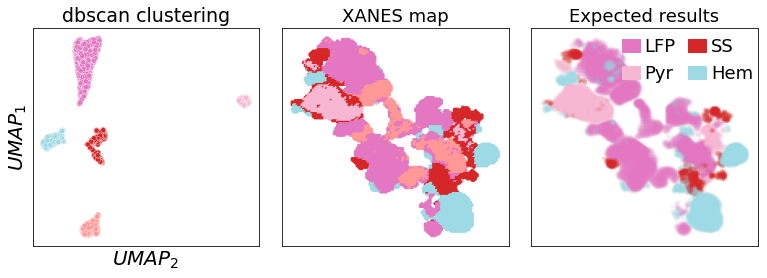

In [148]:
two_dimensional_clustering(postnormalized_subset, normalized_spectra_dict,
                           expected_results, method='UMAP', clustering='dbscan',
                           eps=0.7, translation=4, data_description='subset')

## Step 3. LCF

In [150]:
#indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
indices = [0, 4, 8, 12, 15, 17, 20, 23, 29, 33, 36, 40, 43, 53]
energy_subset = np.array(energy[indices])
Y_Refs = Refs[:, indices]

In [151]:
clusters = {i: [] for i in np.unique(dbscan_clustering_sub.labels_)}

for i, key in enumerate(list(normalized_spectra_dict.keys())):
    spectrum = normalized_spectra_dict[key][indices]
    color = dbscan_clustering_sub.labels_[i]
    clusters[color].append(spectrum)

cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}

In [152]:
subset_size = 10
keys = ['subset_indices', 'subset', 'coeffs', 'score']

basis = Y_Refs
targets = np.array(list(cluster_avgs.values()))
top_n = 3

Results = []
for i in range(len(targets)):
    target = targets[i]
    top_picks = {}
    best_subset_indices, best_scores = LCF(target, basis, subset_size, reps=top_n, verbose=True)
    for j, indices in enumerate(best_subset_indices):
        subset, coeffs_hat = get_fit_params_from_indices(indices, basis, target)
        score = best_scores[j]
        top_picks[j + 1] = {keys[0]: indices, keys[1]: subset,
                            keys[2]: coeffs_hat, keys[3]: score}
    
    Results.append(top_picks)       

[ 0  1  2  3  4  5  7  8  9 10] 0.011421034951366926
[ 1  2  3  4  5  6  7  8  9 10] 0.0021106190420566717
[ 0  1  2  3  4  6  7  8  9 10] 0.0006318747626296028
[ 0  1  2  3  5  6  7  8  9 10] 0.0012484916482653485
[ 0  1  2  4  5  6  7  8  9 10] 0.0026705102910766776
[ 1  2  3  4  5  6  7  8  9 10] 0.00044820105217491246


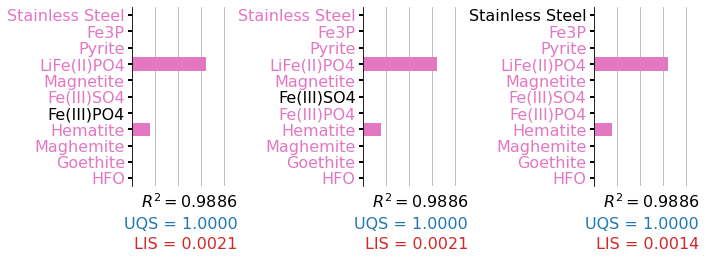

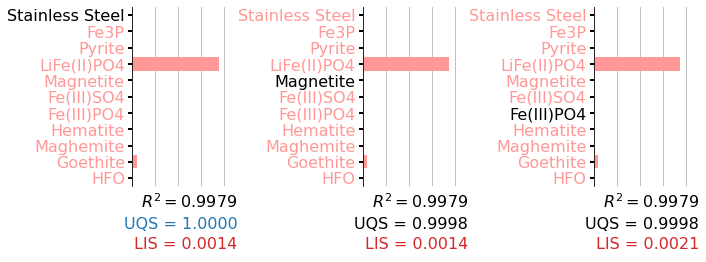

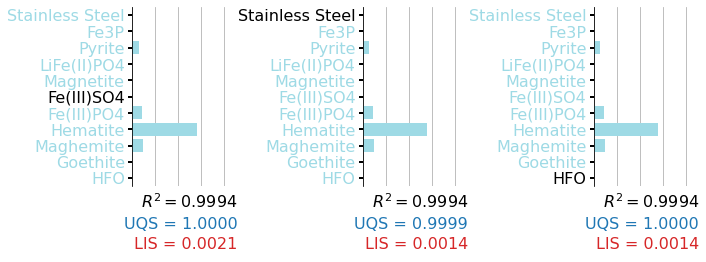

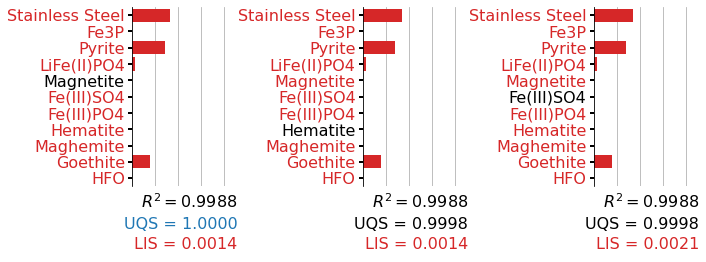

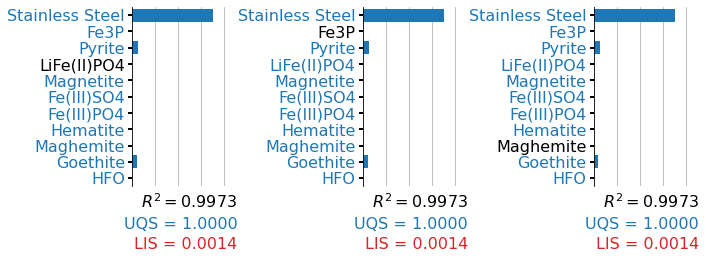

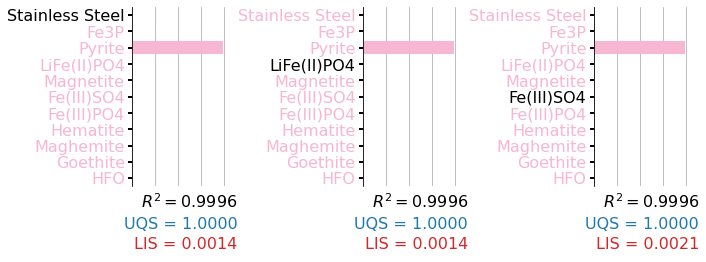

In [153]:
colors = [plt.cm.tab20(c) for c in list(codemap_sub.values())]
labels = np.flip([e.replace('NP', '').replace('_', '') for e in data_columns])
for i in range(len(colors)):
    fig, axes = make_LCF_bar_plot(basis, [targets[i]], [colors[i]], top_n, [Results[i]], keys, subset_size,
                                  figsize=(2.5, 0.3), hspace=0.6, wspace=1.4, height=0.8,
                                  labels=labels, show_avg=False, flag=True)
    plt.savefig(f'Figures/flagged_LCF_subset_cluster_{i + 1}.png', dpi=600, bbox_inches='tight')

In [154]:
subset_size = 11
subset_indices_sub, subsets_sub, coeffs_sub, scores_sub = [], [], [], []
targets = np.array(list(cluster_avgs.values()))
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], Y_Refs, subset_size)
    subset_indices_sub.append(sub_idxs)
    subsets_sub.append(subset)
    coeffs_sub.append(coeffs_hat)
    scores_sub.append(score)

[ 0  1  2  3  4  5  6  7  8  9 10] 0.01142129277623738
[ 0  1  2  3  4  5  6  7  8  9 10] 0.002126152667134229
[ 0  1  2  3  4  5  6  7  8  9 10] 0.0006563519224516146
[ 0  1  2  3  4  5  6  7  8  9 10] 0.001249602746249967
[ 0  1  2  3  4  5  6  7  8  9 10] 0.0026751486202011288
[ 0  1  2  3  4  5  6  7  8  9 10] 0.00044845218474887094


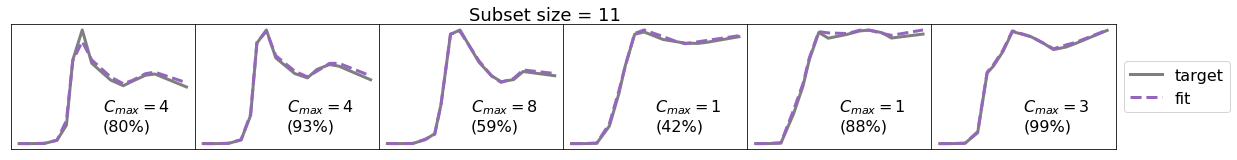

In [308]:
plot_recon_grid(energy_subset, targets, subset_indices_sub, subsets_sub, coeffs_sub, Refs_dict,
                ncols=6, flag_identity=False, c=4)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.show()

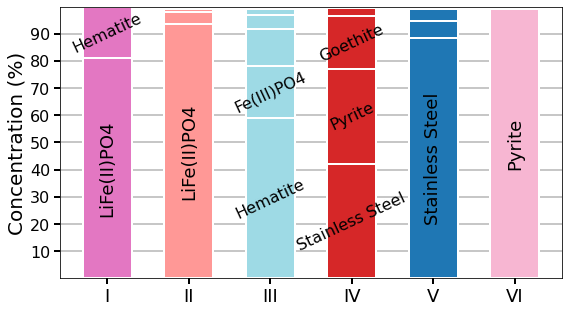

In [160]:
fig, ax = plt.subplots(figsize=(len(cluster_avgs) * 1.5, 5))
plot_conc_from_subset((fig, ax), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      data_columns, subset_indices_sub, codemap_sub)
plt.savefig('Figures/subset_cluster_concentrations.png', dpi=600, bbox_inches='tight')

In [161]:
utils = reload(utils)
from utils import *

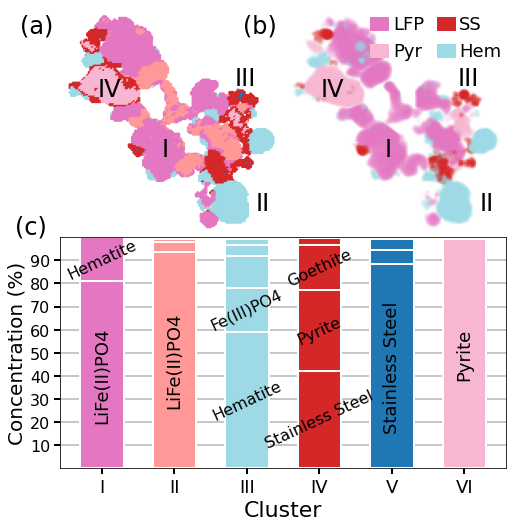

In [162]:
fig = plt.figure(figsize=(8, 8.5))
spec = fig.add_gridspec(nrows=2, ncols=2)
axes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1]),
        fig.add_subplot(spec[1, :])]
plt.subplots_adjust(hspace=0., wspace=0.)

plot_color_code_map((fig, axes[0]), normalized_spectra_dict, color_labels_sub)
plot_expected_results(expected_results, axes[1])
for ax in [axes[0], axes[1]]:
    ax.axis('off')

plot_conc_from_subset((fig, axes[2]), np.array(coeffs_sub).reshape(len(coeffs_sub), -1),
                      data_columns, subset_indices_sub, codemap_sub)
axes[2].set_xlabel('Cluster', fontsize=22)

panels = ['(a)', '(b)', '(c)']
for i, ax in enumerate(axes):
    if i == 2:
        x = -0.03
        y = 1.1
    else:
        x = -0.03
        y = 0.97
    ax.text(x, y, panels[i], transform=ax.transAxes,
            fontsize=24, va='top', ha='right')

points = [(0.22, 0.64), (0.47, 0.38), (0.91, 0.15), (0.83, 0.69)]
labels = ['IV', 'I', 'II', 'III']
for ax in axes[:2]:
    for i, pt in enumerate(points):
        x, y = pt
        ax.text(x, y, labels[i], transform=ax.transAxes,
                fontsize=24, va='center', ha='center')

plt.savefig('Figures/subset_results.png', dpi=600,
            transparent=True, bbox_inches='tight')

# Comparing both analyses

In [197]:
def get_cluster_conc(i, dbscan_clustering, subset_indices, N, coeffs):
    cluster = dbscan_clustering.labels_[i]
    concentrations = np.zeros(N)
    for j, index in enumerate(subset_indices[cluster]):
        concentrations[index] = coeffs[cluster, 0, j]
    return concentrations

In [198]:
scores = []
X1 = []
X2 = []
for i in range(len(normalized_spectra)):
    x1 = get_cluster_conc(i, dbscan_clustering, np.array(subset_indices),
                          Refs.shape[0], np.array(coeffs))
    x2 = get_cluster_conc(i, dbscan_clustering_sub, np.array(subset_indices_sub),
                          Y_Refs.shape[0], np.array(coeffs_sub))
    score = wasserstein_distance(x1, x2)
    scores.append(score)
    X1.append(x1)
    X2.append(x2)
scores = np.array(scores)
X1 = np.array(X1)
X2 = np.array(X2)
print(np.average(scores))

0.022587909108433887


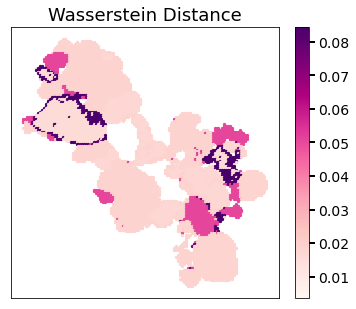

In [200]:
spectra_dict = normalized_spectra_dict
colors = [s / np.max(scores) + np.min(scores) for s in scores]
norm = mpl.colors.Normalize(vmin=np.min(scores), vmax=np.max(scores))

"""
intensities = np.max(filtered_spectra, axis=1)
norm = mpl.colors.Normalize(vmin=np.min(intensities), vmax=np.max(intensities))
intensities = [c / np.max(intensities) + np.min(intensities) for c in intensities]
intensities = np.array(intensities)
colors = intensities
"""

fig, ax = plt.subplots(figsize=(6, 5))
for i, key in enumerate(list(spectra_dict.keys())):
    spectrum = spectra_dict[key]
    x, y = key
    ax.plot(y, -x, marker='.', color=plt.cm.RdPu(colors[i]), markersize=4.5)
remove_ticks(ax) 

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.RdPu))
cbar.ax.tick_params(direction='out', width=2, length=6, labelsize=14)
plt.title('Wasserstein Distance', fontsize=18)
plt.show()

# Pixel by Pixel Analysis using XRF

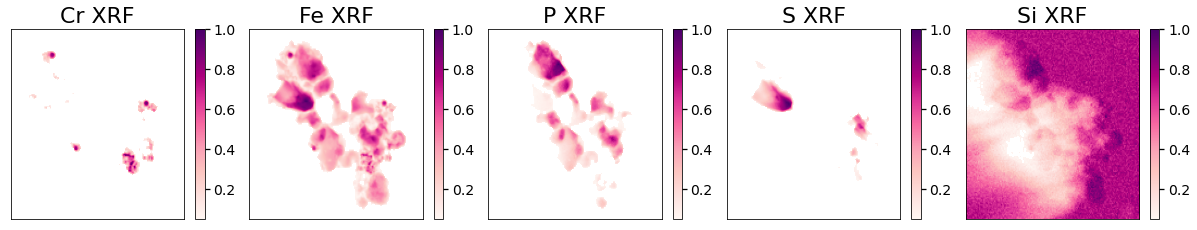

In [225]:
fig, axes = plt.subplots(figsize=(4.2 * len(elements), 3.5), ncols=len(elements))
plt.subplots_adjust(wspace=0.1)

for i, ax in enumerate(axes):
    norm_xrf = xrfs[elements[i]] - np.min(xrfs[elements[i]])
    norm_xrf = norm_xrf / np.max(norm_xrf)
    filtered_xrf = get_filtered_img(norm_xrf, threshold=0.05)
    img = ax.imshow(filtered_xrf, extent=[0, 1, 0, 1], aspect='auto', cmap=plt.cm.RdPu)
    remove_ticks(ax)
    ax.set_title(f'{elements[i]} XRF', fontsize=22)
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.tick_params(width=1.3, length=5, labelsize=14)

In [226]:
fd, mask = get_filtered_img(Fe_xanes, return_mask=True)
xrf_dict = normalized_spectra_dict.copy()

for x in range(fd.shape[1]):
    for y in range(fd.shape[2]):
        for ele in elements[:-1]:
            norm_xrf = xrfs[ele] - np.min(xrfs[ele])
            norm_xrf = norm_xrf / np.max(norm_xrf)
            if mask[0, x, y] == False:
                if norm_xrf[x, y] > 0.05:
                    signal = 1
                else:
                    signal = 0
                xrf_dict[(x, y)] = list(xrf_dict[(x, y)])
                xrf_dict[(x, y)].append(signal)

In [227]:
def get_label_from_ref_name(name):
    if name in 'Stainless Steel':
        label = [1, 1, 0, 0]
    elif name in ['Fe3P', 'LiFe(II)PO4', 'Fe(III)PO4']:
        label = [0, 1, 1, 0]
    elif name in ['Fe(III)SO4', 'Pyrite']:
        label = [0, 1, 0, 1]
    else:
        label = [0, 1, 0, 0]
    return label

In [228]:
dcs = ['SS', 'Fe3P', 'Pyr', 'LFP', 'Magn', 'Fe(III)SO4', 'Fe(III)PO4', 'Hem', 'Magh', 'Goe', 'HFO']
ref_labels = {name: get_label_from_ref_name(name) for name in data_columns}
print(elements[:-1])
ref_labels

['Cr', 'Fe', 'P', 'S']


{'Stainless Steel': [1, 1, 0, 0],
 'Fe3P': [0, 1, 1, 0],
 'Pyrite': [0, 1, 0, 1],
 'LiFe(II)PO4': [0, 1, 1, 0],
 'Magnetite': [0, 1, 0, 0],
 'Fe(III)SO4': [0, 1, 0, 1],
 'Fe(III)PO4': [0, 1, 1, 0],
 'Hematite': [0, 1, 0, 0],
 'Maghemite': [0, 1, 0, 0],
 'Goethite': [0, 1, 0, 0],
 'HFO': [0, 1, 0, 0]}

In [229]:
def get_labels_from_coeffs(coeffs, data_columns):
    labels = []
    for c in coeffs:
        contribs = [data_columns[i] for i in range(len(c)) if c[i] > 0]
        all_contribs = [get_label_from_ref_name(name) for name in contribs]
        label = np.max(all_contribs, axis=0)
        labels.append(label)
    return np.array(labels)

In [230]:
def get_coeffs_from_spectra_with_xrf(spectra, basis, labels=None, lambda1=0.0006, lambda2=10, tol=1e-6):
    m = basis.shape[0]
    coeffs_0 = np.ones((m)) / m  # uniform prior
    bounds = np.zeros((m, 2))
    bounds[:, 1] = 1
    bounds = np.array([bounds for i in range(len(spectra))])
    if labels is not None:
        ele_to_ref_idx_map = {0: [0], 2: [1, 3, 6], 3: [2, 5]}
        for key in ele_to_ref_idx_map.keys():
            bool_arr = labels[:, key] == 0
            for colm in ele_to_ref_idx_map[key]:
                bounds[bool_arr, colm, 1] = tol
    else:
        pass
    results = [minimize(objective_function, coeffs_0,
                        args=(basis, target, lambda1, lambda2),
                        bounds=bounds[i], method='SLSQP')
               for i, target in enumerate(spectra)]
    coeffs = np.array([results[i]['x'] for i in range(len(results))])
    for r in results:
        if r['success'] == False:
            print('Did not converge.')
    return coeffs, bounds      

In [350]:
#indices = [0, 4, 9, 12, 15, 17, 20, 24, 26, 29, 33, 40, 44, 53]
indices = [0, 4, 8, 12, 15, 17, 20, 23, 29, 33, 36, 40, 43, 53]
energy_subset = np.array(energy[indices])
Y_Refs = Refs[:, indices]

In [231]:
#e = energy_subset
e = energy

In [250]:
#basis = Y_Refs
basis = Refs
noise = 0.03

kwargs = {'N': 1000, 'scale': noise, 'dropout': 0.9}
x_train, y_train = generate_linear_combos(basis, **kwargs)

train_labels = get_labels_from_coeffs(y_train, data_columns)
print(train_labels.shape)

(1000, 4)


In [355]:
basis.shape

(11, 14)

In [356]:
spectra = x_train
labels = train_labels

y_pred_xrf, bounds = get_coeffs_from_spectra_with_xrf(spectra, basis, labels=labels)
y_pred_base, _ = get_coeffs_from_spectra_with_xrf(spectra, basis, labels=None)

In [357]:
y_preds = [y_pred_base, y_pred_xrf]

In [241]:
colors = [plt.cm.Dark2(2), plt.cm.tab20b(16)]

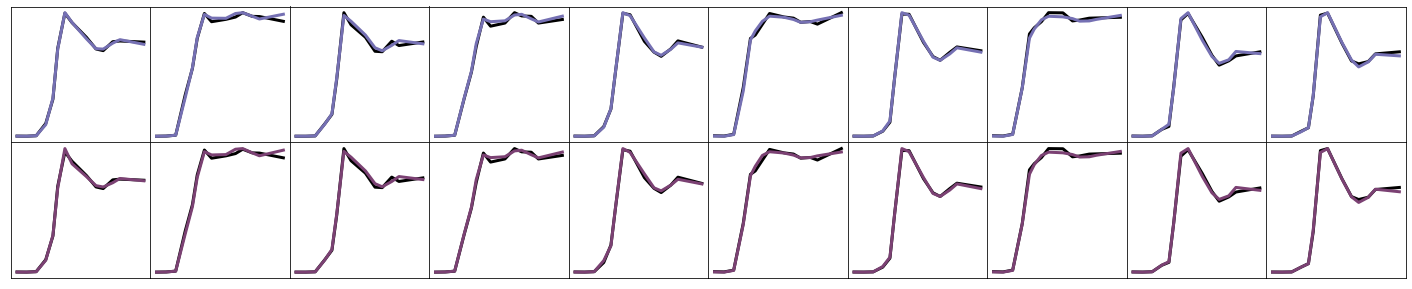

In [360]:
fig, axes = plt.subplots(figsize=(25, 5), ncols=10, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(10):
    for j in range(2):
        recon = basis.T @ y_preds[j][i]
        axes[j, i].plot(e, x_train[i], color='k', linewidth=3)
        axes[j, i].plot(e, recon, color=colors[j], linewidth=3)
        axes[j, i].set_yticks([])
        axes[j, i].set_xticks([])

In [363]:
utils = reload(utils)
from utils import *

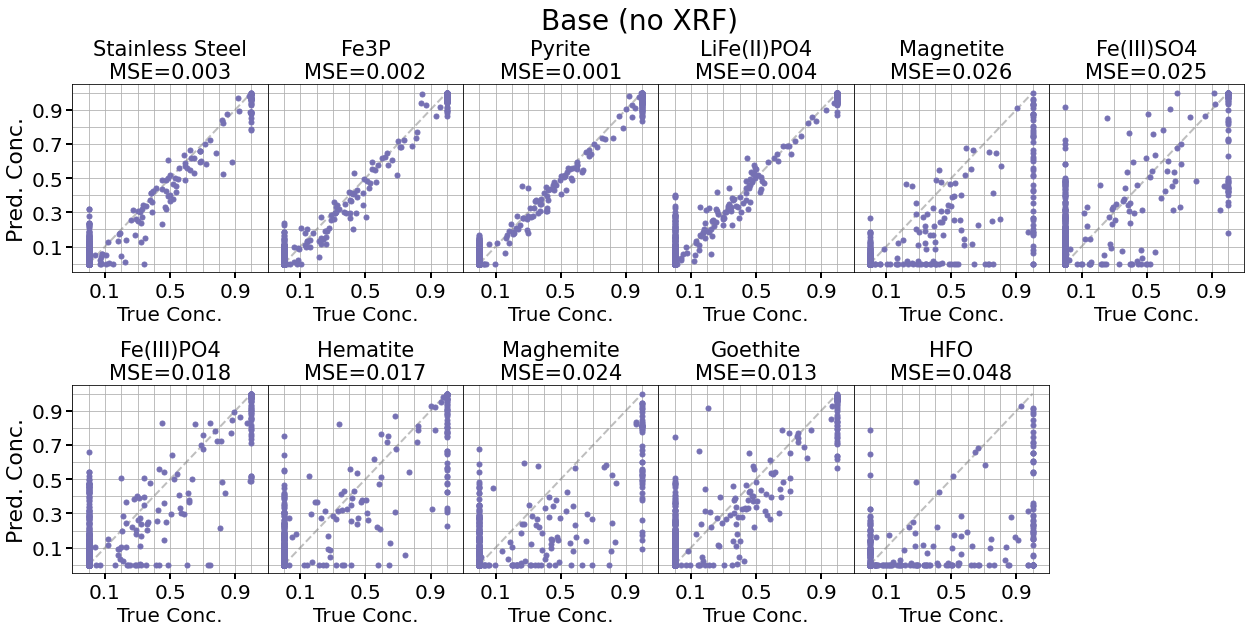

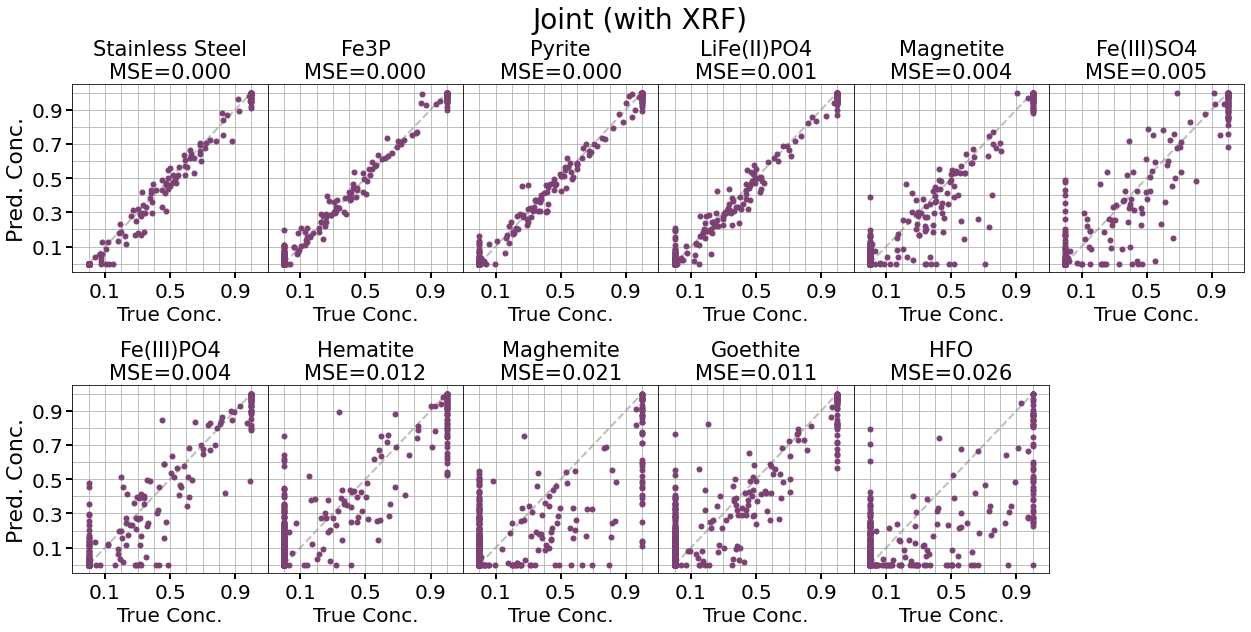

In [364]:
MSE = []
for i, title in enumerate(['Base (no XRF)', 'Joint (with XRF)']):
    nrows = 2
    ncols = 6
    fig, axes = plt.subplots(figsize=(3.5 * ncols, 4.5 * nrows),
                             ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0., hspace=0.6)

    mses = plot_true_vs_pred_conc((fig, axes), y_train, y_preds[i], data_columns, colors[i], nrows=nrows,
                                  ncols=ncols)
    MSE.append(mses)
    plt.suptitle(title, y=1., fontsize=28)
    plt.show()

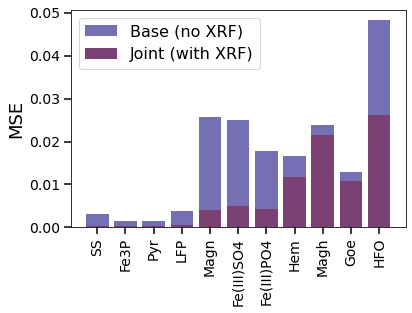

In [365]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(11), MSE[0], color=colors[0], label='Base (no XRF)')
ax.bar(np.arange(11), MSE[1], color=colors[1], label='Joint (with XRF)')
ax.legend(fontsize=16)
ax.set_xticks(np.arange(11))
ax.set_xticklabels(dcs)
ax.tick_params(length=7, labelsize=14, width=1.5)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('MSE', fontsize=18)
plt.show()

In [251]:
classes = dcs[:7]
classes.append('oxides')

def get_classed_coeffs(coeffs):
    classed_coeffs = coeffs[:, :8].copy()
    classed_coeffs[:, -1] = np.sum(coeffs[:, 7:], axis=1)
    return classed_coeffs

classed_y_train = get_classed_coeffs(y_train)

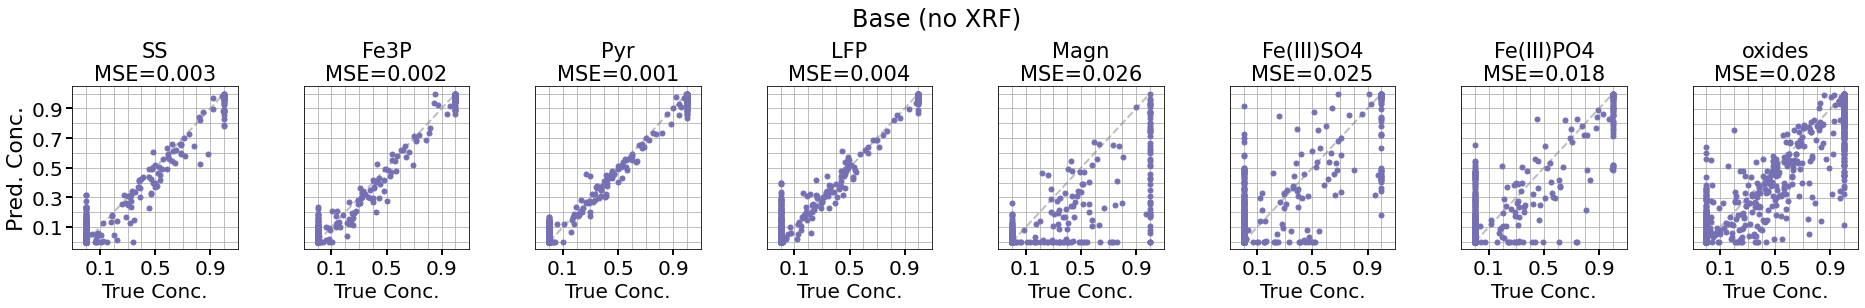

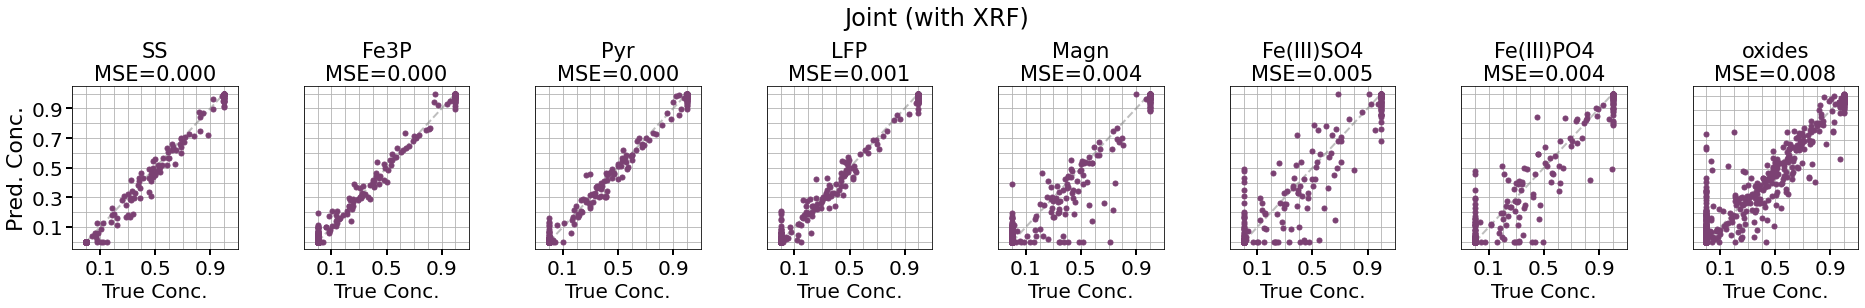

In [368]:
MSE = []
for i, title in enumerate(['Base (no XRF)', 'Joint (with XRF)']):
    y_pred = y_preds[i]
    classed_y_pred = get_classed_coeffs(y_pred)
    nrows = 1
    ncols = 8
    fig, axes = plt.subplots(figsize=(4 * ncols, 3 * nrows),
                             ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    mse = plot_true_vs_pred_conc((fig, axes), classed_y_train, classed_y_pred, classes, colors[i],
                                 nrows=nrows, ncols=ncols)
    plt.suptitle(title, y=1.25, fontsize=24)
    MSE.append(mse)
    plt.show()

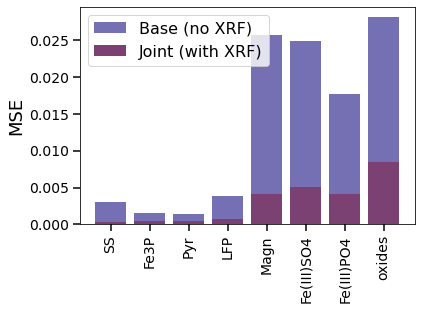

In [369]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(np.arange(8), MSE[0], color=colors[0], label='Base (no XRF)')
ax.bar(np.arange(8), MSE[1], color=colors[1], label='Joint (with XRF)')
ax.legend(fontsize=16)
ax.set_xticks(np.arange(8))
ax.set_xticklabels(classes)
ax.tick_params(length=7, labelsize=14, width=1.5)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('MSE', fontsize=18)
plt.show()

# XRF joint info on exp

In [233]:
data_columns

['Stainless Steel',
 'Fe3P',
 'Pyrite',
 'LiFe(II)PO4',
 'Magnetite',
 'Fe(III)SO4',
 'Fe(III)PO4',
 'Hematite',
 'Maghemite',
 'Goethite',
 'HFO']

In [235]:
true_contrib_indices = [0, 2, 3, 7]

targets = normalized_spectra
basis = Refs[true_contrib_indices]
#targets = postnormalized_subset
#basis = Y_Refs[true_contrib_indices]

shortlist_coeffs = np.array([list(nnls(basis.T, target)[0]) for target in targets])

expected_coeffs = np.zeros((len(targets), 11))
for j, idx in enumerate(true_contrib_indices):
    expected_coeffs[:, idx] = shortlist_coeffs[:, j]

expected_coeffs.shape

(6720, 11)

In [236]:
normalized_spectra_labels = []
for pt in list(xrf_dict.keys()):
    normalized_spectra_labels.append(xrf_dict[pt][-4:])
normalized_spectra_labels = np.array(normalized_spectra_labels)

In [238]:
basis = Refs
spectra = normalized_spectra 
#basis = Y_Refs
#spectra = postnormalized_subset
labels = normalized_spectra_labels

y_pred_xrf, bounds = get_coeffs_from_spectra_with_xrf(spectra, basis, labels=labels)
y_pred_base, _ = get_coeffs_from_spectra_with_xrf(spectra, basis, labels=None)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [239]:
y_preds = [y_pred_base, y_pred_xrf]

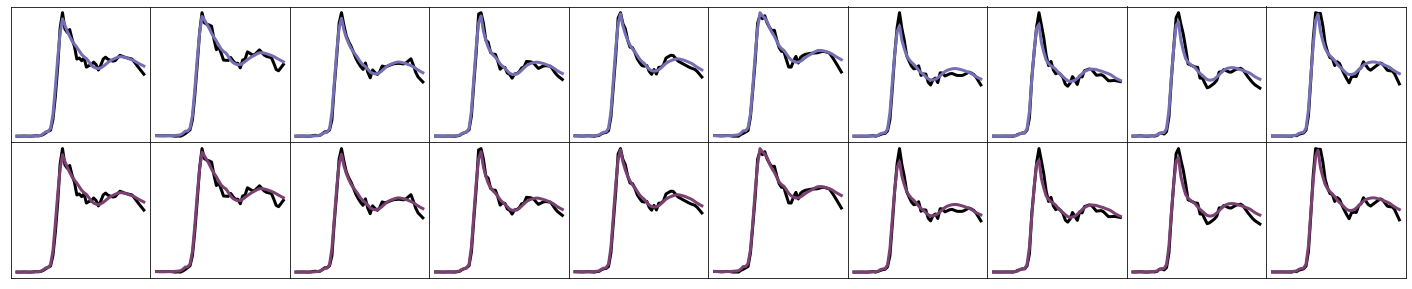

In [242]:
fig, axes = plt.subplots(figsize=(25, 5), ncols=10, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(10):
    for j in range(2):
        recon = basis.T @ y_preds[j][i]
        axes[j, i].plot(e, spectra[i], color='k', linewidth=3)
        axes[j, i].plot(e, recon, color=colors[j], linewidth=3)
        axes[j, i].set_yticks([])
        axes[j, i].set_xticks([])

In [243]:
utils = reload(utils)
from utils import *

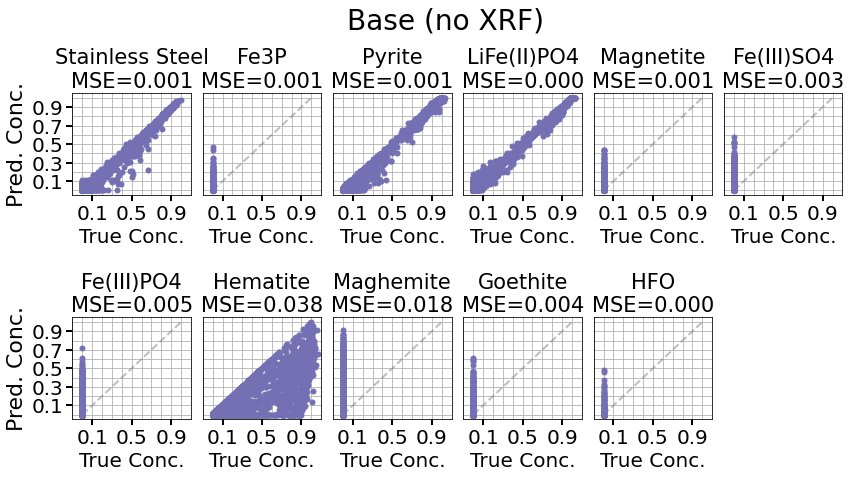

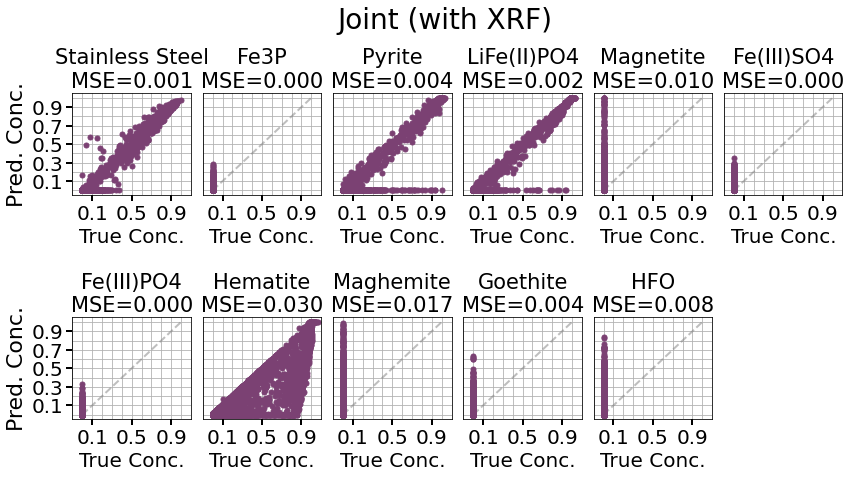

In [244]:
MSE = []
for i, title in enumerate(['Base (no XRF)', 'Joint (with XRF)']):
    nrows = 2
    ncols = 6
    fig, axes = plt.subplots(figsize=(2.3 * ncols, 3. * nrows),
                             ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0.1, hspace=1.2)
    mses = plot_true_vs_pred_conc((fig, axes), expected_coeffs, y_preds[i], data_columns, colors[i],
                                  nrows=nrows, ncols=ncols)
    MSE.append(mses)
    plt.suptitle(title, y=1.08, fontsize=28)
    plt.show()

In [252]:
classed_expected_coeffs = get_classed_coeffs(expected_coeffs)

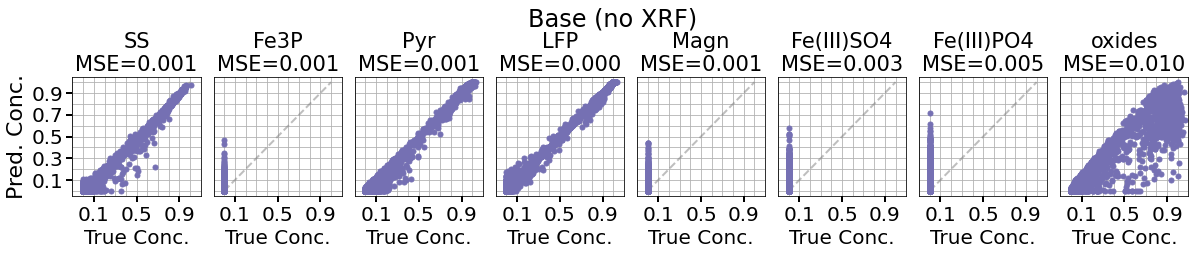

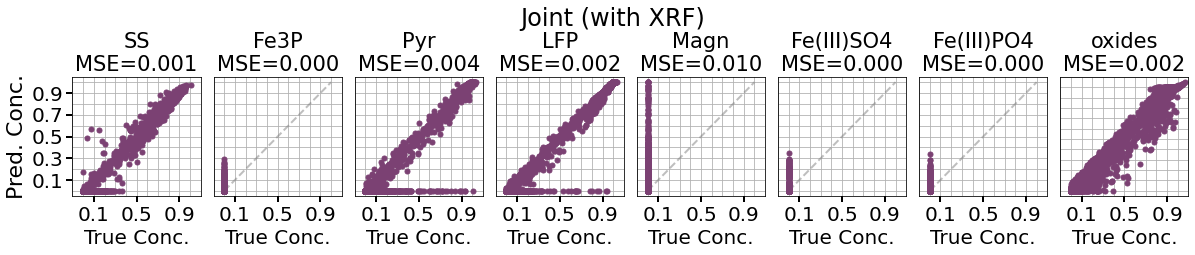

In [253]:
MSE = []
for i, title in enumerate(['Base (no XRF)', 'Joint (with XRF)']):
    y_pred = y_preds[i]
    classed_y_pred = get_classed_coeffs(y_pred)
    nrows = 1
    ncols = 8
    fig, axes = plt.subplots(figsize=(2.5 * ncols, 2.2 * nrows),
                             ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0.1, hspace=0.6)
    mse = plot_true_vs_pred_conc((fig, axes), classed_expected_coeffs, classed_y_pred, classes, colors[i],
                                 nrows=nrows, ncols=ncols)
    plt.suptitle(title, y=1.32, fontsize=24)
    MSE.append(mse)
    plt.show()

In [254]:
y_pred = y_preds[1]
classed_y_pred = get_classed_coeffs(y_pred)

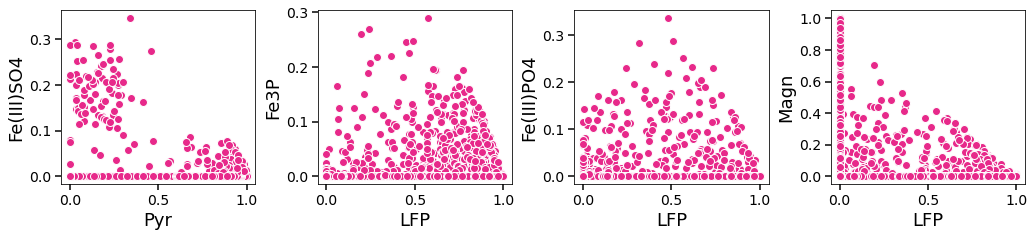

In [255]:
idxs = [[2, 5], [3, 1], [3, 6], [3, 4]]

ncols = len(idxs)
fig, axes = plt.subplots(figsize=((ncols + .08 * ncols) * ncols, ncols * 0.8), ncols=ncols)
plt.subplots_adjust(wspace=0.08 * ncols)
for i, ax in enumerate(axes):
    ax.plot(classed_y_pred[:, idxs[i][0]], classed_y_pred[:, idxs[i][1]], marker='o',
            color=plt.cm.Dark2(3), markeredgecolor='w', linestyle='none', markersize=8)
    ax.set_xlabel(classes[idxs[i][0]], fontsize=18)
    ax.set_ylabel(classes[idxs[i][1]], fontsize=18)
    ax.tick_params(labelsize=14, length=6, width=1.5)

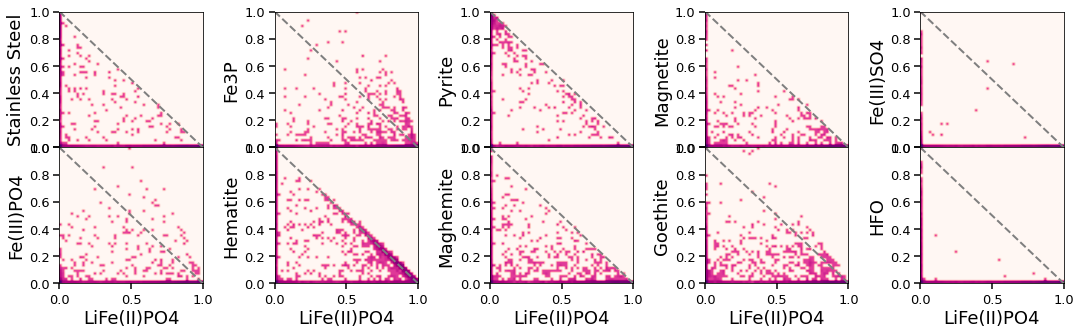

In [256]:
ref_idx = 3
idxs = [[ref_idx, i] for i in range(len(data_columns)) if i != ref_idx]

ncols = 5
nrows = 2
bins = 50

fig, axes = plt.subplots(figsize=(18, 5), ncols=ncols, nrows=nrows)
plt.subplots_adjust(wspace=0.5, hspace=0.)
for i, axlist in enumerate(axes):
    for j, ax in enumerate(axlist):
        idx = i * ncols + j
        #ax.plot(y_pred[:, idxs[idx][0]], y_pred[:, idxs[idx][1]], marker='o',
        #        color=plt.cm.Dark2(2), markeredgecolor='w', linestyle='none', markersize=8)
        heatmap, xedges, yedges = np.histogram2d(y_pred[:, idxs[idx][0]],
                                                 y_pred[:, idxs[idx][1]],
                                                 bins=bins)
        extent = [0.0, 1.0, 0.0, 1.0]
        ax.imshow(np.log(heatmap.T + 1e-5), extent=extent, origin='lower',
                  aspect='auto', cmap=plt.cm.RdPu)
        
        ax.plot([0, 1], [1, 0], '--', c=plt.cm.tab10(7), linewidth=2)
        ax.set_xlabel(data_columns[idxs[idx][0]], fontsize=18)
        ax.set_ylabel(data_columns[idxs[idx][1]], fontsize=18)
        ax.tick_params(labelsize=13, length=6, width=1.5)
        if i == 0:
            ax.set_xticks([])
            ax.set_xlabel(None)

(array([1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 8.000e+00,
        2.900e+01, 1.090e+02, 3.710e+02, 8.990e+02, 1.531e+03, 1.742e+03,
        1.302e+03, 4.690e+02, 1.630e+02, 6.900e+01, 1.400e+01, 5.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.90815517, 0.91552906, 0.92290296, 0.93027685, 0.93765075,
        0.94502464, 0.95239854, 0.95977243, 0.96714633, 0.97452022,
        0.98189412, 0.98926801, 0.99664191, 1.0040158 , 1.0113897 ,
        1.01876359, 1.02613749, 1.03351138, 1.04088527, 1.04825917,
        1.05563306]),
 <BarContainer object of 20 artists>)

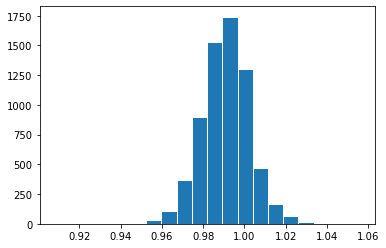

In [257]:
plt.hist(np.sum(y_pred, axis=1), edgecolor='w', bins=20)

# Spatial maps using LCF pixel by pixel with XRF joint info

In [258]:
y_pred_xrf.shape

(6720, 11)

In [259]:
filtered_mask = mask[0, :, :]
filtered_mask.shape

(155, 160)

In [260]:
d1 = classed_expected_coeffs
d2 = get_classed_coeffs(y_pred_base)
d3 = get_classed_coeffs(y_pred_xrf)
labels = classes
distance = np.array([wasserstein_distance([d1[idx, j]], [d3[idx, j]])
                     for idx in range(len(normalized_spectra))
                     for j in range(len(labels))]).reshape(-1, len(labels))

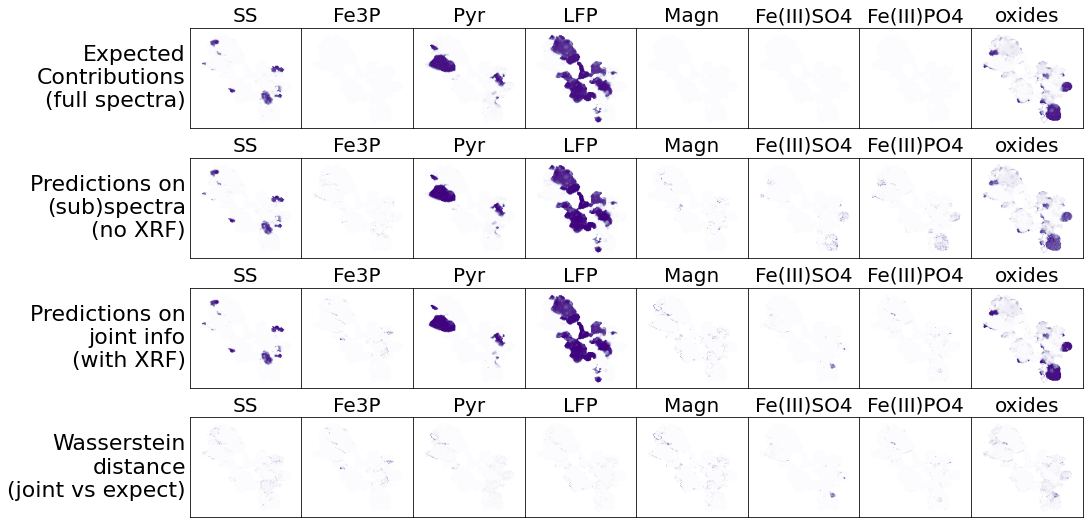

In [261]:
fig, axes = plt.subplots(figsize=(len(labels) * 2, 2 * 4.5), ncols=len(labels), nrows=4)
plt.subplots_adjust(wspace=0, hspace=0.3)

data = [d1, d2, d3, distance]
ylabels = ['Expected\nContributions\n(full spectra)', 'Predictions on\n(sub)spectra\n(no XRF)',
          'Predictions on\njoint info\n(with XRF)', 'Wasserstein\ndistance\n(joint vs expect)']

for j, axlist in enumerate(axes):
    for i, ax in enumerate(axlist):
        img = generate_img(filtered_mask, normalized_spectra_dict, data[j][:, i])
        ax.imshow(img, extent=[0, 1, 0, 1], aspect='auto', cmap=plt.cm.Purples,
                  alpha=1 - filtered_mask)
        remove_ticks(ax) 
        ax.set_title(labels[i], fontsize=20)

    axlist[0].set_ylabel(ylabels[j], fontsize=22, rotation=0, ha='right', va='center')

plt.show()

(155, 160)


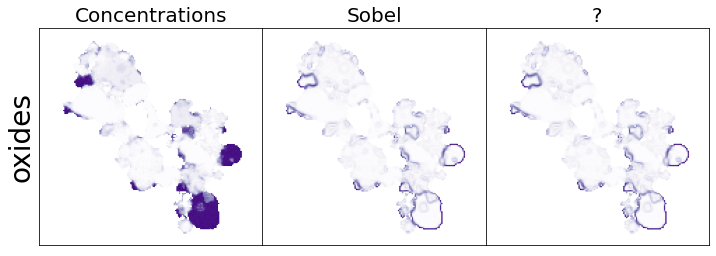

In [268]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)
plt.subplots_adjust(wspace=0)
cmap = plt.cm.Purples

i = 7
img = generate_img(filtered_mask, normalized_spectra_dict, data[2][:, i])
print(img.shape)
titles = ['Concentrations', 'Sobel', '?']

axes[0].imshow(img, extent=[0, 1, 0, 1], aspect='auto', cmap=cmap,
               alpha=1 - filtered_mask)

axes[1].imshow(sobel(img), extent=[0, 1, 0, 1], aspect='auto', cmap=cmap,
               alpha=1 - filtered_mask)

axes[2].imshow(sobel(img), extent=[0, 1, 0, 1], aspect='auto', cmap=cmap,
               alpha=1 - filtered_mask)

for j, ax in enumerate(axes):
    remove_ticks(ax) 
    ax.set_title(titles[j], fontsize=20)

axes[0].set_ylabel(labels[i], fontsize=28)

plt.show()

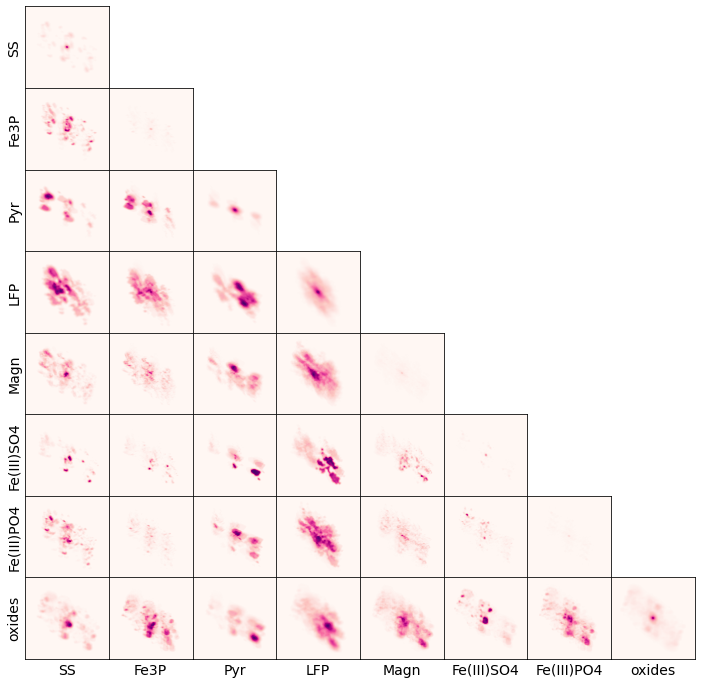

In [395]:
n_classes = len(labels)
fig, axes = plt.subplots(figsize=(n_classes * 1.5, n_classes * 1.5),
                         ncols=n_classes, nrows=n_classes)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(n_classes):
    for j in range(n_classes):
        if j <= i:
            img1 = generate_img(filtered_mask, normalized_spectra_dict, data[2][:, i])
            img2 = generate_img(filtered_mask, normalized_spectra_dict, data[2][:, j])
            corr = correlate(img1, img2)
            axes[i, j].imshow(corr, extent=[0, 1, 0, 1], aspect='auto', cmap=plt.cm.RdPu)
            if j == 0:
                axes[i, j].set_ylabel(labels[i], fontsize=14)
            if i == n_classes - 1:
                axes[i, j].set_xlabel(labels[j], fontsize=14)
            axes[i, j].set_yticks([])
            axes[i, j].set_xticks([])
        else:
            axes[i, j].axis('off')